# PyGEM-WBM Sea Level Analysis
Analyze WBM to determine fraction of glacier mass loss/runoff that reaches ocean and contributes to sea-level rise.

In [1]:
import os

import cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import rasterio
from scipy.ndimage import uniform_filter
from scipy.spatial import ConvexHull
from shapely.geometry import Point
import xarray as xr

### Filenames

In [2]:
main_directory = os.getcwd()

basin_csv_fn = 'MERIT_plus_15min_v1_IDs_super.csv'
basin_tif_fn = 'MERIT_plus_15min_v1_IDs_wcrs.tif'
rgiids_wbasins_fn = 'RGI60_wMERIT_IDs.csv'

rgi_shp_fn = '/Users/drounce/Documents/HiMAT/PyGEM-analysis/wbm_results/qgis/rgi60_all_simplified2_robinson.shp'
rgi_regions_fn = '/Users/drounce/Documents/HiMAT/PyGEM-analysis/wbm_results/qgis/rgi60_regions_robinson-v2.shp'

wbm_fp_primary = '/Volumes/TOSHIBA-WBM/NSLCT/'
pygem_output_fp = '/Users/drounce/Documents/HiMAT/spc_backup/nsidc/glacier_stats/'

results_fp = 'wbm_results/'
if not os.path.exists(results_fp):
    os.makedirs(results_fp)

# scenarios = ['ssp126']
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
gcm_names = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 
             'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']
# gcm_names = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 
#              'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0']

vns = ['discharge_m3s_pg', 'discharge', 'glMelt']

# RGI data
rgi_fp = main_directory + '/../RGI/rgi60/00_rgi60_attribs/'
rgi_O1Id_colname = 'glacno'
rgi_glacno_float_colname = 'RGIId_float'
rgi_cols_drop = ['GLIMSId','BgnDate','EndDate','Status','Linkages']

# Exorheic Option for fraction reaching ocean (1 = average over time period; 2 = individual values, capped to ensure realistic)
  # - they result in the same answer
  # However, should use option 2 because some basins (e.g., Ganges) see a drastic change in the fraction reaching the ocean over time.
  # Hence, you want to captuion this.
exor_frac_option = 2

# Plotting details
ssp_name_dict = {'ssp126':'SSP1-2.6',
                 'ssp245':'SSP2-4.5',
                 'ssp370':'SSP3-7.0',
                 'ssp585':'SSP5-8.5',
                }
# ssp_colordict = {'ssp119':'#081d58', 'ssp126':'#1d91c0', 'ssp245':'#7fcdbb', 'ssp370':'#F47A20', 'ssp585':'#ED2024'}
# ssp_colordict = {'ssp126':'#2D446B', 'ssp245':'#DE944B', 'ssp370':'#CD4644', 'ssp585':'#7E2825'} # IPCC AR6 colors
ssp_colordict = {'ssp126':'#DE944B', 'ssp245':'#D25B4E', 'ssp370':'#9F2C2A', 'ssp585':'#7E2825'} # Yellow-Red

rgi_reg_dict = {'all':'Global',
                'global':'Global',
                1:'Alaska',
                2:'W Canada & US',
                3:'Arctic Canada North',
                4:'Arctic Canada South',
                5:'Greenland Periphery',
                6:'Iceland',
                7:'Svalbard',
                8:'Scandinavia',
                9:'Russian Arctic',
                10:'North Asia',
                11:'Central Europe',
                12:'Caucasus & Middle East',
                13:'Central Asia',
                14:'South Asia West',
                15:'South Asia East',
                16:'Low Latitudes',
                17:'Southern Andes',
                18:'New Zealand',
                19:'Antarctic & Subantarctic'
                }

In [3]:
def mass_to_mmSLE(mass, mass_bsl, rho_ice=900, rho_water=1000, area_ocean=362.5*1e12):
    """ Calculate annual SLR accounting for the ice below sea level following Rounce et al. (2023), 
     which is consistent with OGGM (https://oggm.org/2021/03/04/slr-bsl/)."""
    # Volume of water that will contribute to sea-level rise
    vol_water = mass / rho_water 
    # Volume of ice (i.e., water displaced currently) that must be considered
    vol_bsl_ice = mass_bsl / rho_ice

    mass_mmSLE = (vol_water - vol_bsl_ice) / area_ocean * 1000

    return mass_mmSLE

def slr_mmSLEyr(reg_vol, reg_vol_bsl, rho_ice=900, rho_water=1000, area_ocean=362.5*1e12):
    """ Calculate annual SLR accounting for the ice below sea level following Farinotti et al. (2019) """
    # Farinotti et al. (2019)
#    reg_vol_asl = reg_vol - reg_vol_bsl
#    return (-1*(reg_vol_asl[:,1:] - reg_vol_asl[:,0:-1]) * 
#            pygem_prms.density_ice / pygem_prms.density_water / pygem_prms.area_ocean * 1000)
    
    # OGGM new approach
    if len(reg_vol.shape) == 2:
        return (-1*(((reg_vol[:,1:] - reg_vol[:,0:-1]) * rho_ice / rho_water - 
                 (reg_vol_bsl[:,1:] - reg_vol_bsl[:,0:-1])) / area_ocean * 1000))
    elif len(reg_vol.shape) == 3:
        return (-1*(((reg_vol[:,:,1:] - reg_vol[:,:,0:-1]) * rho_ice / rho_water - 
                 (reg_vol_bsl[:,:,1:] - reg_vol_bsl[:,:,0:-1])) / area_ocean * 1000))
    else:
        assert 1==0, 'must code other shapes'
        return 1

def selectglaciersrgitable(glac_no=None, rgi_regionsO1=None, rgi_regionsO2='all', rgi_glac_number='all',
                           rgi_fp=rgi_fp, 
                           rgi_cols_drop=rgi_cols_drop,
                           rgi_O1Id_colname=rgi_O1Id_colname,
                           rgi_glacno_float_colname=rgi_glacno_float_colname,
                           indexname='GlaNo',
                           include_landterm=True,include_laketerm=True,include_tidewater=True,
                           glac_no_skip=None,
                           min_glac_area_km2=0):
    """
    Select all glaciers to be used in the model run according to the regions and glacier numbers defined by the RGI
    glacier inventory. This function returns the rgi table associated with all of these glaciers.

    glac_no : list of strings
        list of strings of RGI glacier numbers (e.g., ['1.00001', '13.00001'])
    rgi_regionsO1 : list of integers
        list of integers of RGI order 1 regions (e.g., [1, 13])
    rgi_regionsO2 : list of integers or 'all'
        list of integers of RGI order 2 regions or simply 'all' for all the order 2 regions
    rgi_glac_number : list of strings
        list of RGI glacier numbers without the region (e.g., ['00001', '00002'])

    Output: Pandas DataFrame of the glacier statistics for each glacier in the model run
    (rows = GlacNo, columns = glacier statistics)
    """
    if glac_no is not None:
        glac_no_byregion = {}
        rgi_regionsO1 = [int(i.split('.')[0]) for i in glac_no]
        rgi_regionsO1 = list(set(rgi_regionsO1))
        for region in rgi_regionsO1:
            glac_no_byregion[region] = []
        for i in glac_no:
            region = i.split('.')[0]
            glac_no_only = i.split('.')[1]
            glac_no_byregion[int(region)].append(glac_no_only)

        for region in rgi_regionsO1:
            glac_no_byregion[region] = sorted(glac_no_byregion[region])

    # Create an empty dataframe
    rgi_regionsO1 = sorted(rgi_regionsO1)
    glacier_table = pd.DataFrame()
    for region in rgi_regionsO1:

        if glac_no is not None:
            rgi_glac_number = glac_no_byregion[region]

#        if len(rgi_glac_number) < 50:

        for i in os.listdir(rgi_fp):
            if i.startswith(str(region).zfill(2)) and i.endswith('.csv'):
                rgi_fn = i
        try:
            csv_regionO1 = pd.read_csv(rgi_fp + rgi_fn)
        except:
            csv_regionO1 = pd.read_csv(rgi_fp + rgi_fn, encoding='latin1')
        
        # Populate glacer_table with the glaciers of interest
        if rgi_regionsO2 == 'all' and rgi_glac_number == 'all':
            # print("All glaciers within region(s) %s are included in this model run." % (region))
            if glacier_table.empty:
                glacier_table = csv_regionO1
            else:
                glacier_table = pd.concat([glacier_table, csv_regionO1], axis=0)
        elif rgi_regionsO2 != 'all' and rgi_glac_number == 'all':
            # print("All glaciers within subregion(s) %s in region %s are included in this model run." %
                  # (rgi_regionsO2, region))
            for regionO2 in rgi_regionsO2:
                if glacier_table.empty:
                    glacier_table = csv_regionO1.loc[csv_regionO1['O2Region'] == regionO2]
                else:
                    glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[csv_regionO1['O2Region'] ==
                                                                                regionO2]], axis=0))
        else:
            # if len(rgi_glac_number) < 20:
            #     print("%s glaciers in region %s are included: %s" % (len(rgi_glac_number), region, rgi_glac_number))
            # else:
            #     print("%s glaciers in region %s are included" % (len(rgi_glac_number), region))
                
            rgiid_subset = ['RGI60-' + str(region).zfill(2) + '.' + x for x in rgi_glac_number] 
            rgiid_all = list(csv_regionO1.RGIId.values)
            rgi_idx = [rgiid_all.index(x) for x in rgiid_subset if x in rgiid_all]
            if glacier_table.empty:
                glacier_table = csv_regionO1.loc[rgi_idx]
            else:
                glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[rgi_idx]],
                                           axis=0))
                    
    glacier_table = glacier_table.copy()
    # reset the index so that it is in sequential order (0, 1, 2, etc.)
    glacier_table.reset_index(inplace=True)
    # drop connectivity 2 for Greenland and Antarctica
    glacier_table = glacier_table.loc[glacier_table['Connect'].isin([0,1])]
    glacier_table.reset_index(drop=True, inplace=True)
    # change old index to 'O1Index' to be easier to recall what it is
    glacier_table.rename(columns={'index': 'O1Index'}, inplace=True)
    # Record the reference date
    glacier_table['RefDate'] = glacier_table['BgnDate']
    # if there is an end date, then roughly average the year
    enddate_idx = glacier_table.loc[(glacier_table['EndDate'] > 0), 'EndDate'].index.values
    glacier_table.loc[enddate_idx,'RefDate'] = (
            np.mean((glacier_table.loc[enddate_idx,['BgnDate', 'EndDate']].values / 10**4).astype(int),
                    axis=1).astype(int) * 10**4 + 9999)
    # drop columns of data that is not being used
    glacier_table.drop(rgi_cols_drop, axis=1, inplace=True)
    # add column with the O1 glacier numbers
    glacier_table[rgi_O1Id_colname] = (
            glacier_table['RGIId'].str.split('.').apply(pd.Series).loc[:,1].astype(int))
    glacier_table['rgino_str'] = [x.split('-')[1] for x in glacier_table.RGIId.values]
#    glacier_table[rgi_glacno_float_colname] = (np.array([np.str.split(glacier_table['RGIId'][x],'-')[1]
#                                                    for x in range(glacier_table.shape[0])]).astype(float))
    glacier_table[rgi_glacno_float_colname] = (np.array([x.split('-')[1] for x in glacier_table['RGIId']]
#            [np.str.split(glacier_table['RGIId'][x],'-')[1]
#                                                    for x in range(glacier_table.shape[0])]
            ).astype(float))
    # set index name
    glacier_table.index.name = indexname
    # Longitude between 0-360deg (no negative)
    glacier_table['CenLon_360'] = glacier_table['CenLon']
    glacier_table.loc[glacier_table['CenLon'] < 0, 'CenLon_360'] = (
            360 + glacier_table.loc[glacier_table['CenLon'] < 0, 'CenLon_360'])
    # Subset glaciers based on their terminus type
    termtype_values = []
    if include_landterm:
        termtype_values.append(0)
        # assume dry calving, regenerated, and not assigned are land-terminating
        termtype_values.append(3)
        termtype_values.append(4)
        termtype_values.append(9)
    if include_tidewater:
        termtype_values.append(1)
        # assume shelf-terminating glaciers are tidewater
        termtype_values.append(5)
    if include_laketerm:
        termtype_values.append(2)
    glacier_table = glacier_table.loc[glacier_table['TermType'].isin(termtype_values)]
    glacier_table.reset_index(inplace=True, drop=True)
    # Glacier number with no trailing zeros
    glacier_table['glacno'] = [str(int(x.split('-')[1].split('.')[0])) + '.' + x.split('-')[1].split('.')[1]
                               for x in glacier_table.RGIId]
    
    # Remove glaciers below threshold
    glacier_table = glacier_table.loc[glacier_table['Area'] > min_glac_area_km2,:]
    glacier_table.reset_index(inplace=True, drop=True)

    # Remove glaciers that are meant to be skipped
    if glac_no_skip is not None:
        glac_no_all = list(glacier_table['glacno'])
        glac_no_unique = [x for x in glac_no_all if x not in glac_no_skip]
        unique_idx = [glac_no_all.index(x) for x in glac_no_unique]
        glacier_table = glacier_table.loc[unique_idx,:]
        glacier_table.reset_index(inplace=True, drop=True)

    # print("This study is focusing on %s glaciers in region %s" % (glacier_table.shape[0], rgi_regionsO1))

    return glacier_table

#### Key notes:
The aggregation step (i.e., whether you use annual time series of the fractions that reach the ocean or just use the full time period's average) makes no difference on the impact to the glacier's contributions to sea-level rise.

Basins where the fraction is greater than 1 doesn't have an impact on the results either since these are often very small values above 1 or the actual discharge is very small.

Mass gain (i.e., negative sea-level rise) is multiplied by fractions just like mass loss.

# Confirmation of SLR Estimates with Rounce et al. (2023)

In [4]:
glac_vns = ['mass_annual', 'mass_bsl_annual']
# glac_vns = ['mass_annual']

regions = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

ds_vn_dict = {'area_annual': 'glac_area_annual', 
              'mass_annual': 'glac_mass_annual',
              'mass_bsl_annual': 'glac_mass_bsl_annual',
              'runoff_monthly': 'glac_runoff_fixed_monthly'}

global_mass_dict = {}
global_mass_bsl_dict = {}
nontw_idx_dict = {}
reg_mass_dict = {}
# Load and aggregate data
for scenario in scenarios:
    reg_mass_dict[scenario] = {}
    for glac_vn in glac_vns:
        print(scenario, glac_vn)
        for nreg, reg in enumerate(regions):

            # print(reg, scenario, glac_vn)
            
            # ----- NETCDF FILEPATHS AND FILENAMES -----
            # Filenames
            fp_reg_vn = pygem_output_fp + glac_vn + '/' + str(reg).zfill(2) + '/'
            
            fn_batches = []
            for fn in os.listdir(fp_reg_vn):
                if glac_vn in fn and scenario in fn:
                    fn_batches.append(fn)
     
            # Load data
            vn_scenario = None
            for fn in fn_batches:

                ds_batch = xr.open_dataset(fp_reg_vn + fn)
                
                ds_vn = ds_vn_dict[glac_vn]
                
                reg_vn_scenario_raw = ds_batch[ds_vn].values

                # Select specific GCM data
                gcm_dict = {}
                for i in ds_batch.Climate_Model.attrs.keys():
                    try:
                        # print(int(i), ds_batch.Climate_Model.attrs[i])
                        gcm_dict[int(i)] = ds_batch.Climate_Model.attrs[i]
                    except:
                        pass
                ds_gcm_names = []
                for i in ds_batch.Climate_Model.values:
                    ds_gcm_names.append(gcm_dict[i])
                
                ds_gcm_idxs = []
                for gcm_name in gcm_names:
                    ds_gcm_idxs.append(ds_gcm_names.index(gcm_name))
                ds_gcm_idxs
                
                reg_vn_scenario = reg_vn_scenario_raw[ds_gcm_idxs,:,:]

                # Aggregate
                if vn_scenario is None:
                    vn_scenario = reg_vn_scenario
                    vn_rgiids = list(ds_batch.RGIId.values)
                    years = ds_batch.year.values
                else:
                    vn_scenario = np.concatenate((vn_scenario, reg_vn_scenario), axis=1)
                    vn_rgiids.extend(list(ds_batch.RGIId.values))

            # Load Glaciers to identify tidewater glaciers for bsl correction
            if glac_vn == 'mass_bsl_annual':
                if reg in list(nontw_idx_dict.keys()):
                    nontw_idx = nontw_idx_dict[reg]
                else:
                    glacno_list = [x.split('-')[1] for x in vn_rgiids]
                    main_glac_rgi_reg = selectglaciersrgitable(glac_no=glacno_list)
                    if main_glac_rgi_reg.TermType.sum() == 0:
                        tw_idx = []
                    else:
                        tw_idx = np.where((main_glac_rgi_reg.TermType.values == 1) | (main_glac_rgi_reg.TermType.values == 5))[0]
                        if len(tw_idx) == 0:
                            tw_idx = []
                    nontw_idx = [x for x in main_glac_rgi_reg.index.values if x not in tw_idx]
                    nontw_idx_dict[reg] = nontw_idx
    
                vn_scenario[:,nontw_idx,:] = 0
            
            vn_scenario_reg = vn_scenario.sum(1)

            if nreg == 0:
                vn_scenario_all = vn_scenario_reg
            else:
                vn_scenario_all = vn_scenario_all + vn_scenario_reg

            if glac_vn == 'mass_annual':
                reg_mass_dict[scenario][reg] = vn_scenario_reg
                mass_years = ds_batch.year.values

        if glac_vn == 'mass_annual':
            mass_annual_all = vn_scenario_all
        elif glac_vn == 'mass_bsl_annual':
            mass_bsl_annual_all = vn_scenario_all

    global_mass_dict[scenario] = mass_annual_all
    global_mass_bsl_dict[scenario] = mass_bsl_annual_all

    reg_mass_dict[scenario]['all'] = mass_annual_all

ssp126 mass_annual
ssp126 mass_bsl_annual
ssp245 mass_annual
ssp245 mass_bsl_annual
ssp370 mass_annual
ssp370 mass_bsl_annual
ssp585 mass_annual
ssp585 mass_bsl_annual


In [5]:
print('Sea Level Rise from 2015 to 2100 (mm SLE)')
print('  scenario - SLR - SLR (uncorrected)')
for scenario in scenarios:
    mass_annual_all = global_mass_dict[scenario]
    mass_bsl_annual_all = global_mass_bsl_dict[scenario]

    vol_all = mass_annual_all / 900
    vol_bsl_all = mass_bsl_annual_all / 900
    
    slr_all = slr_mmSLEyr(vol_all, vol_bsl_all)
    slr_all_nobsl = slr_mmSLEyr(vol_all, np.zeros(vol_all.shape))
    print('   ', scenario)
    print('     ',int(np.round(np.median(slr_all[:,16:].sum(1)))), '+/-', int(np.round(1.96*np.std(slr_all[:,16:].sum(1))))) 
    print('     ',int(np.round(np.median(slr_all_nobsl[:,16:].sum(1)))), '+/-', int(np.round(1.96*np.std(slr_all_nobsl[:,16:].sum(1)))))

Sea Level Rise from 2015 to 2100 (mm SLE)
  scenario - SLR - SLR (uncorrected)
    ssp126
      98 +/- 38
      115 +/- 42
    ssp245
      116 +/- 51
      135 +/- 57
    ssp370
      147 +/- 64
      171 +/- 73
    ssp585
      166 +/- 83
      192 +/- 97


# Basin-wide Applications
- Remove Greenland basins
- Aggregate to single dataset

Note: values should only be used for the reduction in sea-level rise. Note that below sea level values adjustments are less important in this framework as marine-terminating glaciers contribute 100% regardless, and the RGI Region analysis is done separately below.

In [6]:
rgi60_basin_df = pd.read_csv('RGI60_wMERIT_IDs.csv')
rgi60_basin_df_greenland = rgi60_basin_df.loc[rgi60_basin_df['O1Region'] == 5]
print(rgi60_basin_df_greenland.shape[0], 'glaciers in Greenland')

basin_ids_greenland = list(np.unique(rgi60_basin_df_greenland.MeritID.values))
print(len(basin_ids_greenland), 'basins in Greenland')

19306 glaciers in Greenland
1072 basins in Greenland


In [7]:
# Three datasets (all together, uncommon, and common)
uncommon_basin_slr_mmSLE = {}
uncommon_basin_slr_mmSLE_raw = {}

common_basin_slr_mmSLE = {}
common_basin_slr_mmSLE_raw = {}

for scenario in scenarios:
    print(scenario)

    basin_ids_all = []
    uncommon_basin_ids_all = []
    common_basin_ids_all = []

    # ----- Load Data -----
    ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
    ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
    ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)

    ds_pygem_fp = 'pygem_processed/basin_data/'
    ds_pygem_fn = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-common.nc'
    ds_pygem = xr.open_dataset(ds_pygem_fp + ds_pygem_fn)

    ds_pygem_fn_uncommon = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-uncommon-w19.nc'
    ds_pygem_uncommon = xr.open_dataset(ds_pygem_fp + ds_pygem_fn_uncommon)

    glmelt = ds_wbm.glmelt.values
    q_pg = ds_wbm.discharge_pg.values

    # Basin database (including interbasin transfers) prepared by Stanley Gliddon 8/14/2024
    df_basins = pd.read_csv('MERIT_plus_15min_v1_IDs_super.csv')
    df_basin_ids = list(df_basins.ID.values)
    
    # Subset to common years
    years_wbm = ds_wbm.year.values
    years_mass = ds_pygem.year.values
    year_idx_start = np.where(years_mass == years_wbm[0])[0][0]
    year_idx_end = np.where(years_mass == years_wbm[-1]+1)[0][0]

ssp126
ssp245
ssp370
ssp585


## Process datasets for sea level contributions and export
Note: for exor_frac_option == 2, when annual values are used, this can result in very unrealisitc values. This occurs when:
- glmelt is zero (i.e., dividing by zero)
- glmelt_exor is tiny and thus fraction is huge (note: if glmelt is small, then q_pg_exor should also be small)

Therefore, when this option is used, we do two things. We define unrealistic values as those where
- glmelt is zero
- frac_exor_2ocean > 2

We then replace them with the average for each gcm and basin.

In [8]:
ds_pygem_fp = 'pygem_processed/basin_data/'
ds_slr_fn = 'pygem_2000_2100-basin_annual_slr_mmSLE.nc'
if not os.path.exists(ds_pygem_fp + ds_slr_fn):
# for batman in [0]:

    # Three datasets (all together, uncommon, and common)
    uncommon_basin_slr_mmSLE = {}
    uncommon_basin_slr_mmSLE_raw = {}
    
    common_basin_slr_mmSLE = {}
    common_basin_slr_mmSLE_raw = {}
    
    for scenario in scenarios:
        print(scenario)
    
        basin_ids_all = []
        uncommon_basin_ids_all = []
        common_basin_ids_all = []
    
        # ----- Load Data -----
        ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
        ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
        ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)
    
        ds_pygem_fp = 'pygem_processed/basin_data/'
        ds_pygem_fn = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-common.nc'
        ds_pygem = xr.open_dataset(ds_pygem_fp + ds_pygem_fn)
    
        ds_pygem_fn_uncommon = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-uncommon-w19.nc'
        ds_pygem_uncommon = xr.open_dataset(ds_pygem_fp + ds_pygem_fn_uncommon)
    
        glmelt = ds_wbm.glmelt.values
        q_pg = ds_wbm.discharge_pg.values
    
        # Basin database (including interbasin transfers) prepared by Stanley Gliddon 8/14/2024
        df_basins = pd.read_csv('MERIT_plus_15min_v1_IDs_super.csv')
        df_basin_ids = list(df_basins.ID.values)
        
        # Subset to common years
        years_wbm = ds_wbm.year.values
        years_mass = ds_pygem.year.values
        year_idx_start = np.where(years_mass == years_wbm[0])[0][0]
        year_idx_end = np.where(years_mass == years_wbm[-1]+1)[0][0]
    
        
        # ----- UNCOMMON BASINS -----
        # Contribute 100% to sea-level rise
        # mass_uncommon = ds_pygem_uncommon.mass_annual.values[:,:,year_idx_start:year_idx_end+1]
        # mass_bsl_uncommon = ds_pygem_uncommon.mass_bsl_annual.values[:,:,year_idx_start:year_idx_end+1]
        mass_uncommon = ds_pygem_uncommon.mass_annual.values
        mass_bsl_uncommon = ds_pygem_uncommon.mass_bsl_annual.values

        # Convert to mm SLE
        mass_mmSLE_uncommon = mass_to_mmSLE(mass_uncommon, mass_bsl_uncommon)
        
        # Compute SLR contribution for each GCM and year
        slr_mmSLE_uncommon = mass_mmSLE_uncommon[:,:,0:-1] - mass_mmSLE_uncommon[:,:,1:]

        # Record to eventually create dataset
        uncommon_basin_slr_mmSLE[scenario] = slr_mmSLE_uncommon
        uncommon_basin_slr_mmSLE_raw[scenario] = slr_mmSLE_uncommon
        uncommon_basin_ids_all.extend(list(ds_pygem_uncommon.basin_ids.values))


        # ----- ENDORHEIC AND EXORHEIC BASINS -----
        # These basin are "common" (shared) between PyGEM and WBM
        # mass_common = ds_pygem.mass_annual.values[:,:,year_idx_start:year_idx_end+1]
        # mass_bsl_common = ds_pygem.mass_bsl_annual.values[:,:,year_idx_start:year_idx_end+1]
        mass_common = ds_pygem.mass_annual.values
        mass_bsl_common = ds_pygem.mass_bsl_annual.values
    
        # Select the basins that are common
        basin_ids_first = [int(x.split('-')[0]) for x in list(ds_pygem.basin_ids.values)]
        basin_idxs = [df_basin_ids.index(x) for x in basin_ids_first]
        df_basins_common = df_basins.iloc[basin_idxs,:]
        df_basins_common.reset_index(inplace=True, drop=True)

        # ----- REMOVE GREENLAND BASINS -----
        basin_ids_first_nogreenland = []
        basin_ids_first_greenland = []
        for id in basin_ids_first:
            if id in basin_ids_greenland:
                basin_ids_first_greenland.append(id)
            else:
                basin_ids_first_nogreenland.append(id)

        # select greenland and non-greenland indices
        basins_common_raw = list(df_basins_common.ID.values)
        # - greenland
        basin_idx_greenland = [basins_common_raw.index(x) for x in basin_ids_first_greenland]
        df_basins_common_greenland = df_basins_common.loc[basin_idx_greenland,:]
        # - non-greenland
        basin_idx_nogreenland = [basins_common_raw.index(x) for x in basin_ids_first_nogreenland]
        df_basins_common_nogreenland = df_basins_common.loc[basin_idx_nogreenland,:]
        
        # Compute mass in mm SLE for each
        mass_mmSLE_common = mass_to_mmSLE(mass_common, mass_bsl_common)
        mass_mmSLE_greenland = mass_mmSLE_common[:,basin_idx_greenland,:]
        mass_mmSLE_nogreenland = mass_mmSLE_common[:,basin_idx_nogreenland,:]

        # -- add Greenland to "uncommon" dataset --
        # Compute SLR contribution for each GCM and year
        slr_mmSLE_greenland = mass_mmSLE_greenland[:,:,0:-1] - mass_mmSLE_greenland[:,:,1:]

        # update datasets
        uncommon_basin_slr_mmSLE[scenario] = np.concatenate((uncommon_basin_slr_mmSLE[scenario], 
                                                             slr_mmSLE_greenland), axis=1)
        uncommon_basin_slr_mmSLE_raw[scenario] = np.concatenate((uncommon_basin_slr_mmSLE_raw[scenario], 
                                                                 slr_mmSLE_greenland), axis=1)
        uncommon_basin_ids_all.extend(basin_ids_first_greenland)

        # ----- NON-GREENLAND BASINS -----
        # Separate endorheic and exorheic basins
        df_basins_common_nogreenland.reset_index(inplace=True, drop=True)
        endo_idx = list(df_basins_common_nogreenland.loc[df_basins_common_nogreenland['Endorheic'] == 1].index.values)
        df_basins_endo = df_basins_common_nogreenland.iloc[endo_idx,:]

        exor_idx = list(df_basins_common_nogreenland.loc[df_basins_common_nogreenland['Endorheic'] == 0].index.values)
        df_basins_exor = df_basins_common_nogreenland.iloc[exor_idx,:]

        # Mass in mm SLE for each
        mass_mmSLE_endo = mass_mmSLE_nogreenland[:,endo_idx,:]
        mass_mmSLE_exor = mass_mmSLE_nogreenland[:,exor_idx,:]

        # -- ENDORHEIC Contributions --
        slr_mmSLE_endo = mass_mmSLE_endo[:,:,0:-1] - mass_mmSLE_endo[:,:,1:]

        # Append to larger dataset
        # - append only zeros for Endorheic basins because they don't contribute, but keep the raw values too per previous calcs
        common_basin_slr_mmSLE[scenario] = np.zeros(slr_mmSLE_endo.shape)
        common_basin_slr_mmSLE_raw[scenario] = slr_mmSLE_endo
        common_basin_ids_all.extend(list(df_basins_endo.ID.values))
    
        # -- EXORHEIC Contributions --
        # Must adjust contributions based on WBM tracking
        # - subset based on non-greenland basins
        glmelt_nogreenland = glmelt[:,basin_idx_nogreenland,:]
        q_pg_nogreenland = q_pg[:,basin_idx_nogreenland,:]
        # - subset based on endorheic and exorheic
        glmelt_exor = glmelt_nogreenland[:,exor_idx,:]
        q_pg_exor = q_pg_nogreenland[:,exor_idx,:]
        
        # Compute SLR contribution for each GCM and year
        slr_mmSLE_exor_raw = mass_mmSLE_exor[:,:,0:-1] - mass_mmSLE_exor[:,:,1:]

        # Consider only fraction makes it to ocean
        if exor_frac_option == 1:
            # Option 1: Adustment assuming that fraction is constant over the entire period
            frac_exor_2ocean = np.sum(q_pg_exor, axis=2) / np.sum(glmelt_exor, axis=2)
            slr_mmSLE_exor = slr_mmSLE_exor_raw * frac_exor_2ocean[:,:,np.newaxis]
    
        elif exor_frac_option == 2:
            # Option 2: Adjustment assuming fraction changes each year
            # - small values give fractions exceeding 1e20 which are not plausible. Limit individual values to 2.
            # - fraction when glacier melt 0 causes error; assume amount that reaches after glacier lost is negligible 
            # replace them with the average for each gcm and basin
            
            # Find basin average
            frac_exor_2ocean_raw = np.zeros(glmelt_exor.shape)
            frac_exor_2ocean_raw[:,:,:] = np.nan
            frac_exor_2ocean_raw[glmelt_exor > 0] = q_pg_exor[glmelt_exor > 0] / glmelt_exor[glmelt_exor > 0]
            frac_exor_2ocean_raw[frac_exor_2ocean_raw > 2] = np.nan
            frac_exor_2ocean_gcm_basin_avg = np.nanmean(frac_exor_2ocean_raw, axis=2)
            
            # Fill in poor values
            frac_exor_2ocean_raw_filled = np.zeros(frac_exor_2ocean_raw.shape)
            for x in np.arange(glmelt_exor.shape[2]):
                frac_exor_2ocean_raw_filled[:,:,x] = frac_exor_2ocean_gcm_basin_avg
            frac_exor_2ocean_raw_filled[~np.isnan(frac_exor_2ocean_raw)] =  frac_exor_2ocean_raw[~np.isnan(frac_exor_2ocean_raw)]
            
            # Extend values to 2000-2015 and 2100 which aren't modeled by WBM simulations
            frac_exor_2ocean = np.zeros(slr_mmSLE_exor_raw.shape)
            # start with calculated values
            frac_exor_2ocean[:,:,year_idx_start:year_idx_end] = frac_exor_2ocean_raw_filled
            # fill in values at start with first 10-yr average for each basin and GCM
            frac_exor_start_avg = frac_exor_2ocean_raw_filled[:,:,:10].mean(2)
            frac_exor_2ocean[:,:,:year_idx_start] = frac_exor_start_avg[:,:,np.newaxis]
            # fill in values at end iwth last 10-yr average for each basin and GCM
            frac_exor_end_avg = frac_exor_2ocean_raw_filled[:,:,-10:].mean(2)
            frac_exor_2ocean[:,:,year_idx_end:] = frac_exor_start_avg[:,:,np.newaxis]
        
            # Compute the SLR contribution
            slr_mmSLE_exor = slr_mmSLE_exor_raw * frac_exor_2ocean

        # Append to larger dataset
        common_basin_slr_mmSLE[scenario] = np.concatenate((common_basin_slr_mmSLE[scenario], slr_mmSLE_exor), axis=1)
        common_basin_slr_mmSLE_raw[scenario] = np.concatenate((common_basin_slr_mmSLE_raw[scenario], slr_mmSLE_exor_raw), axis=1)
        common_basin_ids_all.extend(list(df_basins_exor.ID.values))

    
    # ------ EXPORT DATA INTO A NEW XARRAY DATASET -----
    uncommon_basin_slr_mmSLE_ssps = None
    common_basin_slr_mmSLE_ssps = None
    common_basin_slr_mmSLE_raw_ssps = None
    
    for scenario in scenarios:
        if common_basin_slr_mmSLE_ssps is None:
            uncommon_basin_slr_mmSLE_ssps = uncommon_basin_slr_mmSLE[scenario][np.newaxis,:,:,:]
            common_basin_slr_mmSLE_ssps = common_basin_slr_mmSLE[scenario][np.newaxis,:,:,:]
            common_basin_slr_mmSLE_raw_ssps = common_basin_slr_mmSLE_raw[scenario][np.newaxis,:,:,:]
        else:
            uncommon_basin_slr_mmSLE_ssps = np.concatenate((uncommon_basin_slr_mmSLE_ssps, 
                                                            uncommon_basin_slr_mmSLE[scenario][np.newaxis,:,:,:]), axis=0)
            common_basin_slr_mmSLE_ssps = np.concatenate((common_basin_slr_mmSLE_ssps, 
                                                          common_basin_slr_mmSLE[scenario][np.newaxis,:,:,:]), axis=0)
            common_basin_slr_mmSLE_raw_ssps = np.concatenate((common_basin_slr_mmSLE_raw_ssps, 
                                                              common_basin_slr_mmSLE_raw[scenario][np.newaxis,:,:,:]), axis=0)
    
    # ----- Reorder data so IDs are numerically ordered -----
    common_basin_slr_mmSLE_ssps_sorted = np.zeros(common_basin_slr_mmSLE_ssps.shape)
    common_basin_slr_mmSLE_raw_ssps_sorted = np.zeros(common_basin_slr_mmSLE_raw_ssps.shape)
    common_basin_endo_flag = np.zeros(len(common_basin_ids_all)).astype(int)
    
    common_basin_ids_all_sorted = sorted(common_basin_ids_all)
    for nid, id in enumerate(common_basin_ids_all_sorted):
        id_idx = common_basin_ids_all.index(id)
        common_basin_slr_mmSLE_ssps_sorted[:,:,nid,:] = common_basin_slr_mmSLE_ssps[:,:,id_idx,:]
        common_basin_slr_mmSLE_raw_ssps_sorted[:,:,nid,:] = common_basin_slr_mmSLE_raw_ssps[:,:,id_idx,:]
    
        if id in list(df_basins_endo.ID.values):
            common_basin_endo_flag[nid] = 1

    # Mannually check that this is correctly re-ordering data
    #  - 10/10/2024 it does
    # print(common_basin_slr_mmSLE_ssps_sorted[:,:,13,:].sum(), common_basin_slr_mmSLE_ssps[:,:,123,:].sum())
    # print('\nendo flag:', common_basin_endo_flag[123])
    
    # ----- Export netCDF -----
    basins_common = np.arange(len(common_basin_ids_all_sorted))
    uncommon_basin_ids = np.array([int(x) for x in uncommon_basin_ids_all])
    basins_uncommon = np.arange(len(uncommon_basin_ids_all))
    
    ds_slr = xr.Dataset(
                data_vars=dict(
                    slr_mmSLE_common=(["scenario", "gcm", "basin_common", "year"], common_basin_slr_mmSLE_ssps_sorted),
                    slr_mmSLE_common_raw=(["scenario", "gcm", "basin_common", "year"], common_basin_slr_mmSLE_raw_ssps_sorted),
                    slr_mmSLE_uncommon=(["scenario", "gcm", "basin_uncommon", "year"], uncommon_basin_slr_mmSLE_ssps),
                    basin_ids_common=(["basin_common"], common_basin_ids_all_sorted),
                    basin_ids_uncommon=(["basin_uncommon"], uncommon_basin_ids),
                    gcms=(["gcm"], gcm_names),
                    scenarios=(["scenario"], scenarios),
                    endo_flag = (["basin_common"], common_basin_endo_flag),
                ),
                coords=dict(
                    year=years_mass[:-1],
                    basin_common=basins_common,
                    basin_uncommon=basins_uncommon,
                    gcm=gcm_names,
                    scenario=scenarios,
                ),
                attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins by their first (lowest) ID."),
            )
    
    # Variable attributes
    ds_slr.slr_mmSLE_common.attrs['long_name'] = 'basin sea level contribution adjusted for downstream hydrology'
    ds_slr.slr_mmSLE_common.attrs['units'] = 'mm sea level equivalent'
    ds_slr.slr_mmSLE_common.attrs['comment'] = 'only basins common to PyGEM and WBM'
    
    ds_slr.slr_mmSLE_common_raw.attrs['long_name'] = 'basin sea level contribution not adjusted for downstream hydrology'
    ds_slr.slr_mmSLE_common_raw.attrs['units'] = 'mm sea level equivalent'
    ds_slr.slr_mmSLE_common_raw.attrs['comment'] = 'only basins common to PyGEM and WBM'
    
    ds_slr.slr_mmSLE_uncommon.attrs['long_name'] = 'non-WBM basin sea level contribution'
    ds_slr.slr_mmSLE_uncommon.attrs['units'] = 'mm sea level equivalent'
    ds_slr.slr_mmSLE_uncommon.attrs['comment'] = 'all additional basins in PyGEM but not simulated by WBM'
    
    # Year attributes
    ds_slr.year.attrs['long_name'] = 'years'
    ds_slr.year.attrs['year_type'] = 'calendar year'
    ds_slr.year.attrs['range'] = '2000 - 2101'
    ds_slr.year.attrs['comment'] = 'years referring to the start of each year'
    
    # Basin attributes
    ds_slr.basin_common.attrs['long_name'] = 'WBM basins derived from MERIT data'
    ds_slr.basin_uncommon.attrs['long_name'] = 'WBM basins derived from MERIT data but not included in simulations. 99999 refers to RGI Region 19.'

    # Dataset processing attributes
    ds_slr.attrs['date_created'] = '10/10/2024'
    ds_slr.attrs['exor_frac_option'] = '2'
    
    ds_slr.to_netcdf(ds_pygem_fp + ds_slr_fn)
    
else:
    
    ds_slr = xr.open_dataset(ds_pygem_fp + ds_slr_fn)

# Merge the following basins for better plotting of endorheic basins spatially
'W Kunlun Shan, E Pamir, C Tien Shan'
33, 1105, 1255, 82, 1159, 148, 970, 1105, 1330, 1606, 1729, 1895, 2141, 2145, 2302, 2413, 2434, 2697, 3071, 3115, 3361

'E Tien Shan'
228, 175 (watch out for the one in Africa!) 244, 399, 477, 663, 754, 1029

'Tibetan Interior Mountains'
317, 772, 899, 1099, 1208, 1220, 1233, 1314, 1343, 1453, 1884, 2045, 2284, 3305, 3371, 1124, 1346, 1456, 1587, 1656, 1663, 1731, 1778, 1863, 1903, 2030, 2043, 2211, 2259, 2300, 2517, 2518, 2532, 2553, 2574, 2817, 2831, 2841, 2851, 2856, 2913, 2924, 2956, 2970, 3274, 3276, 3299, 3301, 3315, 3323, 3327, 3350, 3336, 3377, 3380 

'E Kunlun Shan, Altun Shan, Qilian Shan'
132, 148, 201, 341, 471, 571, 578, 737, 883, 896, 989, 1008, 1167, 1568, 1594, 2339, 2612, 2630, 2679, 3040

In [9]:
ds_pygem_fp = 'pygem_processed/basin_data/'
ds_slr_endo_merged_fn = 'pygem_2000_2100-basin_annual_slr_mmSLE-endo_merged.nc'
if not os.path.exists(ds_pygem_fp + ds_slr_endo_merged_fn):
    
    basins_2adjust = [33, 228, 317, 132]
    basins_added = [1105, 1255, 82, 1159, 970, 1330, 1606, 1729, 1895, 2141, 2145, 2302, 2413, 2434, 2697, 3071, 3115, 3361, 
                    175, 244, 399, 477, 663, 754, 1029, 772, 899, 1099, 1208, 1220, 1233, 1314, 1343, 1453, 1884, 2045, 2284, 3305, 3371, 
                    1124, 1346, 1456, 1587, 1656, 1663, 1731, 1778, 1863, 1903, 2030, 2043, 2211, 2259, 2300, 2517, 2518, 2532, 2553, 2574, 
                    2817, 2831, 2841, 2851, 2856, 2913, 2924, 2956, 2970, 3274, 3276, 3299, 3301, 3315, 3323, 3327, 3350, 3336, 3377, 3380,
                    148, 201, 341, 471, 571, 578, 737, 883, 896, 989, 1008, 1167, 1568, 1594, 2339, 2612, 2630, 2679, 3040]
    basins_2add_dict = {33: [33, 1105, 1255, 82, 1159, 970, 1330, 1606, 1729, 1895, 2141, 2145, 2302, 2413, 2434, 2697, 3071, 3115, 
                             3361],
                        228: [228, 175, 244, 399, 477, 663, 754, 1029],
                        317: [317, 772, 899, 1099, 1208, 1220, 1233, 1314, 1343, 1453, 1884, 2045, 2284, 3305, 3371, 1124, 1346, 1456, 1587, 
                              1656, 1663, 1731, 1778, 1863, 1903, 2030, 2043, 2211, 2259, 2300, 2517, 2518, 2532, 2553, 2574, 2817, 2831, 
                              2841, 2851, 2856, 2913, 2924, 2956, 2970, 3274, 3276, 3299, 3301, 3315, 3323, 3327, 3350, 3336, 3377, 3380 ],
                        132: [132, 148, 201, 341, 471, 571, 578, 737, 883, 896, 989, 1008, 1167, 1568, 1594, 2339, 2612, 2630, 2679, 3040]
                       }
    
    slr_mmSLE_common_merged = None
    slr_mmSLE_common_raw_merged = None
    slr_mmSLE_common = ds_slr.slr_mmSLE_common.values
    slr_mmSLE_common_raw = ds_slr.slr_mmSLE_common_raw.values
    
    common_endo_flag = ds_slr.endo_flag.values
    common_endo_flag_merged = []
    
    basin_ids_common = list(ds_slr.basin_ids_common.values)
    basin_ids_common_merged = []
    for nid, basin_id in enumerate(basin_ids_common):
        if basin_id not in basins_2adjust and basin_id not in basins_added:
            if slr_mmSLE_common_merged is None:
                slr_mmSLE_common_merged = slr_mmSLE_common[:,:,nid,:][:,:,np.newaxis,:]
                slr_mmSLE_common_raw_merged = slr_mmSLE_common_raw[:,:,nid,:][:,:,np.newaxis,:]
            else:
                slr_mmSLE_common_merged = np.concatenate((slr_mmSLE_common_merged, 
                                                          slr_mmSLE_common[:,:,nid,:][:,:,np.newaxis,:]), axis=2)
                slr_mmSLE_common_raw_merged = np.concatenate((slr_mmSLE_common_raw_merged, 
                                                              slr_mmSLE_common_raw[:,:,nid,:][:,:,np.newaxis,:]), axis=2)
            basin_ids_common_merged.append(basin_id)
            common_endo_flag_merged.append(common_endo_flag[nid])
            
        elif basin_id in basins_2adjust:
            # Merge the basins together
            basins_2merge = basins_2add_dict[basin_id]
            slr_mmSLE_common_single = None
            slr_mmSLE_common_raw_single = None
            for basin_id_2merge in basins_2merge:
                if basin_id_2merge in basin_ids_common:
                    nidx = basin_ids_common.index(basin_id_2merge)
    
                    if slr_mmSLE_common_single is None:
                        slr_mmSLE_common_single = slr_mmSLE_common[:,:,nidx,:][:,:,np.newaxis,:]
                        slr_mmSLE_common_raw_single = slr_mmSLE_common_raw[:,:,nidx,:][:,:,np.newaxis,:]
                    else:
                        slr_mmSLE_common_single = slr_mmSLE_common_single + slr_mmSLE_common[:,:,nidx,:][:,:,np.newaxis,:]
                        slr_mmSLE_common_raw_single = slr_mmSLE_common_raw_single + slr_mmSLE_common_raw[:,:,nidx,:][:,:,np.newaxis,:]
                        
            # Merge to full dataset
            if slr_mmSLE_common_merged is None:
                slr_mmSLE_common_merged = slr_mmSLE_common_single
                slr_mmSLE_common_raw_merged = slr_mmSLE_common_raw_single
            else:
                slr_mmSLE_common_merged = np.concatenate((slr_mmSLE_common_merged, 
                                                          slr_mmSLE_common_single), axis=2)
                slr_mmSLE_common_raw_merged = np.concatenate((slr_mmSLE_common_raw_merged, 
                                                              slr_mmSLE_common_raw_single), axis=2)
    
            basin_ids_common_merged.append(basin_id)
            common_endo_flag_merged.append(1)

    # ----- Export netCDF -----
    basins_common = np.arange(len(basin_ids_common_merged))
    uncommon_basin_ids = list(ds_slr.basin_ids_uncommon.values)
    basins_uncommon = np.arange(len(uncommon_basin_ids))
    
    ds_slr_endo_merged = xr.Dataset(
                data_vars=dict(
                    slr_mmSLE_common=(["scenario", "gcm", "basin_common", "year"], slr_mmSLE_common_merged),
                    slr_mmSLE_common_raw=(["scenario", "gcm", "basin_common", "year"], slr_mmSLE_common_raw_merged),
                    slr_mmSLE_uncommon=(["scenario", "gcm", "basin_uncommon", "year"], ds_slr.slr_mmSLE_uncommon.values),
                    basin_ids_common=(["basin_common"], basin_ids_common_merged),
                    basin_ids_uncommon=(["basin_uncommon"], uncommon_basin_ids),
                    gcms=(["gcm"], list(ds_slr.gcms.values)),
                    scenarios=(["scenario"], list(ds_slr.scenarios.values)),
                    endo_flag = (["basin_common"], np.array(common_endo_flag_merged)),
                ),
                coords=dict(
                    year=ds_slr.year.values,
                    basin_common=basins_common,
                    basin_uncommon=basins_uncommon,
                    gcm=list(ds_slr.gcms.values),
                    scenario=list(ds_slr.scenarios.values),
                ),
                attrs=dict(description="Processed PyGEM data by WBM basin with inter-basin transfers merged together for common basins by their first (lowest) ID. Endorheic basins in High Mountain Asia merged together by general glacier areas."),
            )
    
    # Variable attributes
    ds_slr_endo_merged.slr_mmSLE_common.attrs['long_name'] = 'basin sea level contribution adjusted for downstream hydrology'
    ds_slr_endo_merged.slr_mmSLE_common.attrs['units'] = 'mm sea level equivalent'
    ds_slr_endo_merged.slr_mmSLE_common.attrs['comment'] = 'only basins common to PyGEM and WBM'
    
    ds_slr_endo_merged.slr_mmSLE_common_raw.attrs['long_name'] = 'basin sea level contribution not adjusted for downstream hydrology'
    ds_slr_endo_merged.slr_mmSLE_common_raw.attrs['units'] = 'mm sea level equivalent'
    ds_slr_endo_merged.slr_mmSLE_common_raw.attrs['comment'] = 'only basins common to PyGEM and WBM'
    
    ds_slr_endo_merged.slr_mmSLE_uncommon.attrs['long_name'] = 'non-WBM basin sea level contribution'
    ds_slr_endo_merged.slr_mmSLE_uncommon.attrs['units'] = 'mm sea level equivalent'
    ds_slr_endo_merged.slr_mmSLE_uncommon.attrs['comment'] = 'all additional basins in PyGEM but not simulated by WBM'
    
    # Year attributes
    ds_slr_endo_merged.year.attrs['long_name'] = 'years'
    ds_slr_endo_merged.year.attrs['year_type'] = 'calendar year'
    ds_slr_endo_merged.year.attrs['range'] = '2000 - 2101'
    ds_slr_endo_merged.year.attrs['comment'] = 'years referring to the start of each year'
    
    # Basin attributes
    ds_slr_endo_merged.basin_common.attrs['long_name'] = 'WBM basins derived from MERIT data'
    ds_slr_endo_merged.basin_uncommon.attrs['long_name'] = 'WBM basins derived from MERIT data but not included in simulations. 99999 refers to RGI Region 19.'

    # Dataset processing attributes
    ds_slr_endo_merged.attrs['date_created'] = '10/18/2024'
    ds_slr_endo_merged.attrs['exor_frac_option'] = '2'
    
    ds_slr_endo_merged.to_netcdf(ds_pygem_fp + ds_slr_endo_merged_fn)
    
else:
    
    ds_slr_endo_merged = xr.open_dataset(ds_pygem_fp + ds_slr_endo_merged_fn)

### Check against the full dataset
Confirmed 08/17/2024 that this was done properly

In [10]:
# for scenario in scenarios:
#     ds_pygem_fn = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-common.nc'
#     ds_pygem = xr.open_dataset(ds_pygem_fp + ds_pygem_fn)
#     ds_pygem_fn_uncommon = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-uncommon-w19.nc'
#     ds_pygem_uncommon = xr.open_dataset(ds_pygem_fp + ds_pygem_fn_uncommon)
#     ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
#     ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
#     ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)

#     # Subset to common years
#     years_wbm = ds_wbm.year.values
#     years_mass = ds_pygem.year.values
#     year_idx_start = np.where(years_mass == years_wbm[0])[0][0]
#     year_idx_end = np.where(years_mass == years_wbm[-1]+1)[0][0]
    
#     mass_common = ds_pygem.mass_annual.values[:,:,year_idx_start:year_idx_end+1].sum(1)
#     mass_bsl_common = ds_pygem.mass_bsl_annual.values[:,:,year_idx_start:year_idx_end+1].sum(1)
#     mass_uncommon = ds_pygem_uncommon.mass_annual.values[:,:,year_idx_start:year_idx_end+1].sum(1)
#     mass_bsl_uncommon = ds_pygem_uncommon.mass_bsl_annual.values[:,:,year_idx_start:year_idx_end+1].sum(1)
    
#     mass = mass_common + mass_uncommon
#     mass_bsl = mass_bsl_common + mass_bsl_uncommon

#     print(scenario)
#     print('  Initial mass (Gt):', mass.mean(0)[0] / 1e12)
#     print('  % below sea level:', np.round(mass_bsl.mean(0)[0] / mass.mean(0)[0] * 100,0))
    
#     mass_mmSLE = mass_to_mmSLE(mass, mass_bsl)
#     slr_mmSLE = mass_mmSLE[:,0:-1] - mass_mmSLE[:,1:]
#     slr_mmSLE_cumsum = np.cumsum(slr_mmSLE, axis=1)
    
#     slr_total_2015_2100 = slr_mmSLE_cumsum[:,-1]
#     print('  glacier contribution to SLR 2015-2100:', 
#           np.round(slr_total_2015_2100.mean(),1), 'mm SLE')
#     print('\n')

In [11]:
# mass_mmSLE_annual_all = mass_to_mmSLE(mass_annual_all, mass_bsl_annual_all)
# slr_mmSLE_annual = mass_mmSLE_annual_all[:,0:-1] - mass_mmSLE_annual_all[:,1:]

# mass_mmSLE_annual_all_nobsl = mass_to_mmSLE(mass_annual_all, np.zeros(mass_annual_all.shape))
# slr_mmSLE_annual_nobsl = mass_mmSLE_annual_all_nobsl[:,0:-1] - mass_mmSLE_annual_all_nobsl[:,1:]

In [12]:
# mass_mmSLE_annual_all = mass_to_mmSLE(mass_annual_all, mass_bsl_annual_all)
# slr_mmSLE_annual = mass_mmSLE_annual_all[:,0:-1] - mass_mmSLE_annual_all[:,1:]
# print(slr_mmSLE_annual.shape)

## Summary Statistics
Derive summary statistics of sea-level rise contributions from various basins.

Note that summary statistics should be based on the NSIDC datasets as these include ALL glaciers.  Some glaciers may be missing from the basin-by-basin analyses.

<b>The reduction in sea-level rise due to the hydrological correction is thus the data that should be used from here.</b>

In [13]:
def compute_global_slr(ds_slr, scenario, year_start=2015):

    nscenario = list(ds_slr.scenarios.values).index(scenario)

    # ----- UNCOMMON BASINS -----
    # Contribute 100% to sea-level rise
    slr_mmSLE_uncommon_basins = ds_slr.slr_mmSLE_uncommon.values[nscenario,:,:,:]
    slr_mmSLE_uncommon_2015_2100 = slr_mmSLE_uncommon_basins[:,:,year_start_idx:].sum(1).sum(1)

    # ----- ENDORHEIC AND EXORHEIC BASINS -----
    # These basin are "common" (shared) between PyGEM and WBM
    slr_mmSLE_common = ds_slr.slr_mmSLE_common.values[nscenario,:,:,:]
    slr_mmSLE_common_raw = ds_slr.slr_mmSLE_common_raw.values[nscenario,:,:,:]
    endo_flag = ds_slr.endo_flag.values
    endo_idx = np.where(endo_flag == 1)[0]
    exor_idx = np.where(endo_flag == 0)[0]

    # -- ENDORHEIC Contributions --
    slr_mmSLE_endo_raw_basins = slr_mmSLE_common_raw[:, endo_idx, :]
    slr_mmSLE_endo_raw_2015_2100 = slr_mmSLE_endo_raw_basins[:,:,year_start_idx:].sum(1).sum(1)

    # -- EXORHEIC Contributions --
    slr_mmSLE_exor_basins = slr_mmSLE_common[:, exor_idx, :]
    slr_mmSLE_exor_2015_2100 = slr_mmSLE_exor_basins[:,:,year_start_idx:].sum(1).sum(1)

    slr_mmSLE_exor_raw_basins = slr_mmSLE_common_raw[:, exor_idx, :]
    slr_mmSLE_exor_raw_2015_2100 = slr_mmSLE_exor_raw_basins[:,:,year_start_idx:].sum(1).sum(1)
    
    # ----- TOTAL CONTRIBUTIONS-----
    # Adjusted total
    slr_mmSLE_total_2015_2100 = slr_mmSLE_uncommon_2015_2100 + slr_mmSLE_exor_2015_2100

    # Unadjusted (Raw) total
    slr_mmSLE_raw_total_2015_2100 = slr_mmSLE_uncommon_2015_2100 + slr_mmSLE_exor_raw_2015_2100 + slr_mmSLE_endo_raw_2015_2100

    return (slr_mmSLE_total_2015_2100, slr_mmSLE_uncommon_2015_2100, slr_mmSLE_exor_2015_2100, 
            slr_mmSLE_raw_total_2015_2100, slr_mmSLE_exor_raw_2015_2100, slr_mmSLE_endo_raw_2015_2100)

In [14]:
summary_rows = ['Total Raw (mm SLE)', 'Total (mm SLE)', 
                'Uncommon Basins (mm SLE)', 'Exorheic Basins (mm SLE)',
                'Dif Total (mm SLE)', 'Dif Exorheic (mm SLE)', 'Dif Endorheic (mm SLE)',
                'Dif Total (%)']
scenario_cns = ['ssp126-mean', 'ssp126-median', 'ssp126-std', 'ssp126-min', 'ssp126-max',
                'ssp245-mean', 'ssp245-median', 'ssp245-std', 'ssp245-min', 'ssp245-max',
                'ssp370-mean', 'ssp370-median', 'ssp370-std', 'ssp370-min', 'ssp370-max',
                'ssp585-mean', 'ssp585-median', 'ssp585-std', 'ssp585-min', 'ssp585-max']
summary_df = pd.DataFrame(np.zeros((len(summary_rows), len(scenario_cns))), index=summary_rows, columns=scenario_cns)

year_start = 2016
year_start_idx = np.where(years_mass == year_start)[0][0]

for nscenario, scenario in enumerate(scenarios):
    print('\n\n',scenario)
    
    
    # ----- UNCOMMON BASINS -----
    # Contribute 100% to sea-level rise
    slr_mmSLE_uncommon_basins = ds_slr.slr_mmSLE_uncommon.values[nscenario,:,:,:]
    slr_mmSLE_uncommon_2015_2100 = slr_mmSLE_uncommon_basins[:,:,year_start_idx:].sum(1).sum(1)

    print('  ', np.round(np.median(slr_mmSLE_uncommon_2015_2100),1), 'mm SLE',
          'Uncommon glaciers (2015-2100)')
    
    # ----- ENDORHEIC AND EXORHEIC BASINS -----
    # These basin are "common" (shared) between PyGEM and WBM
    slr_mmSLE_common = ds_slr.slr_mmSLE_common.values[nscenario,:,:,:]
    slr_mmSLE_common_raw = ds_slr.slr_mmSLE_common_raw.values[nscenario,:,:,:]
    endo_flag = ds_slr.endo_flag.values
    endo_idx = np.where(endo_flag == 1)[0]
    exor_idx = np.where(endo_flag == 0)[0]

    # -- ENDORHEIC Contributions --
    slr_mmSLE_endo_raw_basins = slr_mmSLE_common_raw[:, endo_idx, :]
    slr_mmSLE_endo_raw_2015_2100 = slr_mmSLE_endo_raw_basins[:,:,year_start_idx:].sum(1).sum(1)

    print('  ', np.round(np.median(slr_mmSLE_endo_raw_2015_2100),1), 'mm SLE',
          'Endorheic glaciers (2015-2100)')


    # -- EXORHEIC Contributions --
    slr_mmSLE_exor_basins = slr_mmSLE_common[:, exor_idx, :]
    slr_mmSLE_exor_2015_2100 = slr_mmSLE_exor_basins[:,:,year_start_idx:].sum(1).sum(1)

    slr_mmSLE_exor_raw_basins = slr_mmSLE_common_raw[:, exor_idx, :]
    slr_mmSLE_exor_raw_2015_2100 = slr_mmSLE_exor_raw_basins[:,:,year_start_idx:].sum(1).sum(1)

    print('  ', np.round(np.median(slr_mmSLE_exor_2015_2100),1), 'mm SLE',
          'Exorheic glaciers (2015-2100)')

    print('  ', np.round(np.median(slr_mmSLE_exor_raw_2015_2100),1), 'mm SLE',
          'Exorheic glaciers (2015-2100) (100% contribution)')

    # ----- CALCULATE DIFFERENCES -----
    # aggregate exorheic basins and endorheic basins
    exor_difference = slr_mmSLE_exor_raw_2015_2100 - slr_mmSLE_exor_2015_2100
    total_difference = slr_mmSLE_endo_raw_2015_2100 + exor_difference

    # Adjusted total
    slr_mmSLE_total_2015_2100 = slr_mmSLE_uncommon_2015_2100 + slr_mmSLE_exor_2015_2100
    print('\n  ', np.round(np.median(slr_mmSLE_total_2015_2100),1), 'mm SLE',
          'Total (2015-2100)')

    # Unadjusted (Raw) total
    slr_mmSLE_raw_total_2015_2100 = slr_mmSLE_uncommon_2015_2100 + slr_mmSLE_exor_raw_2015_2100 + slr_mmSLE_endo_raw_2015_2100
    print('  ', np.round(np.median(slr_mmSLE_raw_total_2015_2100),1), 'mm SLE',
          'Total (RAW) (2015-2100)')
    
    print('\n  Reduction Total:    ', str(np.round(np.median(total_difference),1)), 'mm SLE',
          ', std ' + str(np.round(total_difference.std(),1)) + ' mm SLE')
    
    print('  Reduction Endorheic:', str(np.round(np.median(slr_mmSLE_endo_raw_2015_2100),1)), 'mm SLE',
          ', std ' + str(np.round(slr_mmSLE_endo_raw_2015_2100.std(),1)) + ' mm SLE')
    
    print('  Reduction Exorheic: ', str(np.round(np.median(exor_difference),1)), ' mm SLE',
          ', std ' + str(np.round(exor_difference.std(),1)) + ' mm SLE')
    
    # Percent Reduction
    print('\n  Reduction Total:', str(np.round(np.median(100*(total_difference / slr_mmSLE_raw_total_2015_2100)),1)) + '%',
          ', std ', str(np.round(100*(total_difference / slr_mmSLE_raw_total_2015_2100).std(),1)) + '%')
    print('  values:', np.round(100*(total_difference / slr_mmSLE_raw_total_2015_2100),1))

    # Fill in summary csv
    summary_df.loc['Total Raw (mm SLE)', scenario + '-mean'] = slr_mmSLE_raw_total_2015_2100.mean()
    summary_df.loc['Total Raw (mm SLE)', scenario + '-median'] = np.median(slr_mmSLE_raw_total_2015_2100)
    summary_df.loc['Total Raw (mm SLE)', scenario + '-std'] = slr_mmSLE_raw_total_2015_2100.std()
    summary_df.loc['Total Raw (mm SLE)', scenario + '-min'] = slr_mmSLE_raw_total_2015_2100.min()
    summary_df.loc['Total Raw (mm SLE)', scenario + '-max'] = slr_mmSLE_raw_total_2015_2100.max()
    summary_df.loc['Total (mm SLE)', scenario + '-mean'] = slr_mmSLE_total_2015_2100.mean()
    summary_df.loc['Total (mm SLE)', scenario + '-median'] = np.median(slr_mmSLE_total_2015_2100)
    summary_df.loc['Total (mm SLE)', scenario + '-std'] = slr_mmSLE_total_2015_2100.std()
    summary_df.loc['Total (mm SLE)', scenario + '-min'] = slr_mmSLE_total_2015_2100.min()
    summary_df.loc['Total (mm SLE)', scenario + '-max'] = slr_mmSLE_total_2015_2100.max()
    summary_df.loc['Uncommon Basins (mm SLE)', scenario + '-mean'] = slr_mmSLE_uncommon_2015_2100.mean()
    summary_df.loc['Uncommon Basins (mm SLE)', scenario + '-median'] = np.median(slr_mmSLE_uncommon_2015_2100)
    summary_df.loc['Uncommon Basins (mm SLE)', scenario + '-std'] = slr_mmSLE_uncommon_2015_2100.std()
    summary_df.loc['Uncommon Basins (mm SLE)', scenario + '-min'] = slr_mmSLE_uncommon_2015_2100.min()
    summary_df.loc['Uncommon Basins (mm SLE)', scenario + '-max'] = slr_mmSLE_uncommon_2015_2100.max()
    summary_df.loc['Exorheic Basins (mm SLE)', scenario + '-mean'] = slr_mmSLE_exor_2015_2100.mean()
    summary_df.loc['Exorheic Basins (mm SLE)', scenario + '-median'] = np.median(slr_mmSLE_exor_2015_2100)
    summary_df.loc['Exorheic Basins (mm SLE)', scenario + '-std'] = slr_mmSLE_exor_2015_2100.std()
    summary_df.loc['Exorheic Basins (mm SLE)', scenario + '-min'] = slr_mmSLE_exor_2015_2100.min()
    summary_df.loc['Exorheic Basins (mm SLE)', scenario + '-max'] = slr_mmSLE_exor_2015_2100.max()
    summary_df.loc['Dif Total (mm SLE)', scenario + '-mean'] = total_difference.mean()
    summary_df.loc['Dif Total (mm SLE)', scenario + '-median'] = np.median(total_difference)
    summary_df.loc['Dif Total (mm SLE)', scenario + '-std'] = total_difference.std()
    summary_df.loc['Dif Total (mm SLE)', scenario + '-min'] = total_difference.min()
    summary_df.loc['Dif Total (mm SLE)', scenario + '-max'] = total_difference.max()
    summary_df.loc['Dif Exorheic (mm SLE)', scenario + '-mean'] = exor_difference.mean()
    summary_df.loc['Dif Exorheic (mm SLE)', scenario + '-median'] = np.median(exor_difference)
    summary_df.loc['Dif Exorheic (mm SLE)', scenario + '-std'] = exor_difference.std()
    summary_df.loc['Dif Exorheic (mm SLE)', scenario + '-min'] = exor_difference.min()
    summary_df.loc['Dif Exorheic (mm SLE)', scenario + '-max'] = exor_difference.max()
    summary_df.loc['Dif Endorheic (mm SLE)', scenario + '-mean'] = slr_mmSLE_endo_raw_2015_2100.mean()
    summary_df.loc['Dif Endorheic (mm SLE)', scenario + '-median'] = np.median(slr_mmSLE_endo_raw_2015_2100)
    summary_df.loc['Dif Endorheic (mm SLE)', scenario + '-std'] = slr_mmSLE_endo_raw_2015_2100.std()
    summary_df.loc['Dif Endorheic (mm SLE)', scenario + '-min'] = slr_mmSLE_endo_raw_2015_2100.min()
    summary_df.loc['Dif Endorheic (mm SLE)', scenario + '-max'] = slr_mmSLE_endo_raw_2015_2100.max()
    summary_df.loc['Dif Total (%)', scenario + '-mean'] = 100*(total_difference / slr_mmSLE_total_2015_2100).mean()
    summary_df.loc['Dif Total (%)', scenario + '-median'] = np.median(100*(total_difference / slr_mmSLE_total_2015_2100))
    summary_df.loc['Dif Total (%)', scenario + '-std'] = 100*(total_difference / slr_mmSLE_total_2015_2100).std()
    summary_df.loc['Dif Total (%)', scenario + '-min'] = 100*(total_difference / slr_mmSLE_total_2015_2100).min()
    summary_df.loc['Dif Total (%)', scenario + '-max'] = 100*(total_difference / slr_mmSLE_total_2015_2100).max()

summary_df.to_csv(results_fp + 'summary_ssps.csv')



 ssp126
   21.6 mm SLE Uncommon glaciers (2015-2100)
   3.7 mm SLE Endorheic glaciers (2015-2100)
   70.2 mm SLE Exorheic glaciers (2015-2100)
   71.2 mm SLE Exorheic glaciers (2015-2100) (100% contribution)

   93.1 mm SLE Total (2015-2100)
   97.7 mm SLE Total (RAW) (2015-2100)

  Reduction Total:     4.5 mm SLE , std 0.6 mm SLE
  Reduction Endorheic: 3.7 mm SLE , std 0.5 mm SLE
  Reduction Exorheic:  0.9  mm SLE , std 0.1 mm SLE

  Reduction Total: 4.5% , std  0.5%
  values: [4.3 4.1 4.  4.1 3.6 4.7 4.8 5.  5.4 4.2 4.7 5.2]


 ssp245
   27.2 mm SLE Uncommon glaciers (2015-2100)
   4.7 mm SLE Endorheic glaciers (2015-2100)
   82.8 mm SLE Exorheic glaciers (2015-2100)
   84.0 mm SLE Exorheic glaciers (2015-2100) (100% contribution)

   109.8 mm SLE Total (2015-2100)
   116.1 mm SLE Total (RAW) (2015-2100)

  Reduction Total:     5.8 mm SLE , std 0.5 mm SLE
  Reduction Endorheic: 4.7 mm SLE , std 0.4 mm SLE
  Reduction Exorheic:  1.0  mm SLE , std 0.1 mm SLE

  Reduction Total: 5.2% 

## WBM Basin Raster with Interbasin Transfers Merged
Load interbasin transfer dataset, update raster_basin, export

In [15]:
basin_tif_fn_wibt = 'MERIT_plus_15min_v1_IDs_wcrs-wibt.tif'
if not os.path.exists(basin_tif_fn_wibt):

    # ----- Interbasin Transfer Dataset ------
    from collections import defaultdict

    # Interbasin transfer data (prepared by Stanley Gliddon 8/14/2024)
    df_ibt = pd.read_csv('MERIT_plus_15min_v1_IDs_super.csv')
    
    # Loop through basins and determine the basins that need to be merged
    ibt_dict = {}
    for nrow, ID in enumerate(df_ibt.ID):
        glaciers_ibt = df_ibt.loc[nrow,'Glaciers_IBT']
        if not glaciers_ibt in ['none']:
            ibt_dict[ID] = [int(x) for x in glaciers_ibt.split(',')]
    
    # Given dictionary
    data = ibt_dict
    
    # Initialize the graph as an adjacency list
    graph = defaultdict(set)
    
    # Build the graph
    for key, values in ibt_dict.items():
        for value in values:
            graph[key].add(value)
            graph[value].add(key)
    
    # Function to find all nodes in the same connected component
    def find_connected_component(start, visited):
        component = []
        stack = [start]
        while stack:
            node = stack.pop()
            if node not in visited:
                visited.add(node)
                component.append(node)
                stack.extend(graph[node] - visited)
        return component
    
    # Find all connected components
    visited = set()
    connected_ibts = []
    
    for node in graph:
        if node not in visited:
            component = find_connected_component(node, visited)
            connected_ibts.append(component)
    
    # Sort each component list and then sort the list of components
    ibt_ids_sorted = [sorted(component) for component in connected_ibts]
    ibt_ids_sorted.sort(key=lambda x: x[0])  # Sort based on the first element of each component
    
    # Print the sorted connected components
    for component in ibt_ids_sorted:
        print(component)

    
    # ----- Merge file together -----
    src = rasterio.open(basin_tif_fn)
    basin_raster = src.read(1)
    
    for ibt_ids in ibt_ids_sorted:
        for id in ibt_ids:
            basin_raster[basin_raster == id] = ibt_ids[0]
    
    with rasterio.open(basin_tif_fn_wibt,
                       'w',
                       driver='GTiff',
                       height=basin_raster.shape[0],
                       width=basin_raster.shape[1],
                       count=1,
                       dtype=basin_raster.dtype,
                       crs=src.crs,
                       transform=src.transform
                      ) as dst:
        dst.write(basin_raster[np.newaxis,:,:])

#### Load Raster and Plot

In [16]:
src = rasterio.open(basin_tif_fn_wibt)
basin_raster = src.read(1)

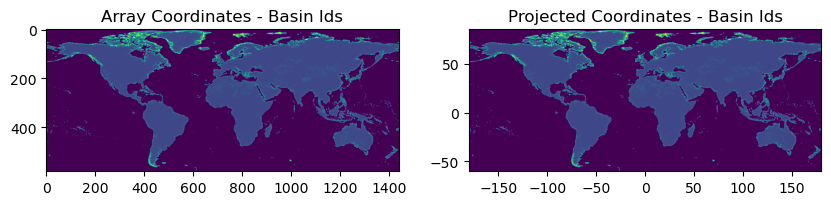

In [17]:
f,ax = plt.subplots(1,2, figsize=(10,4))
m1 = ax[0].imshow(basin_raster)
ax[0].set_title('Array Coordinates - Basin Ids')
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
m2 = ax[1].imshow(basin_raster, extent=full_extent)
ax[1].set_title('Projected Coordinates - Basin Ids')
# plt.colorbar(m2, ax=ax[1])
plt.show()

## Figure: Fraction remaining in each basin

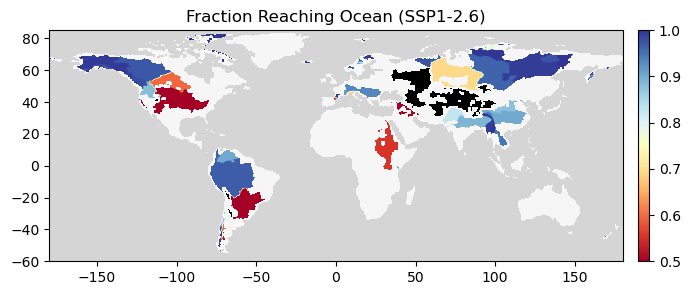

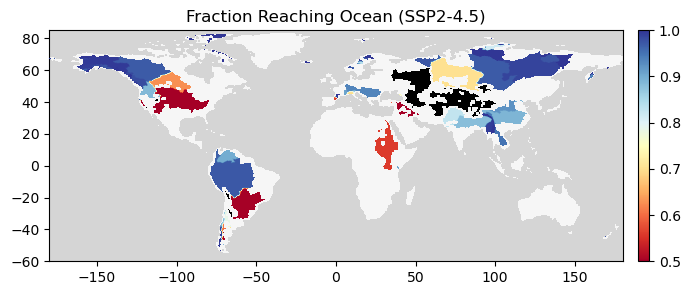

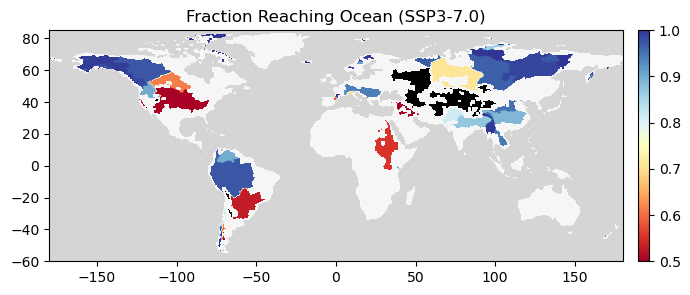

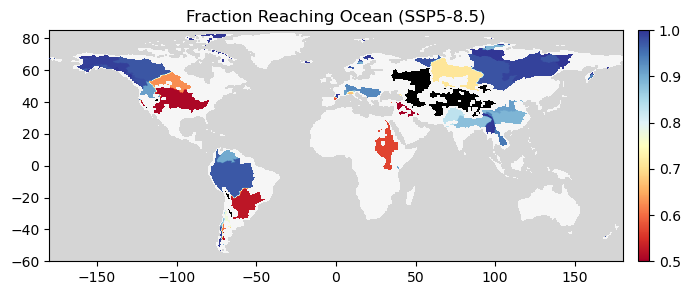

In [18]:
ignore_greenland = True

for nscenario, scenario in enumerate(scenarios):
    # Exorheic glaciated basins
    basin_raster_frac_exor = np.zeros(basin_raster.shape)
    basin_raster_frac_exor[:,:] = np.nan
    # Endorheic glaciated basins
    basin_raster_frac_endo = np.zeros(basin_raster.shape)
    basin_raster_frac_endo[:,:] = np.nan
    # Non-glaciated basins
    basin_raster_noglac = np.zeros(basin_raster.shape)
    basin_raster_noglac[:,:] = np.nan
    basin_raster_noglac[basin_raster > -9999] = 0
    if ignore_greenland:
        for id in basin_ids_greenland:
            basin_raster_noglac[basin_raster == id] = 0
    # Oceans
    basin_raster_ocean = np.zeros(basin_raster.shape)
    basin_raster_ocean[:,:] = 0
    # basin_raster_ocean[basin_raster == -9999] = 0
    
    # ----- Uncommon Basins (i.e., PyGEM but no WBM) -----
    basin_ids_uncommon = list(ds_slr.basin_ids_uncommon.values)
    for id in basin_ids_uncommon:
        if ignore_greenland:
            if not id in basin_ids_greenland:
                basin_raster_frac_exor[basin_raster == id] = 1
        else:
            basin_raster_frac_exor[basin_raster == id] = 1
    
    # ----- Common Basins (Endorheic and Exorheic) -----
    basin_ids_common = ds_slr.basin_ids_common.values
    endo_flag = ds_slr.endo_flag.values
    slr_mmSLE_common = ds_slr.slr_mmSLE_common.values[nscenario,:,:,:]
    slr_mmSLE_common_raw = ds_slr.slr_mmSLE_common_raw.values[nscenario,:,:,:]
    
    # -- Endorheic --
    endo_idx = np.where(endo_flag == 1)[0]
    slr_mmSLE_endo_raw = slr_mmSLE_common_raw[:, endo_idx, :]
    slr_mmSLE_endo_raw_cumsum = np.cumsum(slr_mmSLE_endo_raw, axis=2)
    slr_mmSLE_endo_raw_2015_2100 = slr_mmSLE_endo_raw_cumsum[:,:,-1]
    
    basin_ids_common_endo = basin_ids_common[endo_idx]
    for id in basin_ids_common_endo:
        basin_raster_frac_endo[basin_raster == id] = 0
    
    
    # -- Exorheic --
    exor_idx = np.where(endo_flag == 0)[0]
    basin_ids_common_exor = basin_ids_common[exor_idx]
    # slr adjusted for downstream hydrology
    slr_mmSLE_exor = slr_mmSLE_common[:, exor_idx, :]
    slr_mmSLE_exor_cumsum = np.cumsum(slr_mmSLE_exor, axis=2)
    slr_mmSLE_exor_2015_2100 = slr_mmSLE_exor_cumsum[:,:,-1]
    # slr unadjusted for downstream hydrology (assuming 100% contribution)
    slr_mmSLE_exor_raw = slr_mmSLE_common_raw[:, exor_idx, :]
    slr_mmSLE_exor_raw_cumsum = np.cumsum(slr_mmSLE_exor_raw, axis=2)
    slr_mmSLE_exor_raw_2015_2100 = slr_mmSLE_exor_raw_cumsum[:,:,-1]
    # Fraction remaining
    slr_2015_2100_frac_remaining_exor = slr_mmSLE_exor_2015_2100 / slr_mmSLE_exor_raw_2015_2100
    slr_2015_2100_frac_remaining_exor_mean = slr_2015_2100_frac_remaining_exor.mean(0)

    basin_ids_common_exor = basin_ids_common[exor_idx]
    for nid, id in enumerate(basin_ids_common_exor):
        basin_raster_frac_exor[basin_raster == id] = slr_2015_2100_frac_remaining_exor_mean[nid]
            
    # ----- PLOT OF FRACTION REMAINING -----
    plot_frac_min = 0.5
    plot_frac_max = 1
    cmap_frac = 'RdYlBu'
    # cmap_frac = 'Spectral'
    full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                          gridspec_kw={'wspace':0.5, 'hspace':0.3})
    # exorheic basins (colored by fraction that reaches the ocean)
    pcm = ax[0,0].imshow(basin_raster_frac_exor, vmin=plot_frac_min, vmax=plot_frac_max, cmap=cmap_frac, zorder=4, extent=full_extent)
    # endorheic basins (dark grey)
    pcm2 = ax[0,0].imshow(basin_raster_frac_endo, vmin=0, vmax=1, cmap='gray', zorder=3, extent=full_extent)
    # non-glaciated basin (light grey)
    pcm3 = ax[0,0].imshow(basin_raster_noglac, vmin=-1, vmax=1, cmap='RdBu', zorder=2, extent=full_extent)
    # ocean (blue)
    # pcm4 = ax[0,0].imshow(basin_raster_ocean, vmin=-0.15, vmax=0.2, cmap='coolwarm', zorder=1, extent=full_extent)
    pcm4 = ax[0,0].imshow(basin_raster_ocean, vmin=-0.2, vmax=1, cmap='binary', zorder=1, extent=full_extent)
    
    # Divide existing axes and create
    # new axes at right side of image
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes("right", size="2%", pad=0.15)
    # cb = fig.colorbar(pcm, fraction=0.047*height_in/width_in, pad=0.04)
    cb = fig.colorbar(pcm, cax=cax)

    # Title
    ax[0,0].set_title('Fraction Reaching Ocean (' + ssp_name_dict[scenario] + ')')
    
    fig.set_size_inches(8,3)
    
    fig_fp = results_fp + '_figures/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig.savefig(fig_fp + 'globe_basins_frac2ocean_' + scenario + '.png', dpi=500)
    
    plt.show()

## Figure: Fraction remaining in each RGI region

#### Fraction remaining dictionary

In [19]:
years_slr = ds_slr.year.values

basin_frac_remaining_dict = {}
for nscenario, scenario in enumerate(scenarios):
    basin_frac_remaining_dict[scenario] = {}
    
for nscenario, scenario in enumerate(scenarios):
    # -- Uncommon basins --
    for id in list(ds_slr.basin_ids_uncommon.values):
        basin_frac_remaining_dict[scenario][id] = np.zeros((len(gcm_names),years_slr.shape[0]))+1

    # -- Common Basins (Endorheic and Exorheic) --
    basin_ids_common = ds_slr.basin_ids_common.values
    endo_flag = ds_slr.endo_flag.values
    slr_mmSLE_common = ds_slr.slr_mmSLE_common.values[nscenario,:,:,:]
    slr_mmSLE_common_raw = ds_slr.slr_mmSLE_common_raw.values[nscenario,:,:,:]
    
    # -- Endorheic --
    basin_ids_common_endo = basin_ids_common[endo_idx]
    for id in basin_ids_common_endo:
        basin_frac_remaining_dict[scenario][id] = np.zeros((len(gcm_names),years_slr.shape[0]))
    
    # -- Exorheic --
    exor_idx = np.where(endo_flag == 0)[0]
    basin_ids_common_exor = basin_ids_common[exor_idx]
    
    # slr adjusted for downstream hydrology
    slr_mmSLE_exor = slr_mmSLE_common[:, exor_idx, :]
    # slr_mmSLE_exor_cumsum = np.cumsum(slr_mmSLE_exor, axis=2)
    # slr_mmSLE_exor_2015_2100 = slr_mmSLE_exor_cumsum[:,:,-1]
    
    # slr unadjusted for downstream hydrology (assuming 100% contribution)
    slr_mmSLE_exor_raw = slr_mmSLE_common_raw[:, exor_idx, :]
    # slr_mmSLE_exor_raw_cumsum = np.cumsum(slr_mmSLE_exor_raw, axis=2)
    # slr_mmSLE_exor_raw_2015_2100 = slr_mmSLE_exor_raw_cumsum[:,:,-1]
    
    # Fraction remaining
    slr_frac_remaining_exor = np.zeros(slr_mmSLE_exor.shape)+1
    slr_frac_remaining_exor[slr_mmSLE_exor_raw > 0] = slr_mmSLE_exor[slr_mmSLE_exor_raw > 0] / slr_mmSLE_exor_raw[slr_mmSLE_exor_raw > 0]
    # slr_2015_2100_frac_remaining_exor = slr_mmSLE_exor_2015_2100 / slr_mmSLE_exor_raw_2015_2100

    # Loop through basins
    for nid, id in enumerate(basin_ids_common_exor):
        basin_frac_remaining_dict[scenario][id] = slr_frac_remaining_exor[:,nid,:]

#### Modify Sea Level Contribution from Each Glacier by Region

In [20]:
print('Fraction remaining by region:')
print(' - uses annual value for each GCM of water that reaches the ocean in each basin based on the exor_frac_option')
print('\nSea Level Contribution from 2015-2100 (mmSLE)')
      
# Load and aggregate data
regions = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

reg_annual_frac_dict = {}
reg_annual_slr_mmSLE_dict = {}
reg_annual_slr_mmSLE_raw_dict = {}
for scenario in scenarios:
    reg_annual_frac_dict[scenario] = {}
    reg_annual_slr_mmSLE_dict[scenario] = {}
    reg_annual_slr_mmSLE_raw_dict[scenario] = {}
    
    print('\n',scenario)
    global_slr_mmSLE = None
    global_slr_mmSLE_raw = None
    for reg in regions:

        # ----- LOAD DATA -----
        # Load mass annual and mass below sea level data
        fp_reg_mass = pygem_output_fp + 'mass_annual/' + str(reg).zfill(2) + '/'
        fn_reg_mass = 'R' + str(reg).zfill(2) + '_glac_mass_annual_c2_ba1_50sets_2000_2100-' + scenario + '.nc'
        ds_mass = xr.open_dataset(fp_reg_mass + fn_reg_mass)

        fp_reg_mass_bsl = pygem_output_fp + 'mass_bsl_annual/' + str(reg).zfill(2) + '/'
        fn_reg_mass_bsl = 'R' + str(reg).zfill(2) + '_glac_mass_bsl_annual_c2_ba1_50sets_2000_2100-' + scenario + '.nc'
        ds_mass_bsl = xr.open_dataset(fp_reg_mass_bsl + fn_reg_mass_bsl)
        
        mass_annual = ds_mass['glac_mass_annual'].values
        mass_bsl_annual = ds_mass_bsl['glac_mass_bsl_annual'].values

        
        # Identify tidewater glaciers for bsl correction
        rgiids_raw = list(ds_mass.RGIId.values)
        glacno_list = [x.split('-')[1] for x in rgiids_raw]
        # Add trailing zero to ensure RGIIds are appropriate
        if reg < 10:
            rgiids = ['RGI60-0' + x for x in glacno_list]
        else:
            rgiids = ['RGI60-' + x for x in glacno_list]
            
        if reg in list(nontw_idx_dict.keys()):
            nontw_idx = nontw_idx_dict[reg]
        else:
            main_glac_rgi_reg = selectglaciersrgitable(glac_no=glacno_list)
            if main_glac_rgi_reg.TermType.sum() == 0:
                tw_idx = []
            else:
                tw_idx = np.where((main_glac_rgi_reg.TermType.values == 1) | (main_glac_rgi_reg.TermType.values == 5))[0]
                if len(tw_idx) == 0:
                    tw_idx = []
            nontw_idx = [x for x in main_glac_rgi_reg.index.values if x not in tw_idx]
            nontw_idx_dict[reg] = nontw_idx

        mass_bsl_annual[:,nontw_idx,:] = 0

        # ANNUAL SLE ESTIMATE
        vol_annual = mass_annual / 900
        vol_bsl_annual = mass_bsl_annual / 900
    
        glac_slr_mmSLE_raw = slr_mmSLEyr(vol_annual, vol_bsl_annual)

        # BASIN-BY-BASIN ADJUSTMENT
        rgi_df_wbasins = pd.read_csv(rgiids_wbasins_fn)
        group_dict = dict(zip(rgi_df_wbasins.RGIId, rgi_df_wbasins.MeritID))
        
        # loop through RGIIds
        glac_slr_mmSLE = np.zeros(glac_slr_mmSLE_raw.shape)
        for n_rgiid, rgiid in enumerate(rgiids):
            try:
                basin_id = group_dict[rgiid]
                glac_frac_remaining = basin_frac_remaining_dict[scenario][basin_id]
            except:
                glac_frac_remaining = np.zeros((len(gcm_names),years.shape[0]-1))+1

            single_glac_slr_mmSLE = glac_frac_remaining * glac_slr_mmSLE_raw[:,n_rgiid,:]
            glac_slr_mmSLE[:,n_rgiid,:] = single_glac_slr_mmSLE

        # STORE REGIONAL DATA
        reg_annual_slr_mmSLE_dict[scenario][reg] = glac_slr_mmSLE.sum(1)
        reg_annual_slr_mmSLE_raw_dict[scenario][reg] = glac_slr_mmSLE_raw.sum(1)
        reg_annual_frac_dict[scenario][reg] = glac_slr_mmSLE.sum(1) / glac_slr_mmSLE_raw.sum(1)
        
        # Aggregate globally
        if global_slr_mmSLE is None:
            global_slr_mmSLE = glac_slr_mmSLE.sum(1)
            global_slr_mmSLE_raw = glac_slr_mmSLE_raw.sum(1)
        else:
            global_slr_mmSLE = global_slr_mmSLE + glac_slr_mmSLE.sum(1)
            global_slr_mmSLE_raw = global_slr_mmSLE_raw + glac_slr_mmSLE_raw.sum(1)

    # STORE GLOBAL DATA
    reg_annual_slr_mmSLE_dict[scenario]['all'] = global_slr_mmSLE
    reg_annual_slr_mmSLE_raw_dict[scenario]['all'] = global_slr_mmSLE_raw 
    reg_annual_frac_dict[scenario]['all'] = global_slr_mmSLE / global_slr_mmSLE_raw

    print('   Raw (2015-2100 mmSLE):', int(np.round(np.median(global_slr_mmSLE_raw[:,16:].sum(1)))), 
          '+/-', int(np.round(1.96*np.std(global_slr_mmSLE_raw[:,16:].sum(1))))) 
    print('   Adj (2015-2100 mmSLE):', int(np.round(np.median(global_slr_mmSLE[:,16:].sum(1)))), 
          '+/-', int(np.round(1.96*np.std(global_slr_mmSLE[:,16:].sum(1)))))

Fraction remaining by region:
 - uses annual value for each GCM of water that reaches the ocean in each basin based on the exor_frac_option

Sea Level Contribution from 2015-2100 (mmSLE)

 ssp126
   Raw (2015-2100 mmSLE): 98 +/- 38
   Adj (2015-2100 mmSLE): 94 +/- 37

 ssp245
   Raw (2015-2100 mmSLE): 116 +/- 51
   Adj (2015-2100 mmSLE): 111 +/- 51

 ssp370
   Raw (2015-2100 mmSLE): 147 +/- 64
   Adj (2015-2100 mmSLE): 141 +/- 63

 ssp585
   Raw (2015-2100 mmSLE): 166 +/- 83
   Adj (2015-2100 mmSLE): 159 +/- 82


 - uses annual value for each GCM of water that reaches the ocean in each basin based on the exor_frac_option


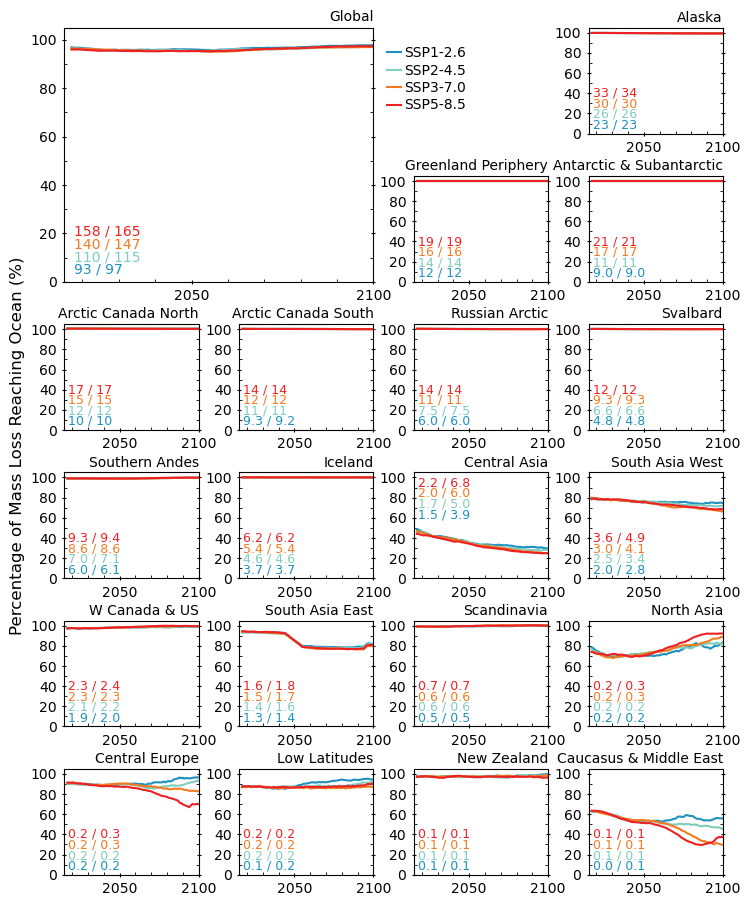

In [21]:
#%% ----- FIGURE: CUMULATIVE SEA-LEVEL RISE REGIONAL -----
print(' - uses annual value for each GCM of water that reaches the ocean in each basin based on the exor_frac_option')

years = ds_mass.year.values

scenario_colordict = {'ssp119':'#081d58', 'ssp126':'#1d91c0', 'ssp245':'#7fcdbb', 'ssp370':'#F47A20', 'ssp585':'#ED2024'}

fig = plt.figure()
gs = fig.add_gridspec(nrows=6,ncols=4,wspace=0.3,hspace=0.4)
ax1 = fig.add_subplot(gs[0:2,0:2])
ax2 = fig.add_subplot(gs[0,3])
ax3 = fig.add_subplot(gs[1,2])
ax4 = fig.add_subplot(gs[1,3])
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])
ax7 = fig.add_subplot(gs[2,2])
ax8 = fig.add_subplot(gs[2,3])
ax9 = fig.add_subplot(gs[3,0])
ax10 = fig.add_subplot(gs[3,1])
ax11 = fig.add_subplot(gs[3,2])
ax12 = fig.add_subplot(gs[3,3])
ax13 = fig.add_subplot(gs[4,0])
ax14 = fig.add_subplot(gs[4,1])
ax15 = fig.add_subplot(gs[4,2])
ax16 = fig.add_subplot(gs[4,3])
ax17 = fig.add_subplot(gs[5,0])
ax18 = fig.add_subplot(gs[5,1])
ax19 = fig.add_subplot(gs[5,2])
ax20 = fig.add_subplot(gs[5,3])

regions_ordered = ['all',1,5,19,3,4,9,7,17,6,13,14,2,15,8,10,11,16,18,12]
for nax, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20]):
    
    reg = regions_ordered[nax]          

    slr_max = 0
    for nscenario, scenario in enumerate(scenarios):
        # Time series of fraction reaching ocean
        reg_annual_frac = reg_annual_frac_dict[scenario][reg]
        reg_annual_frac_med = uniform_filter(np.median(reg_annual_frac[:,year_start_idx+1:], axis=0), size=(11)) 
        ax.plot(years[year_start_idx+1:-1], 100*reg_annual_frac_med, color=scenario_colordict[scenario])

        reg_annual_slr_mmSLE_raw_dict

        # Cumulative sea level contribution in text
        reg_slr_mmSLE = reg_annual_slr_mmSLE_dict[scenario][reg]
        reg_slr_mmSLE_2015_2100_med = np.median(reg_slr_mmSLE[:,year_start_idx+1:].sum(1),axis=0)
        if reg_slr_mmSLE_2015_2100_med < 10:
            slr_text = str(np.round(reg_slr_mmSLE_2015_2100_med,1))
        else:
            slr_text = str(int(np.round(reg_slr_mmSLE_2015_2100_med,0)))
        
        # if nax==0:
        #     ax.text(0.03, 0.02+nscenario*0.05, slr_text, color=scenario_colordict[scenario], size=10, 
        #             horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        # else:
        #     ax.text(0.03, 0.02+nscenario*0.1, slr_text, color=scenario_colordict[scenario], size=9, 
        #             horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

        # Add raw number next to it too
        reg_slr_mmSLE_raw = reg_annual_slr_mmSLE_raw_dict[scenario][reg]
        reg_slr_mmSLE_raw_2015_2100_med = np.median(reg_slr_mmSLE_raw[:,year_start_idx+1:].sum(1),axis=0)
        if reg_slr_mmSLE_2015_2100_med < 10:
            slr_text = slr_text + ' / ' + str(np.round(reg_slr_mmSLE_raw_2015_2100_med,1))
        else:
            slr_text = slr_text + ' / ' + str(int(np.round(reg_slr_mmSLE_raw_2015_2100_med,0)))

        if not reg in [13]:
            yadj = 0
        else:
            yadj=0.52
        if nax==0:
            ax.text(0.03, yadj+0.02+nscenario*0.05, slr_text, color=scenario_colordict[scenario], size=10, 
                    horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        else:
            ax.text(0.03, yadj+0.02+nscenario*0.1, slr_text, color=scenario_colordict[scenario], size=9, 
                    horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

    ax.set_xlim(2015,2100)
    ax.xaxis.set_major_locator(MultipleLocator(50))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
        
    ax.set_ylim(0,105)
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    ax.tick_params(axis='both', which='major', direction='inout', right=True)
    ax.tick_params(axis='both', which='minor', direction='in', right=True)
    
    if nax == 0:
        label_height=1.07
    else:
        label_height=1.16
    ax.text(1, label_height, rgi_reg_dict[reg], size=10, horizontalalignment='right', 
            verticalalignment='top', transform=ax.transAxes)

    if nax == 1:
        labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
        ax.legend(loc=(-1.5,0.2), labels=labels, fontsize=10, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                  handlelength=1, handletextpad=0.25, borderpad=0, frameon=False
                  )
fig.text(0.07,0.5,'Percentage of Mass Loss Reaching Ocean (%)', size=12, horizontalalignment='center', verticalalignment='center', rotation=90)

# Save figure
fig_fn = 'FigS2_RGI_Regions-Percent_Reach_Ocean.png'
fig_fp = results_fp + '_figures/'
if not os.path.exists(fig_fp):
    os.makedirs(fig_fp)
fig.set_size_inches(8.5,11)
fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

## Global figure: time series of glacier runoff and discharge
Exclude Greenland

In [22]:
# Basin database (including interbasin transfers) prepared by Stanley Gliddon 8/14/2024
df_basins = pd.read_csv('MERIT_plus_15min_v1_IDs_super.csv')
df_basin_ids = list(df_basins.ID.values)
basin_ids_greenland = list(df_basins.loc[df_basins['SubContinentName'] == 'Greenland', 'ID'].values)

global_cns = ['qpg_m3s_2016_2035_mean', 'qpg_m3s_2016_2035_median', 'qpg_m3s_2016_2035_std', 
              'qpg_m3s_2080_2099_mean', 'qpg_m3s_2080_2099_median', 'qpg_m3s_2080_2099_std', 
              'glmelt_m3s_2016_2035_mean', 'glmelt_m3s_2016_2035_median', 'glmelt_m3s_2016_2035_std', 
              'glmelt_m3s_2080_2099_mean', 'glmelt_m3s_2080_2099_median', 'glmelt_m3s_2080_2099_std', 'glmelt_m3s_2080_2099_95',
              'glmelt_endo_m3s_2016_2035_mean', 'glmelt_endo_m3s_2016_2035_median', 'glmelt_endo_m3s_2016_2035_std', 
              'glmelt_endo_m3s_2080_2099_mean', 'glmelt_endo_m3s_2080_2099_median', 'glmelt_endo_m3s_2080_2099_std', 
              'frac_2016_2035_mean', 'frac_2016_2035_median', 'frac_2016_2035_std', 
              'frac_2080_2099_mean', 'frac_2080_2099_median', 'frac_2080_2099_std', 'frac_2080_2099_95',
              'SLR_mmsle_raw_2015_2100_mean', 'SLR_mmsle_raw_2015_2100_median', 'SLR_mmsle_raw_2015_2100_std', 
              'SLR_mmsle_raw_2015_2100_95', 'SLR_mmsle_raw_2015_2100_min', 'SLR_mmsle_raw_2015_2100_max',
              'SLR_mmsle_2015_2100_mean', 'SLR_mmsle_2015_2100_median', 'SLR_mmsle_2015_2100_std', 
              'SLR_mmsle_2015_2100_95', 'SLR_mmsle_2015_2100_min', 'SLR_mmsle_2015_2100_max',
              'SLR_mmsle_2015_2100_correction_mean', 'SLR_mmsle_2015_2100_correction_median', 'SLR_mmsle_2015_2100_correction_std', 'SLR_mmsle_2015_2100_correction_95',
              'SLR_mmsle_2015_2100_correction_perc_mean', 'SLR_mmsle_2015_2100_correction_perc_median', 'SLR_mmsle_2015_2100_correction_perc_std', 
              'SLR_mmsle_2015_2100_correction_perc_95']

global_df = pd.DataFrame(np.zeros((len(scenarios), len(global_cns))), columns=global_cns, index=scenarios)

print(global_cns)

for nscenario, scenario in enumerate(scenarios):
    print(scenario)

    basin_ids_all = []
    uncommon_basin_ids_all = []
    common_basin_ids_all = []

    # ----- Load Data -----
    ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
    ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
    ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)

    # ds_pygem_fp = 'pygem_processed/basin_data/'
    # ds_pygem_fn = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-common.nc'
    # ds_pygem = xr.open_dataset(ds_pygem_fp + ds_pygem_fn)

    # ds_pygem_fn_uncommon = 'pygem_' + scenario + '_2000_2100-basin_annual-wibt-uncommon-w19.nc'
    # ds_pygem_uncommon = xr.open_dataset(ds_pygem_fp + ds_pygem_fn_uncommon)

    # Select non-greenland data and non-greenland + exorheic data
    wbm_ids = list(ds_wbm.basin_ids.values)
    wbm_ids_init = [int(x.split('-')[0]) for x in wbm_ids]
    basin_ids_all = list(df_basins['ID'].values)
    
    wbm_ids_init_idx = [basin_ids_all.index(x) for x in wbm_ids_init]
    
    df_basins_wbm = df_basins.loc[wbm_ids_init_idx,:]
    df_basins_wbm.reset_index(inplace=True, drop=True)
    basin_ids_greenland = df_basins_wbm.loc[df_basins_wbm['SubContinentName'] == 'Greenland', 'ID'].values
    
    basin_ids_nogreenland = []
    basin_ids_nogreenland_exor = []
    basin_ids_nogreenland_endo = []
    for nbasin, basin_id in enumerate(wbm_ids_init):
        if not basin_id in basin_ids_greenland:
            basin_ids_nogreenland.append(basin_id)

            if df_basins_wbm.loc[nbasin, 'Endorheic'] == 0:
                basin_ids_nogreenland_exor.append(basin_id)
            else:
                basin_ids_nogreenland_endo.append(basin_id)
    
    basin_ids_nogreenland_idx = [wbm_ids_init.index(x) for x in basin_ids_nogreenland]
    basin_ids_nogreenland_exor_idx = [wbm_ids_init.index(x) for x in basin_ids_nogreenland_exor]
    basin_ids_nogreenland_endo_idx = [wbm_ids_init.index(x) for x in basin_ids_nogreenland_endo]

    # Values of interest
    glmelt = ds_wbm.glmelt.values
    q_pg = ds_wbm.discharge_pg.values

    # REMOVE GREENLAND
    # Glacier melt can be summed
    glmelt_nogreenland = glmelt[:,basin_ids_nogreenland_idx,:].sum(1)
    glmelt_nogreenland_endo = glmelt[:,basin_ids_nogreenland_endo_idx,:].sum(1)
    
    # ENDORHEIC BASIN ADJUSTED
    # - reaching ocean must account for endorheic basins
    q_pg_nogreenland_exor = q_pg[:,basin_ids_nogreenland_exor_idx,:].sum(1)
    
    # FRACTION REACHING OCEAN
    frac_ocean_nogreenland = 100 * q_pg_nogreenland_exor / glmelt_nogreenland

    # GLOBAL SEA-LEVEL RISE
    global_slr_mmSLE = reg_annual_slr_mmSLE_dict[scenario]['all']
    global_slr_mmSLE_raw = reg_annual_slr_mmSLE_raw_dict[scenario]['all']
    
    years_mass = ds_mass.year.values
    years_mass_start_idx = np.where(years_mass == 2016)[0][0]
    years_slr = years_mass[years_mass_start_idx:-1]
    
    global_slr_mmSLE_2015_2100 = np.sum(global_slr_mmSLE[:,years_mass_start_idx:], axis=1)
    global_slr_mmSLE_raw_2015_2100 = np.sum(global_slr_mmSLE_raw[:,years_mass_start_idx:], axis=1)

    # ----- CSV data -----
    years = ds_wbm.year.values
    year_start = 2016
    year_end = 2035
    year_idx_start = np.where(years == year_start)[0][0]
    year_idx_end = np.where(years == year_end)[0][0]

    glmelt_subset = glmelt_nogreenland[:,year_idx_start:year_idx_end+1]
    glmelt_endo_subset = glmelt_nogreenland_endo[:,year_idx_start:year_idx_end+1]
    q_pg_subset = q_pg_nogreenland_exor[:,year_idx_start:year_idx_end+1]
    frac_ocean_subset = frac_ocean_nogreenland[:,year_idx_start:year_idx_end+1]

    global_df.loc[scenario, 'qpg_m3s_2016_2035_mean'] = np.mean(np.mean(q_pg_subset,axis=0))
    global_df.loc[scenario, 'qpg_m3s_2016_2035_median'] = np.median(np.mean(q_pg_subset,axis=0))
    global_df.loc[scenario, 'qpg_m3s_2016_2035_std'] = np.std(np.mean(q_pg_subset,axis=0))
    global_df.loc[scenario, 'glmelt_m3s_2016_2035_mean'] = np.mean(np.mean(glmelt_subset,axis=0))
    global_df.loc[scenario, 'glmelt_m3s_2016_2035_median'] = np.median(np.mean(glmelt_subset,axis=0))
    global_df.loc[scenario, 'glmelt_m3s_2016_2035_std'] = np.std(np.mean(glmelt_subset,axis=0))
    global_df.loc[scenario, 'glmelt_endo_m3s_2016_2035_mean'] = np.mean(np.mean(glmelt_endo_subset,axis=0))
    global_df.loc[scenario, 'glmelt_endo_m3s_2016_2035_median'] = np.median(np.mean(glmelt_endo_subset,axis=0))
    global_df.loc[scenario, 'glmelt_endo_m3s_2016_2035_std'] = np.std(np.mean(glmelt_endo_subset,axis=0))
    global_df.loc[scenario, 'frac_2016_2035_mean'] = np.mean(np.mean(frac_ocean_subset,axis=0))
    global_df.loc[scenario, 'frac_2016_2035_median'] = np.median(np.mean(frac_ocean_subset,axis=0))
    global_df.loc[scenario, 'frac_2016_2035_std'] = np.std(np.mean(frac_ocean_subset,axis=0))

    
    year_start = 2080
    year_end = 2099
    year_idx_start = np.where(years == year_start)[0][0]
    year_idx_end = np.where(years == year_end)[0][0]

    glmelt_subset = glmelt_nogreenland[:,year_idx_start:year_idx_end+1]
    glmelt_endo_subset = glmelt_nogreenland_endo[:,year_idx_start:year_idx_end+1]
    q_pg_subset = q_pg_nogreenland_exor[:,year_idx_start:year_idx_end+1]
    frac_ocean_subset = frac_ocean_nogreenland[:,year_idx_start:year_idx_end+1]

    global_df.loc[scenario, 'qpg_m3s_2080_2099_mean'] = np.mean(np.mean(q_pg_subset,axis=0))
    global_df.loc[scenario, 'qpg_m3s_2080_2099_median'] = np.median(np.mean(q_pg_subset,axis=0))
    global_df.loc[scenario, 'qpg_m3s_2080_2099_std'] = np.std(np.mean(q_pg_subset,axis=0))
    global_df.loc[scenario, 'glmelt_m3s_2080_2099_mean'] = np.mean(np.mean(glmelt_subset,axis=0))
    global_df.loc[scenario, 'glmelt_m3s_2080_2099_median'] = np.median(np.mean(glmelt_subset,axis=0))
    global_df.loc[scenario, 'glmelt_m3s_2080_2099_std'] = np.std(np.mean(glmelt_subset,axis=0))
    global_df.loc[scenario, 'glmelt_m3s_2080_2099_95'] = 1.96*np.std(np.mean(glmelt_subset,axis=0))
    global_df.loc[scenario, 'glmelt_endo_m3s_2080_2099_mean'] = np.mean(np.mean(glmelt_endo_subset,axis=0))
    global_df.loc[scenario, 'glmelt_endo_m3s_2080_2099_median'] = np.median(np.mean(glmelt_endo_subset,axis=0))
    global_df.loc[scenario, 'glmelt_endo_m3s_2080_2099_std'] = np.std(np.mean(glmelt_endo_subset,axis=0))
    global_df.loc[scenario, 'frac_2080_2099_mean'] = np.mean(np.mean(frac_ocean_subset,axis=0))
    global_df.loc[scenario, 'frac_2080_2099_median'] = np.median(np.mean(frac_ocean_subset,axis=0))
    global_df.loc[scenario, 'frac_2080_2099_std'] = np.std(np.mean(frac_ocean_subset,axis=0))
    global_df.loc[scenario, 'frac_2080_2099_95'] = 1.96*np.std(np.mean(frac_ocean_subset,axis=0))

    global_df.loc[scenario,'SLR_mmsle_raw_2015_2100_mean'] = np.mean(global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_raw_2015_2100_median'] = np.median(global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_raw_2015_2100_std'] = np.std(global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_raw_2015_2100_95'] = 1.96*np.std(global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_raw_2015_2100_min'] = np.min(global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_raw_2015_2100_max'] = np.max(global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_mean'] = np.mean(global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_median'] = np.median(global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_std'] = np.std(global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_95'] = 1.96*np.std(global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_min'] = np.min(global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_max'] = np.max(global_slr_mmSLE_2015_2100)

    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_mean'] = np.mean(global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_median'] = np.median(global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_std'] = np.std(global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_95'] = 1.96*np.std(global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100)

    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_perc_mean'] = np.mean(
        100 * (global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100) / global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_perc_median'] = np.median(
        100 * (global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100) / global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_perc_std'] = np.std(
        100 * (global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100) / global_slr_mmSLE_raw_2015_2100)
    global_df.loc[scenario,'SLR_mmsle_2015_2100_correction_perc_95'] = 1.96*np.std(
        100 * (global_slr_mmSLE_raw_2015_2100 - global_slr_mmSLE_2015_2100) / global_slr_mmSLE_raw_2015_2100)
    
    
# global_cns = []
# for cn in global_cns_pre:
#     for scenario in scenarios:
#         global_cns.append(cn + '-' + scenario)

global_df.to_csv(results_fp + 'global_discharge_stats_no5-19.csv')

['qpg_m3s_2016_2035_mean', 'qpg_m3s_2016_2035_median', 'qpg_m3s_2016_2035_std', 'qpg_m3s_2080_2099_mean', 'qpg_m3s_2080_2099_median', 'qpg_m3s_2080_2099_std', 'glmelt_m3s_2016_2035_mean', 'glmelt_m3s_2016_2035_median', 'glmelt_m3s_2016_2035_std', 'glmelt_m3s_2080_2099_mean', 'glmelt_m3s_2080_2099_median', 'glmelt_m3s_2080_2099_std', 'glmelt_m3s_2080_2099_95', 'glmelt_endo_m3s_2016_2035_mean', 'glmelt_endo_m3s_2016_2035_median', 'glmelt_endo_m3s_2016_2035_std', 'glmelt_endo_m3s_2080_2099_mean', 'glmelt_endo_m3s_2080_2099_median', 'glmelt_endo_m3s_2080_2099_std', 'frac_2016_2035_mean', 'frac_2016_2035_median', 'frac_2016_2035_std', 'frac_2080_2099_mean', 'frac_2080_2099_median', 'frac_2080_2099_std', 'frac_2080_2099_95', 'SLR_mmsle_raw_2015_2100_mean', 'SLR_mmsle_raw_2015_2100_median', 'SLR_mmsle_raw_2015_2100_std', 'SLR_mmsle_raw_2015_2100_95', 'SLR_mmsle_raw_2015_2100_min', 'SLR_mmsle_raw_2015_2100_max', 'SLR_mmsle_2015_2100_mean', 'SLR_mmsle_2015_2100_median', 'SLR_mmsle_2015_2100_std

## Global Figure

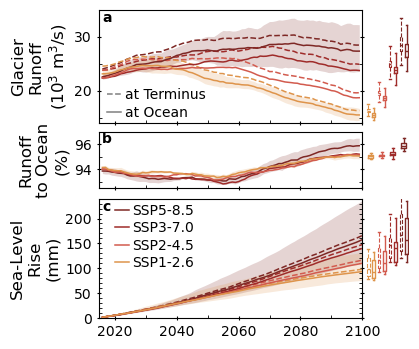

In [23]:
add_each_gcm = True
add_only_adjusted = True
add_fill_between = True
if add_fill_between:
    add_each_gcm = False
scenarios_uncertainty = ['ssp126', 'ssp585']
smooth_results = True
lw_main = 1.1
alpha_single = 0.5

fig = plt.figure()
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.07, height_ratios=[3,2])
gs0 = gs[0].subgridspec(2,2, height_ratios=[2,1], width_ratios=[6,1], wspace=0.02, hspace=0.1)
gs1 = gs[1].subgridspec(1,2, width_ratios=[6,1], wspace=0.02)

ax0 = fig.add_subplot(gs0[1,0])
ax0box = fig.add_subplot(gs0[1,1])
ax1 = fig.add_subplot(gs0[0,0])
ax1box = fig.add_subplot(gs0[0,1])
ax2 = fig.add_subplot(gs1[0,0])
ax2box = fig.add_subplot(gs1[0,1])

# Flip order
# fig = plt.figure()
# gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.07, height_ratios=[3,2])
# gs0 = gs[0].subgridspec(2,2, height_ratios=[1,2], width_ratios=[10,1], wspace=0.02, hspace=0.1)
# gs1 = gs[1].subgridspec(1,2, width_ratios=[10,1], wspace=0.02)

# ax0 = fig.add_subplot(gs0[0,0])
# ax0box = fig.add_subplot(gs0[0,1])
# ax1 = fig.add_subplot(gs0[1,0])
# ax1box = fig.add_subplot(gs0[1,1])
# ax2 = fig.add_subplot(gs1[0,0])
# ax2box = fig.add_subplot(gs1[0,1])

# ----- Load Data -----
data_boxplot_fraction = []
data_boxplot_qpg = []
data_boxplot_slr = []
for nscenario, scenario in enumerate(scenarios[::-1]):
    ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
    ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
    ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)
    
    basin_ids_nogreenland_idx = [wbm_ids_init.index(x) for x in basin_ids_nogreenland]
    basin_ids_nogreenland_exor_idx = [wbm_ids_init.index(x) for x in basin_ids_nogreenland_exor]
    basin_ids_nogreenland_endo_idx = [wbm_ids_init.index(x) for x in basin_ids_nogreenland_endo]
    
    # Values of interest
    glmelt = ds_wbm.glmelt.values
    q_pg = ds_wbm.discharge_pg.values
    
    glmelt_nogreenland = glmelt[:,basin_ids_nogreenland_idx,:].sum(1)
    q_pg_nogreenland_exor = q_pg[:,basin_ids_nogreenland_exor_idx,:].sum(1)
    frac_ocean_nogreenland = 100 * q_pg_nogreenland_exor / glmelt_nogreenland

    if smooth_results:
        glmelt_nogreenland = uniform_filter(glmelt_nogreenland, size=(11))
        q_pg_nogreenland_exor = uniform_filter(q_pg_nogreenland_exor, size=(11))
        frac_ocean_nogreenland = uniform_filter(frac_ocean_nogreenland, size=(11))

    data_boxplot_fraction.append(frac_ocean_nogreenland[:,-1])
    data_boxplot_qpg.append(q_pg_nogreenland_exor[:,-1] / 1e3)
    data_boxplot_qpg.append(glmelt_nogreenland[:,-1] / 1e3)
    
    years = ds_wbm.year.values
    glmelt_nogreenland_median = np.median(glmelt_nogreenland, axis=0)
    q_pg_nogreenland_exor_median = np.median(q_pg_nogreenland_exor,axis=0)
    frac_ocean_nogreenland_median = np.median(frac_ocean_nogreenland,axis=0)
    
    glmelt_nogreenland_std = np.std(glmelt_nogreenland, axis=0)
    q_pg_nogreenland_exor_std = np.std(q_pg_nogreenland_exor,axis=0)
    frac_ocean_nogreenland_std = np.std(frac_ocean_nogreenland,axis=0)
    glmelt_nogreenland_min = np.min(glmelt_nogreenland, axis=0)
    q_pg_nogreenland_exor_min = np.min(q_pg_nogreenland_exor,axis=0)
    frac_ocean_nogreenland_min = np.min(frac_ocean_nogreenland,axis=0)
    glmelt_nogreenland_max = np.max(glmelt_nogreenland, axis=0)
    q_pg_nogreenland_exor_max = np.max(q_pg_nogreenland_exor,axis=0)
    frac_ocean_nogreenland_max = np.max(frac_ocean_nogreenland,axis=0)

    
    # ----- FRACTION REACHING OCEAN -----
    ax0.plot(years, frac_ocean_nogreenland_median, color=ssp_colordict[scenario], lw=lw_main, zorder=2)
    if add_fill_between and scenario in scenarios_uncertainty:
        ax0.fill_between(years, frac_ocean_nogreenland_min, 
                         frac_ocean_nogreenland_max, 
                         color=ssp_colordict[scenario], alpha=0.2, lw=0)
        # ax0.fill_between(years, frac_ocean_nogreenland_median - 1.96*frac_ocean_nogreenland_std, 
        #                  frac_ocean_nogreenland_median + 1.96*frac_ocean_nogreenland_std, 
        #                  color=ssp_colordict[scenario], alpha=0.2, lw=0)
    elif add_each_gcm and scenario in scenarios_uncertainty:
        for ngcm, gcm in enumerate(gcm_names):
            frac_ocean_nogreenland_single = frac_ocean_nogreenland[ngcm,:]
            ax0.plot(years, frac_ocean_nogreenland_single, color=ssp_colordict[scenario], lw=0.5, alpha=alpha_single, zorder=1)
    ax0.set_ylabel('Runoff\nto Ocean\n(%)', size=12)
    ax0.yaxis.set_major_locator(MultipleLocator(2))
    ax0.yaxis.set_minor_locator(MultipleLocator(1))
    if smooth_results:
        frac_ylim_min, frac_ylim_max = 92.5, 97
        ax0.set_ylim(frac_ylim_min, frac_ylim_max)
    else:
        frac_ylim_min, frac_ylim_max = 90.01, 98
        ax0.set_ylim(frac_ylim_min, frac_ylim_max)
    ax0.set_xlim(2015,2100)
    ax0.xaxis.set_major_locator(MultipleLocator(20))
    ax0.xaxis.set_minor_locator(MultipleLocator(10))
    ax0.axes.xaxis.set_ticklabels([])
    ax0.tick_params(axis='both', which='major', direction='inout', right=True)
    ax0.tick_params(axis='both', which='minor', direction='in', right=True)

    if nscenario == 0:
        ax0.text(0.01, 0.99, 'b', fontsize=10, weight='bold', ha='left', va='top', transform=ax0.transAxes)
            
    # ----- DISCHARGE -----
    ax1.plot(years, glmelt_nogreenland_median / 1e3, color=ssp_colordict[scenario], 
             linestyle='--', linewidth=lw_main, zorder=2, label=None)
    ax1.plot(years, q_pg_nogreenland_exor_median / 1e3, color=ssp_colordict[scenario], 
             linestyle='-', linewidth=lw_main, zorder=3, label=None)
    if add_fill_between and scenario in scenarios_uncertainty:
        # ax1.fill_between(years, (q_pg_nogreenland_exor_median - 1.96*q_pg_nogreenland_exor_std) / 1e3, 
        #                  (q_pg_nogreenland_exor_median + 1.96*q_pg_nogreenland_exor_std) / 1e3, 
        #                  color=ssp_colordict[scenario], alpha=0.2, lw=0)
        ax1.fill_between(years, q_pg_nogreenland_exor_min / 1e3, 
                         q_pg_nogreenland_exor_max / 1e3, 
                         color=ssp_colordict[scenario], alpha=0.2, lw=0)
    elif add_each_gcm and scenario in scenarios_uncertainty:
        for ngcm, gcm in enumerate(gcm_names):
            q_pg_nogreenland_exor_single = q_pg_nogreenland_exor[ngcm,:]
            if not add_only_adjusted:
                glmelt_nogreenland_single = glmelt_nogreenland[ngcm,:]
            ax1.plot(years, q_pg_nogreenland_exor_single / 1e3, color=ssp_colordict[scenario], ls='-', lw=0.5, alpha=alpha_single, zorder=1)
            ax1.plot(years, glmelt_nogreenland_single / 1e3, color=ssp_colordict[scenario], ls='--', lw=0.5, alpha=alpha_single, zorder=1)
    ax1.set_ylabel('Glacier\nRunoff\n(10$^3$ m$^3$/s)', size=12)
    ax1.yaxis.set_major_locator(MultipleLocator(10))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    if smooth_results:
        q_ylim_min, q_ylim_max = 14, 35
        ax1.set_ylim(q_ylim_min, q_ylim_max)
    else:
        q_ylim_min, q_ylim_max = 11, 44
        ax1.set_ylim(q_ylim_min, q_ylim_max)
    ax1.set_xlim(2015,2100)
    ax1.xaxis.set_major_locator(MultipleLocator(20))
    ax1.xaxis.set_minor_locator(MultipleLocator(10))
    ax1.axes.xaxis.set_ticklabels([])

    if nscenario == 0:
        if add_each_gcm or add_fill_between:
            loc_legend = (0.03,0.03)
        else:
            loc_legend = (0.03,0.03)
        ax1b = ax1.twinx()
        ax1b.plot([0,0],[0,0], color='grey', linestyle='--', linewidth=lw_main, zorder=1, label='at Terminus')
        ax1b.plot([0,0],[0,0], color='grey', linestyle='-', linewidth=lw_main, zorder=1, label='at Ocean')
        ax1b.axes.get_yaxis().set_visible(False)
        ax1b.legend(loc=loc_legend, fontsize=10, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                   handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)
        ax1b.set_axis_off()
        
        ax1.tick_params(axis='both', which='major', direction='inout', right=True)
        ax1.tick_params(axis='both', which='minor', direction='in', right=True)
    
        ax1.text(0.01, 0.99, 'a', fontsize=10, weight='bold', ha='left', va='top', transform=ax1.transAxes)

# ----- Sea Level Contribution -----
for scenario in scenarios[::-1]:

    # ----- PROCESSING -----
    nscenario = list(ds_slr.scenarios.values).index(scenario)
    
    # Uncommon (100% contributors)
    slr_mmSLE_uncommon_basins = ds_slr.slr_mmSLE_uncommon.values[nscenario,:,:,:]
    slr_mmSLE_uncommon_2015_2100_annual = slr_mmSLE_uncommon_basins.sum(1)[:,year_start_idx:]

    # Endorheic and Exorheic Basins
    # These basin are "common" (shared) between PyGEM and WBM
    slr_mmSLE_common = ds_slr.slr_mmSLE_common.values[nscenario,:,:,:]
    slr_mmSLE_common_raw = ds_slr.slr_mmSLE_common_raw.values[nscenario,:,:,:]
    endo_flag = ds_slr.endo_flag.values
    endo_idx = np.where(endo_flag == 1)[0]
    exor_idx = np.where(endo_flag == 0)[0]

    # -- ENDORHEIC Contributions --
    slr_mmSLE_endo_raw_basins = slr_mmSLE_common_raw[:, endo_idx, :]
    slr_mmSLE_endo_raw_2015_2100_annual = slr_mmSLE_endo_raw_basins.sum(1)[:,year_start_idx:]

    # -- EXORHEIC Contributions --
    slr_mmSLE_exor_basins = slr_mmSLE_common[:, exor_idx, :]
    slr_mmSLE_exor_2015_2100_annual = slr_mmSLE_exor_basins.sum(1)[:,year_start_idx:]

    slr_mmSLE_exor_raw_basins = slr_mmSLE_common_raw[:, exor_idx, :]
    slr_mmSLE_exor_raw_2015_2100_annual = slr_mmSLE_exor_raw_basins.sum(1)[:,year_start_idx:]
    
    # ----- TOTAL CONTRIBUTIONS-----
    # Adjusted total
    slr_mmSLE_total_2015_2100_annual = slr_mmSLE_uncommon_2015_2100_annual + slr_mmSLE_exor_2015_2100_annual

    # Unadjusted (Raw) total
    slr_mmSLE_raw_total_2015_2100_annual = (slr_mmSLE_uncommon_2015_2100_annual + slr_mmSLE_exor_raw_2015_2100_annual + 
                                            slr_mmSLE_endo_raw_2015_2100_annual)

    # Cumulative Sum
    global_slr_mmSLE_cumsum_2015_2100 = np.cumsum(slr_mmSLE_total_2015_2100_annual, axis=1)
    global_slr_mmSLE_raw_cumsum_2015_2100 = np.cumsum(slr_mmSLE_raw_total_2015_2100_annual, axis=1)
    
    # ----- END PROCESSING -----


    

    # global_slr_mmSLE = reg_annual_slr_mmSLE_dict[scenario]['all']
    # global_slr_mmSLE_raw = reg_annual_slr_mmSLE_raw_dict[scenario]['all']
    
    # years_mass = ds_mass.year.values
    # years_mass_start_idx = np.where(years_mass == 2015)[0][0]
    years_slr = years_mass[years_mass_start_idx:-1]
    
    # global_slr_mmSLE_cumsum_2015_2100 = np.cumsum(global_slr_mmSLE[:,years_mass_start_idx:], axis=1)
    # global_slr_mmSLE_raw_cumsum_2015_2100 = np.cumsum(global_slr_mmSLE_raw[:,years_mass_start_idx:], axis=1)

    data_boxplot_slr.append(global_slr_mmSLE_cumsum_2015_2100[:,-1])
    data_boxplot_slr.append(global_slr_mmSLE_raw_cumsum_2015_2100[:,-1])
    
    global_slr_mmSLE_cumsum_2015_2100_median = np.median(global_slr_mmSLE_cumsum_2015_2100, axis=0)
    global_slr_mmSLE_raw_cumsum_2015_2100_median = np.median(global_slr_mmSLE_raw_cumsum_2015_2100, axis=0)

    global_slr_mmSLE_cumsum_2015_2100_std = np.std(global_slr_mmSLE_cumsum_2015_2100, axis=0)
    global_slr_mmSLE_raw_cumsum_2015_2100_std = np.std(global_slr_mmSLE_raw_cumsum_2015_2100, axis=0)
    global_slr_mmSLE_cumsum_2015_2100_min = np.min(global_slr_mmSLE_cumsum_2015_2100, axis=0)
    global_slr_mmSLE_raw_cumsum_2015_2100_min = np.min(global_slr_mmSLE_raw_cumsum_2015_2100, axis=0)
    global_slr_mmSLE_cumsum_2015_2100_max = np.max(global_slr_mmSLE_cumsum_2015_2100, axis=0)
    global_slr_mmSLE_raw_cumsum_2015_2100_max = np.max(global_slr_mmSLE_raw_cumsum_2015_2100, axis=0)
    
    ax2.plot(years_mass[year_start_idx:-1], global_slr_mmSLE_cumsum_2015_2100_median, color=ssp_colordict[scenario], 
             linestyle='-', linewidth=lw_main, zorder=3, label=ssp_name_dict[scenario])
    ax2.plot(years_mass[year_start_idx:-1], global_slr_mmSLE_raw_cumsum_2015_2100_median, color=ssp_colordict[scenario], 
             linestyle='--',linewidth=lw_main, zorder=2)
    if add_fill_between and scenario in scenarios_uncertainty:
        ax2.fill_between(years_mass[year_start_idx:-1], global_slr_mmSLE_cumsum_2015_2100_min, 
                         global_slr_mmSLE_cumsum_2015_2100_max, 
                         color=ssp_colordict[scenario], alpha=0.2, lw=0)
        # ax2.fill_between(years_mass[year_start_idx:-1], global_slr_mmSLE_cumsum_2015_2100_median - 1.96*global_slr_mmSLE_cumsum_2015_2100_std, 
        #                  global_slr_mmSLE_cumsum_2015_2100_median + 1.96*global_slr_mmSLE_cumsum_2015_2100_std, 
        #                  color=ssp_colordict[scenario], alpha=0.2, lw=0)
    elif add_each_gcm and scenario in scenarios_uncertainty:
        for ngcm, gcm in enumerate(gcm_names):
            global_slr_mmSLE_cumsum_2015_2100_single = global_slr_mmSLE_cumsum_2015_2100[ngcm,:]
            global_slr_mmSLE_raw_cumsum_2015_2100_single = global_slr_mmSLE_raw_cumsum_2015_2100[ngcm,:]
            ax2.plot(years_mass[year_start_idx:-1], global_slr_mmSLE_cumsum_2015_2100_single, color=ssp_colordict[scenario], 
                     ls='-', lw=0.5, alpha=alpha_single, zorder=1)
            if not add_only_adjusted:
                ax2.plot(years_mass[year_start_idx:-1], global_slr_mmSLE_raw_cumsum_2015_2100_single, color=ssp_colordict[scenario], 
                         ls='--', lw=0.5, alpha=alpha_single, zorder=1)

# ax2b = ax2.twinx()
# ax2b.plot([0,0],[0,0], color='grey', linestyle='--', linewidth=lw_main, zorder=1, label='All (assumed)')
# ax2b.plot([0,0],[0,0], color='grey', linestyle='-', linewidth=lw_main, zorder=1, label='Direct only')
# ax2b.set_axis_off()
# ax2b.legend(loc=(0.38,0.69), fontsize=10, ncol=1, columnspacing=0.5, labelspacing=0.25, 
#            handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)

ax2.set_ylabel('Sea-Level\nRise\n(mm)', size=12)
slr_ylim_min, slr_ylim_max = 0, 240
ax2.set_ylim(slr_ylim_min, slr_ylim_max)
ax2.yaxis.set_major_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(10))
ax2.set_xlim(2015,2100)
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(MultipleLocator(10))
ax2.tick_params(axis='both', which='major', direction='inout', right=True)
ax2.tick_params(axis='both', which='minor', direction='in', right=True)
ax2.legend(loc=(0.06,0.40), fontsize=10, ncol=1, columnspacing=0.5, labelspacing=0.25, 
           handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)

ax2.text(0.01, 0.99, 'c', fontsize=10, weight='bold', ha='left', va='top', transform=ax2.transAxes)


# ----- BOX-AND-WHISKER PLOTS -----
# FRACTION REACHING OCEAN
lw_boxplot = 1
lw_adjust_value = 0.8
data_boxplot_fraction = data_boxplot_fraction[::-1]
bp = ax0box.boxplot(data_boxplot_fraction, whis=100)
ax0box.set_ylim(frac_ylim_min, frac_ylim_max)
for nbox, box in enumerate(bp['boxes']):
    scenario = scenarios[nbox]
    # change outline color
    box.set(color=ssp_colordict[scenario], linewidth=lw_boxplot)
for nitem, item in enumerate(bp['medians']):
    scenario = scenarios[nitem]
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_boxplot)
for nitem, item in enumerate(bp['whiskers']):
    scenario = scenarios[int(np.floor(nitem/2))]
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_boxplot)
for nitem, item in enumerate(bp['caps']):
    scenario = scenarios[int(np.floor(nitem/2))]
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_boxplot)
# turn off axes
ax0box.get_yaxis().set_visible(False)
ax0box.get_xaxis().set_visible(False)
ax0box.axis('off')

# DISCHARGE
data_boxplot_qpg = data_boxplot_qpg[::-1]
bp = ax1box.boxplot(data_boxplot_qpg, whis=100)
ax1box.set_ylim(q_ylim_min, q_ylim_max)
scenarios_q = list(np.repeat(scenarios,2))
for nbox, box in enumerate(bp['boxes']):
    scenario = scenarios_q[nbox]
    if nbox%2 == 0:
        ls_boxplot = '--'
        lw_adjust = lw_adjust_value 
    else:
        ls_boxplot = '-'
        lw_adjust = 1
    # change outline color
    box.set(color=ssp_colordict[scenario], linewidth=lw_adjust*lw_boxplot, ls=ls_boxplot)
for nitem, item in enumerate(bp['medians']):
    scenario = scenarios_q[nitem]
    ls_boxplot = '-'
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_boxplot, ls=ls_boxplot)
for nitem, item in enumerate(bp['whiskers']):
    scenario = scenarios_q[int(np.floor(nitem/2))]
    if int(np.floor(nitem/2))%2 == 0:
        ls_boxplot = '--'
        lw_adjust = lw_adjust_value 
    else:
        ls_boxplot = '-'
        lw_adjust = 1
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_adjust*lw_boxplot, ls=ls_boxplot)
for nitem, item in enumerate(bp['caps']):
    scenario = scenarios_q[int(np.floor(nitem/2))]
    ls_boxplot = '-'
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_boxplot, ls=ls_boxplot)
# turn off axes
ax1box.get_yaxis().set_visible(False)
ax1box.get_xaxis().set_visible(False)
ax1box.axis('off')

# SEA-LEVEL RISE
data_boxplot_slr = data_boxplot_slr[::-1]
bp = ax2box.boxplot(data_boxplot_slr, whis=100)
ax2box.set_ylim(slr_ylim_min, slr_ylim_max)
scenarios_q = list(np.repeat(scenarios,2))
for nbox, box in enumerate(bp['boxes']):
    scenario = scenarios_q[nbox]
    if nbox%2 == 0:
        ls_boxplot = '--'
        lw_adjust = lw_adjust_value 
    else:
        ls_boxplot = '-'
        lw_adjust = 1
    # change outline color
    box.set(color=ssp_colordict[scenario], linewidth=lw_adjust*lw_boxplot, ls=ls_boxplot)
for nitem, item in enumerate(bp['medians']):
    scenario = scenarios_q[nitem]
    ls_boxplot = '-'
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_boxplot, ls=ls_boxplot)
for nitem, item in enumerate(bp['whiskers']):
    scenario = scenarios_q[int(np.floor(nitem/2))]
    if int(np.floor(nitem/2))%2 == 0:
        ls_boxplot = '--'
        lw_adjust = lw_adjust_value 
    else:
        ls_boxplot = '-'
        lw_adjust = 1
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_adjust*lw_boxplot, ls=ls_boxplot)
for nitem, item in enumerate(bp['caps']):
    scenario = scenarios_q[int(np.floor(nitem/2))]
    ls_boxplot = '-'
    # change outline color
    item.set(color=ssp_colordict[scenario], linewidth=lw_boxplot, ls=ls_boxplot)
# turn off axes
ax2box.get_yaxis().set_visible(False)
ax2box.get_xaxis().set_visible(False)
ax2box.axis('off')


fig_fn = 'Fig1_Global_Discharge_SLR-all_scenarios.png'
fig_fp = results_fp + '_figures/'
if not os.path.exists(fig_fp):
    os.makedirs(fig_fp)
fig.set_size_inches(4,4)
fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

plt.show()

## WBM Basins of runoff and runoff reaching ocean
Note: exor_frac_option of 2 was used to produce the sea-level rise contributions, which assumes the fraction of glacier mass change that reaches the ocean varies annually for each GCM/SSP.

- Show the actual runoff time series of the largest basins contributing to sea-level rise that are also affected

- Table of largest basins
  - Basin, Basin size, Glacier Runoff, Glacier Runoff Reaching Ocean, % reaching ocean

#### Find the basins with greatest change in their contribution to sea-level rise
Use average of GCMs for SSP2-4.5 for estimating the total contributions from 2015-2099.

Compare slr_mmSLE and slr_mmSLE_common_raw to find difference

In [24]:
basin_common_ids = ds_slr_endo_merged.basin_ids_common.values
basin_common_endo_flag = ds_slr_endo_merged.endo_flag.values

In [25]:
# Actual contribution to sea-level rise by basin
basin_slr_mmSLE_common = ds_slr_endo_merged.slr_mmSLE_common.values[1,:,:,year_start_idx:]
basin_slr_mmSLE_common_total = np.sum(basin_slr_mmSLE_common, axis=2)

# Contribution to sea-level rise by basin prior to accounting for hydrology
basin_slr_mmSLE_common_raw = ds_slr_endo_merged.slr_mmSLE_common_raw.values[1,:,:,year_start_idx:]
basin_slr_mmSLE_common_raw_total = np.sum(basin_slr_mmSLE_common_raw, axis=2)
basin_slr_mmSLE_common_raw_total_median = np.median(basin_slr_mmSLE_common_raw_total, axis=0)

# Difference in contribution
basin_slr_mmSLE_common_total_difference = basin_slr_mmSLE_common_total - basin_slr_mmSLE_common_raw_total
basin_slr_mmSLE_common_total_difference_median = np.median(basin_slr_mmSLE_common_total_difference, axis=0)

#### Select top 20

In [26]:
ntop = 20
ntop_exor = 10

df_basins = pd.read_csv(basin_csv_fn)
df_basins

,ID,Name,Area,src_ID,SeaCode,SeaName,OceanCode,OceanName,SubContinentCode,SubContinentName,Endorheic,Glaciers,Glaciers_IBT
0,1,Amazon,5945331.07,1.0,32,Atlantic Ocean,4,Atlantic Ocean,11,South America,0,1,none
1,2,Zaire,3697581.39,3.0,32,Atlantic Ocean,4,Atlantic Ocean,0,Africa,0,0,none
2,3,NaN,3278637.42,NaN,8,Caspian Sea,0,Land,2,Asia,1,1,36
3,4,Nile,3110922.57,2.0,2,Mediterranean Sea,2,Mediterranean+Black Sea,0,Africa,0,1,none
4,5,Parana,3002826.39,6.0,32,Atlantic Ocean,4,Atlantic Ocean,11,South America,0,1,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33168,36387,NaN,85.97,NaN,128,Arctic subocean,128,Arctic Ocean,5,Greenland,0,0,none
33169,36388,NaN,85.97,NaN,128,Arctic subocean,128,Arctic Ocean,5,Greenland,0,0,none
33170,36389,NaN,85.97,NaN,128,Arctic subocean,128,Arctic Ocean,5,Greenland,0,0,none
33171,36390,NaN,85.97,NaN,128,Arctic subocean,128,Arctic Ocean,5,Greenland,0,1,none


In [27]:
sort_index = np.argsort(basin_slr_mmSLE_common_total_difference_median)
print('Greatest Change Basins:\n', 'rank, idx, basin_id, endo_flag, difference (mmSLE)')
for n in np.arange(ntop):
    ds_idx = sort_index[n]
    basin_id = basin_common_ids[ds_idx]
    basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
    print(' ',n, basin_id, basin_name, basin_common_endo_flag[ds_idx], np.round(basin_slr_mmSLE_common_total_difference_median[ds_idx],2))

print('\nGreatest Change Basins (Exorheic only):\n', 'rank, idx, basin_id, endo_flag, difference (mmSLE)', 'raw contribution (mmSLE)')
count = 0
basin_ids_of_interest_exor = []
for n in np.arange(sort_index.shape[0]):
    ds_idx = sort_index[n]
    basin_id = basin_common_ids[ds_idx]
    basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
    if count < ntop_exor:
        if basin_common_endo_flag[ds_idx] == 0:
            print(' ',count, basin_id, basin_name, basin_common_endo_flag[ds_idx], 
                  np.round(basin_slr_mmSLE_common_total_difference_median[ds_idx],2),
                  np.round(basin_slr_mmSLE_common_raw_total_median[ds_idx],2))
            count += 1
            basin_ids_of_interest_exor.append(basin_id)

Greatest Change Basins:
 rank, idx, basin_id, endo_flag, difference (mmSLE)
  0 33 nan 1 -1.76
  1 3 nan 1 -1.09
  2 23 Indus 0 -0.52
  3 317 nan 1 -0.48
  4 132 nan 1 -0.4
  5 44 nan 1 -0.31
  6 14 Ganges 0 -0.3
  7 47 nan 1 -0.23
  8 228 nan 1 -0.21
  9 226 Copper 0 -0.1
  10 385 nan 1 -0.07
  11 636 nan 1 -0.05
  12 91 nan 1 -0.04
  13 92 nan 1 -0.04
  14 1757 nan 1 -0.04
  15 32 Columbia 0 -0.03
  16 11 Chang Jiang 0 -0.03
  17 306 nan 0 -0.03
  18 8 Ob 0 -0.02
  19 192 Po 0 -0.02

Greatest Change Basins (Exorheic only):
 rank, idx, basin_id, endo_flag, difference (mmSLE) raw contribution (mmSLE)
  0 23 Indus 0 -0.52 2.89
  1 14 Ganges 0 -0.3 2.25
  2 226 Copper 0 -0.1 3.88
  3 32 Columbia 0 -0.03 0.27
  4 11 Chang Jiang 0 -0.03 0.26
  5 306 nan 0 -0.03 1.21
  6 8 Ob 0 -0.02 0.07
  7 192 Po 0 -0.02 0.06
  8 24 Yukon 0 -0.02 2.52
  9 54 Colorado (Argentina) 0 -0.01 0.07


#### Take-away:
- Endorheic basins account for some of greatest changes (e.g., 33 is in the Tarim Basin where there's considerable mass)
- Exorheic basins with greatest change are those with large glaciers and/or human presence: Indus (23), Ganges (14), Copper (226), Columbia (32), Chang Jian (11)

## Find Largest basins
This allows plots to focus on glaciers above a certain size.

In [28]:
rgiids_wbasins_fn = 'RGI60_wMERIT_IDs_endo_merged.csv'
# rgiids_wbasins_fn = 'RGI60_wMERIT_IDs.csv'
rgi_wbasins_df = pd.read_csv(rgiids_wbasins_fn)

basins_glaciers = list(np.unique(rgi_wbasins_df.MeritID))
basin_glacier_area_df = rgi_wbasins_df.groupby('MeritID', as_index=False)['Area'].sum()

## Plot top basins with a box plot for the amount reduced per SSP

Calculate fraction reaching the ocean for each basin

In [29]:
ignore_greenland = True
basin_frac_dict = {}
basin_reduction_dict = {}
basin_contribution_dict = {}
for nscenario, scenario in enumerate(scenarios):
    basin_frac_dict[scenario] = {}
    basin_reduction_dict[scenario] = {}
    basin_contribution_dict[scenario] = {}

    year_start = 2016
    year_start_idx = np.where(years_mass == year_start)[0][0]

    # ----- Common Basins (Endorheic and Exorheic) -----
    basin_ids_common = ds_slr_endo_merged.basin_ids_common.values
    endo_flag = ds_slr_endo_merged.endo_flag.values
    slr_mmSLE_common = ds_slr_endo_merged.slr_mmSLE_common.values[nscenario,:,:,:]
    slr_mmSLE_common_raw = ds_slr_endo_merged.slr_mmSLE_common_raw.values[nscenario,:,:,:]

    # -- Exorheic --
    exor_idx = np.where(endo_flag == 0)[0]
    basin_ids_common_exor = basin_ids_common[exor_idx]
    # slr adjusted for downstream hydrology
    slr_mmSLE_exor_2015_2100 = slr_mmSLE_common[:, exor_idx, year_start_idx:].sum(2)
    slr_mmSLE_exor_2015_2100_median = np.median(slr_mmSLE_exor_2015_2100, axis=0)
    # slr unadjusted for downstream hydrology (assuming 100% contribution)
    slr_mmSLE_exor_raw_2015_2100 = slr_mmSLE_common_raw[:, exor_idx, year_start_idx:].sum(2)
    slr_mmSLE_exor_raw_2015_2100_median = np.median(slr_mmSLE_exor_raw_2015_2100, axis=0)
    # Fraction remaining
    slr_2015_2100_frac_remaining_exor = slr_mmSLE_exor_2015_2100 / slr_mmSLE_exor_raw_2015_2100
    slr_2015_2100_frac_remaining_exor_median = np.median(slr_2015_2100_frac_remaining_exor, axis=0)
    # Reduction 
    slr_2015_2100_dif_exor = slr_mmSLE_exor_raw_2015_2100 - slr_mmSLE_exor_2015_2100
    slr_2015_2100_dif_exor_median = np.median(slr_2015_2100_dif_exor, axis=0)

    # -- Endorheic --
    endo_idx = np.where(endo_flag == 1)[0]
    basin_ids_common_endo = basin_ids_common[endo_idx]
    slr_mmSLE_endo_2015_2100 = slr_mmSLE_common_raw[:, endo_idx, year_start_idx:].sum(2)
    slr_mmSLE_endo_2015_2100_median = np.median(slr_mmSLE_endo_2015_2100, axis=0)

    # Fraction Reaching Ocean Dictionary
    for basin_id in basin_ids_common_endo:
        basin_frac_dict[scenario][basin_id] = 0
    for nid, basin_id in enumerate(basin_ids_common_exor):
        basin_frac_dict[scenario][basin_id] = slr_2015_2100_frac_remaining_exor_median[nid]

    # Uncommon basins
    basin_ids_greenland_extra = list(df_basins.loc[df_basins['SubContinentName'] == 'Greenland', 'ID'])
    for basin_id in basin_ids_uncommon:
        if basin_id in basin_ids_greenland or basin_id in basin_ids_greenland_extra:
            basin_frac_dict[scenario][basin_id] = np.nan
        else:
            basin_frac_dict[scenario][basin_id] = 1

    # ----- Reduction & Contribution Dictionaries -----
    for nid, basin_id in enumerate(basin_ids_common_exor):
        basin_reduction_dict[scenario][basin_id] = slr_2015_2100_dif_exor_median[nid]
        basin_contribution_dict[scenario][basin_id] = slr_mmSLE_exor_raw_2015_2100_median[nid]
    for nid, basin_id in enumerate(basin_ids_common_endo):
        basin_reduction_dict[scenario][basin_id] = slr_mmSLE_endo_2015_2100_median[nid]
        basin_contribution_dict[scenario][basin_id] = slr_mmSLE_endo_2015_2100_median[nid]

#### Shapefile Created in QGIS
Raster to Polygon function of QGIS was used to convert Basin IDs into a shapefile to more easily plot global maps

In [30]:
shapefile_path = 'MERIT_plus_15min_v1_IDs_wcrs-vector-v3_endo_merged.shp'
gdf_all = gpd.read_file(shapefile_path)

# Add endorheic flag to the dataset
endo_flag_dict = {}
# Endorheic Dictionary
for nid, basin_id in enumerate(basin_ids_common):
    endo_flag_dict[basin_id] = endo_flag[nid]

# Add onto basin shapefile
gdf_all = gdf_all.sort_values('DN')
gdf_all.reset_index(inplace=True, drop=True)

gdf_all['endo_flag'] = gdf_all['DN'].map(endo_flag_dict)
gdf_all.loc[np.isnan(gdf_all['endo_flag']),'endo_flag'] = 0

#### Remove small glacierized regions

In [31]:
basin_ids_glacier_area_gt30km2 = list(basin_glacier_area_df.loc[basin_glacier_area_df['Area']>30, 'MeritID'])

# Remove small glacierized regions
gdf_gt30km2 = gdf_all[gdf_all['DN'].isin(basin_ids_glacier_area_gt30km2)].copy()
gdf_gt30km2

,fid,DN,Area,layer,path,geometry,endo_flag
0,32662.0,1,5908590,MERIT_plus_15min_v1_IDs_wcrs-vector-v2,/Users/drounce/Documents/HiMAT/PyGEM-analysis/...,"POLYGON ((-60.75000 5.25000, -59.75000 5.25000...",0.0
2,19541.0,3,3282898,MERIT_plus_15min_v1_IDs_wcrs-vector-v2,/Users/drounce/Documents/HiMAT/PyGEM-analysis/...,"POLYGON ((56.25000 62.00000, 56.50000 62.00000...",1.0
5,20503.0,6,2977412,MERIT_plus_15min_v1_IDs_wcrs-vector-v2,/Users/drounce/Documents/HiMAT/PyGEM-analysis/...,"POLYGON ((-110.25000 49.75000, -108.75000 49.7...",0.0
6,20859.0,6,2679,None,None,"POLYGON ((-89.75000 30.00000, -89.75000 29.500...",0.0
7,20954.0,6,3369,None,None,"POLYGON ((-89.75000 29.50000, -89.25000 29.500...",0.0
...,...,...,...,...,...,...,...
5240,1724.0,6249,1544,None,None,"POLYGON ((-92.25000 80.00000, -91.50000 80.000...",0.0
5386,9402.0,6456,1522,None,None,"POLYGON ((14.25000 67.25000, 14.75000 67.25000...",0.0
5409,11996.0,6489,1516,None,None,"POLYGON ((-152.00000 61.00000, -152.00000 60.5...",0.0
5412,12045.0,6500,1513,None,None,"POLYGON ((-44.25000 61.00000, -43.25000 61.000...",0.0


#### Basins of interest for subplots - discharge data

In [32]:
basin_ids_subplot = [226, 54, 23]

basin_ids_subplot_glmelt_median = {}
basin_ids_subplot_glmelt_95 = {}
basin_ids_subplot_q_pg_median = {}
basin_ids_subplot_q_pg_95 = {}
for scenario in scenarios:
    basin_ids_subplot_glmelt_median[scenario] = {}
    basin_ids_subplot_glmelt_95[scenario] = {}
    basin_ids_subplot_q_pg_median[scenario] = {}
    basin_ids_subplot_q_pg_95[scenario] = {}
    
    # ----- Individual Basin Discharge Data -----
    ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
    ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
    ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)

    basin_ids_ds_wbm = list(ds_wbm.basin_ids.values)
    basin_ids_first_ds_wbm = [x.split('-')[0] for x in basin_ids_ds_wbm]
    
    for basin_id in basin_ids_subplot:
        basin_idx_wbm = basin_ids_first_ds_wbm.index(str(basin_id))
    
        basin_glmelt = ds_wbm.glmelt.values[:,basin_idx_wbm,:]
        basin_glmelt_median = np.median(basin_glmelt, axis=0)
        basin_glmelt_95 = 1.96*np.std(basin_glmelt, axis=0)
    
        basin_q_pg = ds_wbm.discharge_pg.values[:,basin_idx_wbm,:]
        basin_q_pg_median = np.median(basin_q_pg, axis=0)
        basin_q_pg_95 = 1.96*np.std(basin_q_pg, axis=0)

        basin_ids_subplot_glmelt_median[scenario][basin_id] = basin_glmelt_median
        basin_ids_subplot_glmelt_95[scenario][basin_id] = basin_glmelt_95
        basin_ids_subplot_q_pg_median[scenario][basin_id] = basin_q_pg_median
        basin_ids_subplot_q_pg_95[scenario][basin_id] = basin_q_pg_95

    years = ds_wbm.year.values

# Univariate Map: SLE contribution (hatched) + Fraction to ocean (colored)

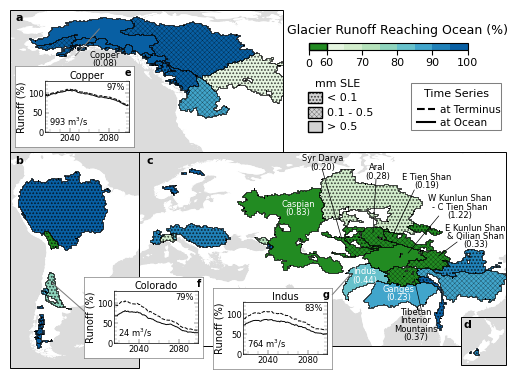

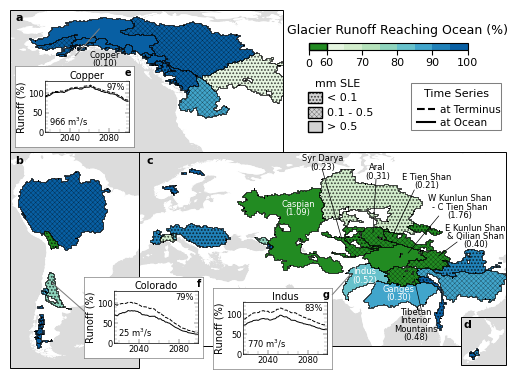

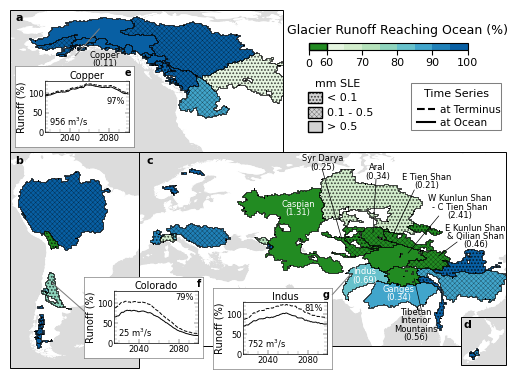

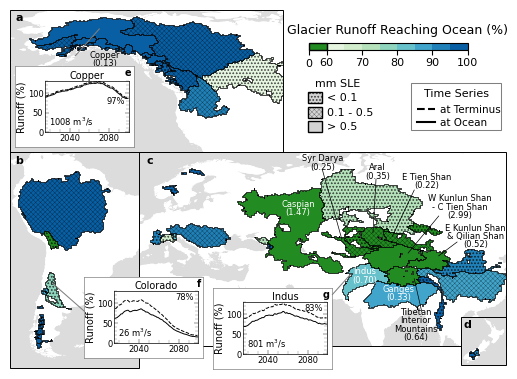

In [33]:
years = ds_wbm.year.values

for scenario in scenarios:
# for scenario in ['ssp245']:

    # Load data
    gdf = gdf_gt30km2.copy()
    gdf['slr_mmSLE_reduction'] = gdf['DN'].map(basin_reduction_dict[scenario])
    gdf['slr_mmSLE'] = gdf['DN'].map(basin_contribution_dict[scenario])
    gdf['frac2ocean'] = gdf['DN'].map(basin_frac_dict[scenario])
    gdf = gdf[gdf['slr_mmSLE_reduction'].notna()]
    gdf['perc2ocean'] = 100*gdf['frac2ocean']

    gdf_bi = gdf.to_crs(ccrs.PlateCarree().proj4_init)
    gdf_bi = gdf_bi.loc[gdf_bi['slr_mmSLE'] > 0.01]
    gdf_bi_endo = gdf_bi.loc[gdf_bi['endo_flag']==1]
    gdf_bi_exor = gdf_bi.loc[gdf_bi['endo_flag']==0]

    # ----- Time Series Scenarios ----
    scenarios2plot = [scenario]

    # ----- Thresholds -----
    mmSLE_1 = 0.01
    mmSLE_2 = 0.1
    mmSLE_3 = 0.5
    
    # ===== FIGURE =====
    color_water = 'gainsboro'
    color_land = 'white'
    lw_main = 0.7
    fontsize = 7

    continuous_cmap = cm.GnBu
    discrete_colors = continuous_cmap(np.linspace(0.1, 0.9, 8))
    cmap = ListedColormap(discrete_colors)
    perc_min = 60
    perc_max = 100
    
    fig = plt.figure()
    gs = fig.add_gridspec(nrows=100, ncols=100, hspace=0, wspace=0)
    
    # ----- Regions -----
    # ax1 = plt.subplot(gs[0:41,5:65], projection=ccrs.PlateCarree()) # North America
    # ax2 = plt.subplot(gs[40:,0:30], projection=ccrs.PlateCarree()) # South America
    # ax3 = plt.subplot(gs[36:,26:99], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
    # ax4 = plt.subplot(gs[38:62,88:], projection=ccrs.PlateCarree()) # New Zealand
    
    ax2 = plt.subplot(gs[35:,0:26], projection=ccrs.PlateCarree()) # South America
    # ax2 = plt.subplot(gs[30:,0:26], projection=ccrs.PlateCarree()) # South America
    ax3 = plt.subplot(gs[31:,26:], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
    # ax4 = plt.subplot(gs[39:63,88:], projection=ccrs.PlateCarree()) # New Zealand
    ax4 = plt.subplot(gs[81:,91:], projection=ccrs.PlateCarree()) # New Zealand
    ax1 = plt.subplot(gs[0:40,0:55], projection=ccrs.PlateCarree()) # North America
    # ax1 = plt.subplot(gs[0:40,0:60], projection=ccrs.PlateCarree()) # North America
    
    bounds_na = [-170,-95, 32, 67]
    bounds_sa=[-82,-40,13,-57]
    bounds_hma=[0, 120, 59.5, 10]
    bounds_nz=[166, 179, -48, -34]
    
    def add_inset(ax, bounds, gdf, color_water=None, color_land=None, add_legend=False, 
                  subfig_str=None, subfig_posx=0.02, subfig_posy=0.98, subfig_textsize=8, linewidth=0.5):
        ax.set_extent(bounds, ccrs.Geodetic())
        ax.spines['geo'].set_edgecolor('k')
        ax.spines['geo'].set_linewidth(0.7)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=color_water))
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor=color_land))

        # Hatch based on mm SLE contribution
        gdf_bi_exor_subset1 = gdf_bi_exor[(gdf_bi_exor['slr_mmSLE'] >= mmSLE_1) & (gdf_bi_exor['slr_mmSLE'] < mmSLE_2)]
        gdf_bi_exor_subset1.plot(ax=ax, column='perc2ocean', hatch='ooooo',
                                 cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='k', linewidth=linewidth, zorder=2)

        gdf_bi_exor_subset2 = gdf_bi_exor[(gdf_bi_exor['slr_mmSLE'] >= mmSLE_2) & (gdf_bi_exor['slr_mmSLE'] < mmSLE_3)]
        gdf_bi_exor_subset2.plot(ax=ax, column='perc2ocean', hatch='xxxxxxx',
                                 cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='k', linewidth=linewidth, zorder=2)

        gdf_bi_exor_subset3 = gdf_bi_exor[gdf_bi_exor['slr_mmSLE'] >= mmSLE_3]
        gdf_bi_exor_subset3.plot(ax=ax, column='perc2ocean',
                                 cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='k', linewidth=linewidth, zorder=2)

        gdf_bi_endo_subset1 = gdf_bi_endo[(gdf_bi_endo['slr_mmSLE'] >= mmSLE_1) & (gdf_bi_endo['slr_mmSLE'] < mmSLE_2)]
        gdf_bi_endo_subset1.plot(ax=ax, color='forestgreen', hatch='ooooo', edgecolor='k', linewidth=linewidth, zorder=2)

        gdf_bi_endo_subset2 = gdf_bi_endo[(gdf_bi_endo['slr_mmSLE'] >= mmSLE_2) & (gdf_bi_endo['slr_mmSLE'] < mmSLE_3)]
        gdf_bi_endo_subset2.plot(ax=ax, color='forestgreen', hatch='xxxxxxx', edgecolor='k', linewidth=linewidth, zorder=2)

        gdf_bi_endo_subset3 = gdf_bi_endo[gdf_bi_endo['slr_mmSLE'] >= mmSLE_3]
        gdf_bi_endo_subset3.plot(ax=ax, color='forestgreen', edgecolor='k', linewidth=linewidth, zorder=2)
        # gdf_bi_endo_minsle.plot(ax=ax, hatch='////////', color='none', edgecolor='k', linewidth=0.5, zorder=4)
        plt.rcParams['hatch.linewidth'] = 0.15

        # Add subfigure label
        ax.text(subfig_posx, subfig_posy, subfig_str, size=subfig_textsize, weight='bold', ha='left', va='top', 
                transform=ax.transAxes)
    
    add_inset(ax1, bounds_na, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='a', subfig_posx=0.02, subfig_posy=0.98, linewidth=0.5)
    add_inset(ax2, bounds_sa, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='b', subfig_posx=0.04, subfig_posy=0.953, linewidth=0.5)
    add_inset(ax3, bounds_hma, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='c', subfig_posx=0.02, subfig_posy=0.98, linewidth=0.5)
    add_inset(ax4, bounds_nz, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='d', subfig_posx=0.04, subfig_posy=0.95, linewidth=0.5)
    
    # ----- Time Series -----
    def add_timeseries(gs_bounds, basin_id, scenarios, ssp_colordict,
                       basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median, 
                       lw_main=0.5, basin_name=None, pointerline_bounds=None, 
                       subfig_str=None):
        gs_y1 = gs_bounds[0]
        gs_y2 = gs_bounds[1]
        gs_x1 = gs_bounds[2]
        gs_x2 = gs_bounds[3]

        # Background box
        # ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-7:gs_x2+3])
        ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-6:gs_x2+1])
        ax1b_background.xaxis.set_visible(False)
        ax1b_background.yaxis.set_visible(False)
        ax1b_background.patch.set_color('white')
        for spine in ax1b_background.spines.values():
            spine.set_color('grey')
            spine.set_linewidth(0.5)

        # Time series plot
        ax1b = plt.subplot(gs[gs_y1:gs_y2, gs_x1:gs_x2])
        
        # normalize by 2016-2035 mean
        basin_glmelt_mean_2015_2035_all = []
        for scenario_subplot in scenarios:
            basin_glmelt_mean_2015_2035_all.append(np.mean(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id][0:20]))
        basin_glmelt_mean_2015_2035 = np.mean(basin_glmelt_mean_2015_2035_all)

                
        basin_glmelt_mean_2015_2035_str = str(int(np.round(basin_glmelt_mean_2015_2035, 0))) + ' m$^{3}$/s'

        # plot normalized values
        for scenario_subplot in scenarios:
            basin_glmelt_median = (uniform_filter(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id], size=(11)) 
                                   / basin_glmelt_mean_2015_2035)
            basin_q_pg_median = (uniform_filter(basin_ids_subplot_q_pg_median[scenario_subplot][basin_id], size=(11)) 
                                 / basin_glmelt_mean_2015_2035)

            if len(scenarios) == 1:
                color_ts = 'k'
            else:
                color_ts = ssp_colordict[scenario_subplot]
    
            ax1b.plot(years, 100*basin_glmelt_median, color=color_ts, 
                      linestyle='--', linewidth=lw_main, zorder=2, label=None)
            ax1b.plot(years, 100*basin_q_pg_median, color=color_ts, 
                      linestyle='-', linewidth=lw_main, zorder=3, label=None)

        # Labels
        ax1b.set_ylabel('Runoff (%)', size=fontsize, labelpad=1)
        ax1b.set_ylim(0,130)
        ax1b.tick_params(axis='y', labelsize=fontsize-1)
        ax1b.tick_params(axis='x', labelsize=fontsize-1)
        ax1b.yaxis.set_major_locator(MultipleLocator(50))
        ax1b.yaxis.set_minor_locator(MultipleLocator(10))
        ax1b.set_xlim(2015,2100)
        ax1b.xaxis.set_major_locator(MultipleLocator(20))
        ax1b.xaxis.set_minor_locator(MultipleLocator(10))
        ax1b.set_xticks([2040, 2080], ['2040', '2080'])
        # ax1b.xaxis.set_major_locator(MultipleLocator(20))
        # ax1b.xaxis.set_minor_locator(MultipleLocator(10))
        ax1b.tick_params(axis='both', which='major', direction='in', right=True, pad=1, width=0.3, length=3)
        ax1b.tick_params(axis='both', which='minor', direction='in', right=True, width=0.15, length=2)

        # Reduce the linewidth of the spines
        for spine in ax1b.spines.values():
            spine.set_linewidth(0.5)  # Set the desired linewidth (default is typically 1.5)

        # Add Basin Name
        if basin_name is None:
            basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
        ax1b.text(0.5, 1.01, basin_name, size=fontsize, horizontalalignment='center', va='bottom', transform=ax1b.transAxes)

        # Add Basin melt
        ax1b.text(0.05, 0.085, basin_glmelt_mean_2015_2035_str, size=fontsize-1, horizontalalignment='left', va='bottom', 
                  transform=ax1b.transAxes)

        # Add Basin Frac2Ocean
        basin_frac2ocean_str = str(int(np.round(100*basin_frac_dict[scenario][basin_id],0))) + '%'
        if scenario in ['ssp370', 'ssp585'] and basin_id in [226]:
            text_y = 0.70
        else:
            text_y = 0.97
        ax1b.text(0.95, text_y, basin_frac2ocean_str, size=fontsize-1, horizontalalignment='right', va='top', 
                  transform=ax1b.transAxes)
        # Add pointer to basin
        if not pointerline_bounds is None:
                ax1b.plot([pointerline_bounds[0], pointerline_bounds[1]], [pointerline_bounds[2], pointerline_bounds[3]], 
                          color='grey', linewidth=0.75, clip_on=False)

        # Add subfigure label
        ax1b_background.text(0.98, 0.98, subfig_str, size=fontsize, weight='bold', ha='right', va='top', 
                             transform=ax1b_background.transAxes)

    # COPPER RIVER
    size_x = 17
    size_y = 14
    
    basin_id = 226
    gs_y1 = 20
    gs_x1 = 7
    gs_y2 = gs_y1 + size_y
    gs_x2 = gs_x1 + size_x
    gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
    pointerline_bounds = [2046, 2070, 193, 260]
    add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
                   basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
                   lw_main=lw_main, pointerline_bounds=pointerline_bounds, subfig_str='e')

    # COLORADO RIVER, ARGENTINA
    basin_id = 54
    basin_name = 'Colorado'
    gs_y1 = 77
    gs_x1 = 21
    gs_y2 = gs_y1 + size_y
    gs_x2 = gs_x1 + size_x
    gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
    pointerline_bounds = [1953, 1985, 150, 80]
    add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
                   basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
                   lw_main=lw_main, basin_name=basin_name, pointerline_bounds=pointerline_bounds, subfig_str='f')

    # INDUS RIVER
    basin_id = 23
    gs_y1 = 80
    gs_x1 = 47
    gs_y2 = gs_y1 + size_y
    gs_x2 = gs_x1 + size_x
    gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
    pointerline_bounds = [2105, 2123, 150, 200]
    add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
                   basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
                   lw_main=lw_main, pointerline_bounds=pointerline_bounds, subfig_str='g')

    # ----- LEGENDS -----
    fontsize_leg = 8
    ax_leg1 = plt.subplot(gs[14:34,58:78])
    ax_leg1.axis('off')
    rect1 = patches.Rectangle((0.1, 0), 0.15, 0.15, facecolor='lightgray', edgecolor='k', clip_on=False)
    rect2 = patches.Rectangle((0.1, 0.2), 0.15, 0.15, facecolor='lightgray', hatch='xxxxxxx', edgecolor='k', clip_on=False)
    rect3 = patches.Rectangle((0.1, 0.4), 0.15, 0.15, facecolor='lightgray', hatch='ooooo', edgecolor='k', clip_on=False)
    ax_leg1.add_patch(rect1)
    ax_leg1.add_patch(rect2)
    ax_leg1.add_patch(rect3)
    
    ax_leg1.text(0.4, 0.6, 'mm SLE', size=fontsize_leg, ha='center', va='bottom', transform=ax_leg1.transAxes)
    ax_leg1.text(0.3, 0.075, '> 0.5', size=fontsize_leg, ha='left', va='center', transform=ax_leg1.transAxes)
    ax_leg1.text(0.3, 0.275, '0.1 - 0.5', size=fontsize_leg, ha='left', va='center', transform=ax_leg1.transAxes)
    ax_leg1.text(0.3, 0.475, '< 0.1', size=fontsize_leg, ha='left', va='center', transform=ax_leg1.transAxes)
    
    # TIMESERIES: LINE STYLE
    lw_leg = 1.5
    axleg = plt.subplot(gs[20:34, 80:])
    axleg.plot([0,0],[0,0], color='k', linestyle='--', linewidth=lw_leg, label='at Terminus')
    axleg.plot([0,0],[0,0], color='k', linestyle='-', linewidth=lw_leg, label='at Ocean')
    axleg.legend(loc=(0.1, 0.1), fontsize=fontsize_leg-0.5, ncol=1, columnspacing=0.8, labelspacing=0.25, 
                 handlelength=1.8, handletextpad=0.4, borderpad=0, frameon=False)
    axleg.set_axis_off()
    axleg.text(0.5, 0.75, 'Time Series', size=fontsize_leg, ha='center', va='center', transform=axleg.transAxes)
    rect_legbox = patches.Rectangle((0, 0), 20, 20, facecolor='none', edgecolor='grey', linewidth=0.75, clip_on=False)
    axleg.add_patch(rect_legbox)

    # ADD VALUES OF AMOUNT REDUCED OVER A GIVEN LEVEL
    basins_onplot = list(gdf_bi.loc[gdf_bi['slr_mmSLE_reduction'] > 0.05, 'DN'].values)
    basin_id_name = {3:'Caspian',
                     14:'Ganges',
                     23:'Indus',
                     33:'W Kunlun Shan\n- C Tien Shan', # 'W Kunlun Shan - Tien Shan'
                     44:'Aral',
                     47:'Syr Darya',
                     132:'E Kunlun Shan\n& Qilian Shan',
                     226:'Copper',
                     228:'E Tien Shan',
                     317:'Tibetan\nInterior\nMountains',
                    }
    basin_text_xy = {3:[52, 55],
                     14:[85.0,27.2],
                     23:[73.7, 33.0],
                     33:[105,55.5],
                     44:[78,67],
                     47:[60,70],
                     132:[110, 46],
                     226:[-144,57.5],
                     228:[94,64],
                     317:[90.5,17],
                    }
    
    for basin_id in basins_onplot:
        # basin_reduction_str = str(np.round(basin_reduction_dict[scenario][basin_id],2))
        basin_reduction_str = "{:.2f}".format(basin_reduction_dict[scenario][basin_id])
        basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]

        linespacing=0.9
        name_size = 6

        if basin_id in [3, 14, 23]:
            color_txt = 'white'
        else:
            color_txt = 'k'

        if basin_id in [3, 14, 23, 33, 44, 47, 132, 228, 317]:
            ax3.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
                     size=name_size, linespacing=linespacing, ha='center', va='center', color=color_txt, zorder=6)
            if basin_id in [33]:
                ax3.plot([88,98], [40.4,52.5], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [44]:
                ax3.plot([76.5,77.5], [47,64.5], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [47]:
                ax3.plot([66.3,60], [45,67.5], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [132]:
                ax3.plot([98,104], [39.5,44], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [228]:
                ax3.plot([82.8,90], [45.8,61], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [317]:
                ax3.plot([90,92.5], [32,21], linewidth=0.5, color=color_txt, zorder=5)

        elif basin_id in [226]:
            ax1.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
                     size=name_size, linespacing=linespacing, ha='center', va='center')            


    # Heat map colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=perc_min, vmax=perc_max))
    sm._A = []
    cax = plt.axes([0.62, 0.79, 0.22, 0.015])
    cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='horizontal')
    cax.xaxis.set_ticks_position('bottom')
    cax.xaxis.set_tick_params(pad=2)
    cbar.ax.tick_params(labelsize=8)

    rect_hatch = patches.Rectangle((55, 0), 5, 0.98, facecolor='forestgreen', edgecolor='k', clip_on=False)
    cax.add_patch(rect_hatch)
    rect_marker = patches.Rectangle((55, -0.7), 0.03, 0.7, facecolor='k', edgecolor='k', lw=0.8, clip_on=False)
    cax.add_patch(rect_marker)
    cax.text(-0.15, -1.82, '0', size=fontsize_leg, ha='left', va='center', transform=cax.transAxes)
    cax.text(0.5, 1.8, 'Glacier Runoff Reaching Ocean (%)', size=9, ha='center', va='bottom', transform=cax.transAxes)
    
    # ----- Saving -----
    # fig.set_size_inches(6,4)
    fig_fp = results_fp + '_figures/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig.savefig(fig_fp + 'Fig3_basins_slr_and_frac_' + scenario + '.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# Bivariate Map: SLE contribution + Fraction to Ocean

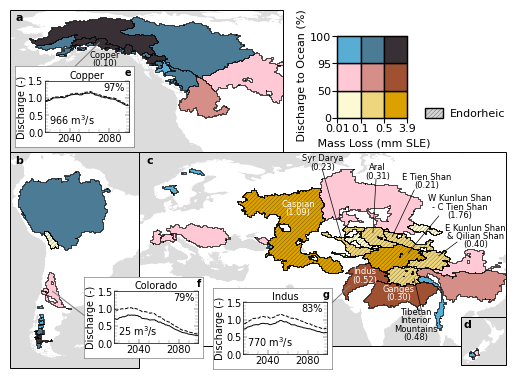

In [34]:
# for scenario in scenarios:
for scenario in ['ssp245']:

    # Load data
    gdf = gdf_gt30km2.copy()
    gdf['slr_mmSLE_reduction'] = gdf['DN'].map(basin_reduction_dict[scenario])
    gdf['slr_mmSLE'] = gdf['DN'].map(basin_contribution_dict[scenario])
    gdf['frac2ocean'] = gdf['DN'].map(basin_frac_dict[scenario])
    gdf = gdf[gdf['slr_mmSLE_reduction'].notna()]
    gdf['perc2ocean'] = 100*gdf['frac2ocean']

    gdf_bi = gdf.to_crs(ccrs.PlateCarree().proj4_init)

    # ----- Time Series Scenarios ----
    scenarios2plot = [scenario]
    # scenarios2plot = scenarios

    # ----- Bivariate Thresholds -----
    mmSLE_1 = 0.01
    mmSLE_2 = 0.1
    mmSLE_3 = 0.5

    frac_1 = 0.0
    frac_2 = 0.5
    frac_3 = 0.95

    # Colors selected from https://jakubnowosad.com/posts/2020-08-25-cbc-bp2/
    # color_lowlow = '#E8E8E8'
    # color_lowmid = '#CBB8D7'
    # color_lowhigh = '#9973AF'
    # color_midlow = '#E4D9AC'
    # color_midmid = '#C8ADA0'
    # color_midhigh = '#976B83'
    # color_highlow = '#C8B35A'
    # color_highmid = '#B08E53'
    # color_highhigh = '#804D36'

    # # alternative 1
    # color_lowlow = '#F3F3F3'
    # color_midlow = '#F3E6B3'
    # color_highlow = '#F3B301'
    # color_lowmid = '#B4D3E1'
    # color_midmid = '#B3B3B3'
    # color_highmid = '#B36600'
    # color_lowhigh = '#509DC2'
    # color_midhigh = '#376387'
    # color_highhigh = '#2F282B'

    # alternative 1 - custom
    color_lowlow = '#FBFAD3' #'lightgoldenrodyellow'
    color_midlow = '#EED67F' #'#F8DE7F'
    color_highlow = '#DBA101' #'#F3B301'
    color_lowmid = '#FFC8D5' #'#FAB6C2'
    color_midmid = '#D68E88' #'#E69674'
    color_highmid = '#9F5132' #'#C76600'
    color_lowhigh = '#58ADD5' #'#509DC2'
    color_midhigh = '#4B7B95' #'#376387'
    color_highhigh = '#383034' #'#2F282B'

    # # alternative 2
    # color_lowlow = '#F7CE8B'
    # color_midlow = '#E16439'
    # color_highlow = '#B40000'
    # color_lowmid = '#E6E6E6'
    # color_midmid = '#BFBFBF'
    # color_highmid = '#7F7F7F'
    # color_lowhigh = '#C0B3D6'
    # color_midhigh = '#7868A7'
    # color_highhigh = '#210E5A'

    # Lowest mmSLE + Lowest red
    gdf_bi_subset1 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_1) & (gdf_bi['slr_mmSLE'] < mmSLE_2) & 
                            (gdf_bi['frac2ocean'] >= frac_1) & (gdf_bi['frac2ocean'] < frac_2)]
    color_subset1 = color_lowlow
    
    # Lowest mmSLE + Middle red
    gdf_bi_subset2 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_1) & (gdf_bi['slr_mmSLE'] < mmSLE_2) & 
                            (gdf_bi['frac2ocean'] >= frac_2) & (gdf_bi['frac2ocean'] < frac_3)]
    color_subset2 = color_lowmid

    # Lowest mmSLE + Upper red
    gdf_bi_subset3 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_1) & (gdf_bi['slr_mmSLE'] < mmSLE_2) & 
                            (gdf_bi['frac2ocean'] >= frac_3)]
    color_subset3 = color_lowhigh

    # Middle mmSLE + Lowest red
    gdf_bi_subset4 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_2) & (gdf_bi['slr_mmSLE'] < mmSLE_3) & 
                            (gdf_bi['frac2ocean'] >= frac_1) & (gdf_bi['frac2ocean'] < frac_2)]
    color_subset4 = color_midlow

    # Middle mmSLE + Middle red
    gdf_bi_subset5 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_2) & (gdf_bi['slr_mmSLE'] < mmSLE_3) & 
                            (gdf_bi['frac2ocean'] >= frac_2) & (gdf_bi['frac2ocean'] < frac_3)]
    color_subset5 = color_midmid

    # Middle mmSLE + Upper red
    gdf_bi_subset6 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_2) & (gdf_bi['slr_mmSLE'] < mmSLE_3) & 
                            (gdf_bi['frac2ocean'] >= frac_3)]
    color_subset6 = color_midhigh

    # Upper mmSLE + Lowest red
    gdf_bi_subset7 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_3) & 
                            (gdf_bi['frac2ocean'] >= frac_1) & (gdf_bi['frac2ocean'] < frac_2)]
    color_subset7 = color_highlow

    # Upper mmSLE + Middle red
    gdf_bi_subset8 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_3) & 
                            (gdf_bi['frac2ocean'] >= frac_2) & (gdf_bi['frac2ocean'] < frac_3)]
    color_subset8 = color_highmid

    # Upper mmSLE + Middle red
    gdf_bi_subset9 = gdf_bi[(gdf_bi['slr_mmSLE'] >= mmSLE_3) & 
                            (gdf_bi['frac2ocean'] >= frac_3)]
    color_subset9 = color_highhigh
    
    # ===== FIGURE =====
    color_water = 'gainsboro'
    color_land = 'white'
    lw_main = 0.7
    fontsize = 7
    
    fig = plt.figure()
    gs = fig.add_gridspec(nrows=100, ncols=100, hspace=0, wspace=0)
    
    # ----- Regions -----
    # ax1 = plt.subplot(gs[0:41,5:65], projection=ccrs.PlateCarree()) # North America
    # ax2 = plt.subplot(gs[40:,0:30], projection=ccrs.PlateCarree()) # South America
    # ax3 = plt.subplot(gs[36:,26:99], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
    # ax4 = plt.subplot(gs[38:62,88:], projection=ccrs.PlateCarree()) # New Zealand
    
    ax2 = plt.subplot(gs[35:,0:26], projection=ccrs.PlateCarree()) # South America
    # ax2 = plt.subplot(gs[30:,0:26], projection=ccrs.PlateCarree()) # South America
    ax3 = plt.subplot(gs[31:,26:], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
    # ax4 = plt.subplot(gs[39:63,88:], projection=ccrs.PlateCarree()) # New Zealand
    ax4 = plt.subplot(gs[81:,91:], projection=ccrs.PlateCarree()) # New Zealand
    ax1 = plt.subplot(gs[0:40,0:55], projection=ccrs.PlateCarree()) # North America
    # ax1 = plt.subplot(gs[0:40,0:60], projection=ccrs.PlateCarree()) # North America
    
    bounds_na = [-170,-95, 32, 67]
    bounds_sa=[-82,-40,13,-57]
    bounds_hma=[0, 120, 59.5, 10]
    bounds_nz=[166, 179, -48, -34]
    
    def add_inset(ax, bounds, gdf, color_water=None, color_land=None, add_legend=False, 
                  subfig_str=None, subfig_posx=0.02, subfig_posy=0.98, subfig_textsize=8):
        ax.set_extent(bounds, ccrs.Geodetic())
        ax.spines['geo'].set_edgecolor('k')
        ax.spines['geo'].set_linewidth(0.7)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=color_water))
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor=color_land))
        
        # gdf_bi.plot(ax=ax, color='white', edgecolor='k', linewidth=0.5, zorder=2)
        # gdf_bi.plot(ax=ax, hatch='////////', color='white', edgecolor='k', linewidth=0.5, zorder=2)
        # plt.rcParams['hatch.linewidth'] = 0.25

        # Bivariate subsets
        gdf_bi_subset1.plot(ax=ax, color=color_subset1, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset2.plot(ax=ax, color=color_subset2, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset3.plot(ax=ax, color=color_subset3, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset4.plot(ax=ax, color=color_subset4, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset5.plot(ax=ax, color=color_subset5, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset6.plot(ax=ax, color=color_subset6, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset7.plot(ax=ax, color=color_subset7, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset8.plot(ax=ax, color=color_subset8, edgecolor='k', linewidth=0.5, zorder=3)
        gdf_bi_subset9.plot(ax=ax, color=color_subset9, edgecolor='k', linewidth=0.5, zorder=3)

        gdf_bi_endo = gdf_bi.loc[gdf_bi['endo_flag']==1]
        gdf_bi_endo_minsle = gdf_bi_endo.loc[gdf_bi_endo['slr_mmSLE'] >= mmSLE_1]
        gdf_bi_endo_minsle.plot(ax=ax, hatch='////////', color='none', edgecolor='k', linewidth=0.5, zorder=4)
        plt.rcParams['hatch.linewidth'] = 0.15

        # Add subfigure label
        ax.text(subfig_posx, subfig_posy, subfig_str, size=subfig_textsize, weight='bold', ha='left', va='top', 
                transform=ax.transAxes)
    
    add_inset(ax1, bounds_na, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='a', subfig_posx=0.02, subfig_posy=0.98)
    add_inset(ax2, bounds_sa, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='b', subfig_posx=0.04, subfig_posy=0.953)
    add_inset(ax3, bounds_hma, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='c', subfig_posx=0.02, subfig_posy=0.98)
    add_inset(ax4, bounds_nz, gdf, color_water=color_water, color_land=color_land, 
              subfig_str='d', subfig_posx=0.04, subfig_posy=0.95)
    
    # ----- Time Series -----
    def add_timeseries(gs_bounds, basin_id, scenarios, ssp_colordict,
                       basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median, 
                       lw_main=0.5, basin_name=None, pointerline_bounds=None, 
                       subfig_str=None):
        gs_y1 = gs_bounds[0]
        gs_y2 = gs_bounds[1]
        gs_x1 = gs_bounds[2]
        gs_x2 = gs_bounds[3]

        # Background box
        # ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-7:gs_x2+3])
        ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-6:gs_x2+1])
        ax1b_background.xaxis.set_visible(False)
        ax1b_background.yaxis.set_visible(False)
        ax1b_background.patch.set_color('white')
        for spine in ax1b_background.spines.values():
            spine.set_color('grey')
            spine.set_linewidth(0.5)

        # Time series plot
        ax1b = plt.subplot(gs[gs_y1:gs_y2, gs_x1:gs_x2])
        
        # normalize by 2016-2035 mean
        basin_glmelt_mean_2015_2035_all = []
        for scenario_subplot in scenarios:
            basin_glmelt_mean_2015_2035_all.append(np.mean(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id][0:20]))
        basin_glmelt_mean_2015_2035 = np.mean(basin_glmelt_mean_2015_2035_all)

                
        basin_glmelt_mean_2015_2035_str = str(int(np.round(basin_glmelt_mean_2015_2035, 0))) + ' m$^{3}$/s'

        # plot normalized values
        for scenario_subplot in scenarios:
            basin_glmelt_median = (uniform_filter(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id], size=(11)) 
                                   / basin_glmelt_mean_2015_2035)
            basin_q_pg_median = (uniform_filter(basin_ids_subplot_q_pg_median[scenario_subplot][basin_id], size=(11)) 
                                 / basin_glmelt_mean_2015_2035)

            if len(scenarios) == 1:
                color_ts = 'k'
            else:
                color_ts = ssp_colordict[scenario_subplot]
    
            ax1b.plot(years, basin_glmelt_median, color=color_ts, 
                      linestyle='--', linewidth=lw_main, zorder=2, label=None)
            ax1b.plot(years, basin_q_pg_median, color=color_ts, 
                      linestyle='-', linewidth=lw_main, zorder=3, label=None)

        # Labels
        ax1b.set_ylabel('Discharge (-)', size=fontsize, labelpad=1)
        ax1b.set_ylim(0,1.5)
        ax1b.tick_params(axis='y', labelsize=fontsize)
        ax1b.tick_params(axis='x', labelsize=fontsize)
        ax1b.yaxis.set_major_locator(MultipleLocator(0.5))
        ax1b.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax1b.set_xlim(2015,2100)
        ax1b.xaxis.set_major_locator(MultipleLocator(20))
        ax1b.xaxis.set_minor_locator(MultipleLocator(10))
        ax1b.set_xticks([2040, 2080], ['2040', '2080'])
        # ax1b.xaxis.set_major_locator(MultipleLocator(20))
        # ax1b.xaxis.set_minor_locator(MultipleLocator(10))
        ax1b.tick_params(axis='both', which='major', direction='in', right=True, pad=1, width=0.3, length=3)
        ax1b.tick_params(axis='both', which='minor', direction='in', right=True, width=0.15, length=2)

        # Reduce the linewidth of the spines
        for spine in ax1b.spines.values():
            spine.set_linewidth(0.5)  # Set the desired linewidth (default is typically 1.5)

        # Add Basin Name
        if basin_name is None:
            basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
        ax1b.text(0.5, 1.01, basin_name, size=fontsize, horizontalalignment='center', va='bottom', transform=ax1b.transAxes)

        # Add Basin melt
        ax1b.text(0.05, 0.085, basin_glmelt_mean_2015_2035_str, size=fontsize, horizontalalignment='left', va='bottom', 
                  transform=ax1b.transAxes)

        # Add Basin Frac2Ocean
        basin_frac2ocean_str = str(int(np.round(100*basin_frac_dict[scenario][basin_id],0))) + '%'
        ax1b.text(0.95, 0.97, basin_frac2ocean_str, size=fontsize, horizontalalignment='right', va='top', 
                  transform=ax1b.transAxes)
        # Add pointer to basin
        if not pointerline_bounds is None:
                ax1b.plot([pointerline_bounds[0], pointerline_bounds[1]], [pointerline_bounds[2], pointerline_bounds[3]], 
                          color='grey', linewidth=0.75, clip_on=False)

        # Add subfigure label
        ax1b_background.text(0.98, 0.98, subfig_str, size=fontsize, weight='bold', ha='right', va='top', 
                             transform=ax1b_background.transAxes)

    # COPPER RIVER
    size_x = 17
    size_y = 14
    
    basin_id = 226
    gs_y1 = 20
    gs_x1 = 7
    gs_y2 = gs_y1 + size_y
    gs_x2 = gs_x1 + size_x
    gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
    pointerline_bounds = [2046, 2070, 1.93, 2.6]
    add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
                   basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
                   lw_main=lw_main, pointerline_bounds=pointerline_bounds, subfig_str='e')

    # COLORADO RIVER, ARGENTINA
    basin_id = 54
    basin_name = 'Colorado'
    gs_y1 = 77
    gs_x1 = 21
    gs_y2 = gs_y1 + size_y
    gs_x2 = gs_x1 + size_x
    gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
    pointerline_bounds = [1953, 1985, 1.5, 0.8]
    add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
                   basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
                   lw_main=lw_main, basin_name=basin_name, pointerline_bounds=pointerline_bounds, subfig_str='f')

    # INDUS RIVER
    basin_id = 23
    gs_y1 = 80
    gs_x1 = 47
    gs_y2 = gs_y1 + size_y
    gs_x2 = gs_x1 + size_x
    gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
    pointerline_bounds = [2105, 2123, 1.5, 2.0]
    add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
                   basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
                   lw_main=lw_main, pointerline_bounds=pointerline_bounds, subfig_str='g')

    # ----- LEGENDS -----
    fontsize_leg = 8
    # ax_leg1 = plt.subplot(gs[3:27,67:82])
    ax_leg1 = plt.subplot(gs[8:30,66:80])
    rect1 = patches.Rectangle((0, 0), 0.33, 0.33, facecolor=color_lowlow, edgecolor='k', clip_on=False)
    rect2 = patches.Rectangle((0.33, 0), 0.33, 0.33, facecolor=color_midlow, edgecolor='k', clip_on=False)
    rect3 = patches.Rectangle((0.66, 0), 0.33, 0.33, facecolor=color_highlow, edgecolor='k', clip_on=False)
    rect4 = patches.Rectangle((0, 0.33), 0.33, 0.33, facecolor=color_lowmid, edgecolor='k', clip_on=False)
    rect5 = patches.Rectangle((0.33, 0.33), 0.33, 0.33, facecolor=color_midmid, edgecolor='k', clip_on=False)
    rect6 = patches.Rectangle((0.66, 0.33), 0.33, 0.33, facecolor=color_highmid, edgecolor='k', clip_on=False)
    rect7 = patches.Rectangle((0, 0.66), 0.33, 0.33, facecolor=color_lowhigh, edgecolor='k', clip_on=False)
    rect8 = patches.Rectangle((0.33, 0.66), 0.33, 0.33, facecolor=color_midhigh, edgecolor='k', clip_on=False)
    rect9 = patches.Rectangle((0.66, 0.66), 0.33, 0.33, facecolor=color_highhigh, edgecolor='k', clip_on=False)
    ax_leg1.add_patch(rect1)
    ax_leg1.add_patch(rect2)
    ax_leg1.add_patch(rect3)
    ax_leg1.add_patch(rect4)
    ax_leg1.add_patch(rect5)
    ax_leg1.add_patch(rect6)
    ax_leg1.add_patch(rect7)
    ax_leg1.add_patch(rect8)
    ax_leg1.add_patch(rect9)
    ax_leg1.set_ylabel(' Discharge to Ocean (%)', size=fontsize_leg, labelpad=2)
    ax_leg1.set_xlabel(' Mass Loss (mm SLE)', size=fontsize_leg, labelpad=3)
    ax_leg1.set_xlim(0,0.99)
    ax_leg1.set_ylim(0,0.99)
    ax_leg1.yaxis.set_major_locator(MultipleLocator(0.33))
    ax_leg1.xaxis.set_major_locator(MultipleLocator(0.33))
    ax_leg1.tick_params(axis='y', labelsize=fontsize_leg, pad=1)
    ax_leg1.tick_params(axis='x', labelsize=fontsize_leg, pad=1)
    ax_leg1.set_xticks([0, 0.33, 0.66, 0.99], [str(mmSLE_1), str(mmSLE_2), str(mmSLE_3), str(np.round(gdf_bi['slr_mmSLE'].max(),1))])
    ax_leg1.set_yticks([0, 0.33, 0.66, 0.99], [str(int(np.round(100*frac_1,0))), str(int(np.round(100*frac_2,0))), str(int(np.round(100*frac_3,0))), '100'])

    # rect_hatch = patches.Rectangle((-0.1, 1.15), 0.33, 0.12, hatch='////////', facecolor='white', edgecolor='k', clip_on=False)
    # ax_leg1.text(0.28, 1.21, 'Endorheic', size=fontsize_leg, ha='left', va='center', transform=ax_leg1.transAxes)
    rect_hatch = patches.Rectangle((1.25, 0), 0.25, 0.12, hatch='////////', facecolor='lightgrey', edgecolor='k', clip_on=False)
    ax_leg1.text(1.62, 0.05, 'Endorheic', size=fontsize_leg, ha='left', va='center', transform=ax_leg1.transAxes)
    ax_leg1.add_patch(rect_hatch)
    
    
    # # TIMESERIES: LINE STYLE
    # lw_leg = 1.5
    # # axleg = plt.subplot(gs[13:27, 80:])
    # axleg = plt.subplot(gs[8:22, 80:])
    # axleg.plot([0,0],[0,0], color='k', linestyle='--', linewidth=lw_leg, label='at Terminus')
    # axleg.plot([0,0],[0,0], color='k', linestyle='-', linewidth=lw_leg, label='at Ocean')
    # axleg.legend(loc=(0.1, 0.1), fontsize=fontsize_leg-0.5, ncol=1, columnspacing=0.8, labelspacing=0.25, 
    #              handlelength=1.8, handletextpad=0.4, borderpad=0, frameon=False)
    # axleg.set_axis_off()
    # axleg.text(0.5, 0.75, 'Discharge Plots', size=fontsize_leg, ha='center', va='center', transform=axleg.transAxes)
    # rect_legbox = patches.Rectangle((0, 0), 20, 20, facecolor='none', edgecolor='grey', linewidth=0.75, clip_on=False)
    # axleg.add_patch(rect_legbox)

    # ADD VALUES OF AMOUNT REDUCED OVER A GIVEN LEVEL
    basins_onplot = list(gdf_bi.loc[gdf_bi['slr_mmSLE_reduction'] > 0.05, 'DN'].values)
    basin_id_name = {3:'Caspian',
                     14:'Ganges',
                     23:'Indus',
                     33:'W Kunlun Shan\n- C Tien Shan', # 'W Kunlun Shan - Tien Shan'
                     44:'Aral',
                     47:'Syr Darya',
                     132:'E Kunlun Shan\n& Qilian Shan',
                     226:'Copper',
                     228:'E Tien Shan',
                     317:'Tibetan\nInterior\nMountains',
                    }
    basin_text_xy = {3:[52, 55],
                     14:[85.0,27.2],
                     23:[73.7, 33.0],
                     33:[105,55.5],
                     44:[78,67],
                     47:[60,70],
                     132:[110, 46],
                     226:[-144,57.5],
                     228:[94,64],
                     317:[90.5,17],
                    }
    
    for basin_id in basins_onplot:
        # basin_reduction_str = str(np.round(basin_reduction_dict[scenario][basin_id],2))
        basin_reduction_str = "{:.2f}".format(basin_reduction_dict[scenario][basin_id])
        basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]

        linespacing=0.9
        name_size = 6

        if basin_id in [3, 14, 23]:
            color_txt = 'white'
        else:
            color_txt = 'k'

        if basin_id in [3, 14, 23, 33, 44, 47, 132, 228, 317]:
            ax3.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
                     size=name_size, linespacing=linespacing, ha='center', va='center', color=color_txt, zorder=6)
            if basin_id in [33]:
                ax3.plot([88,98], [40.4,52.5], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [44]:
                ax3.plot([76.5,77.5], [47,64.5], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [47]:
                ax3.plot([66.3,60], [45,67.5], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [132]:
                ax3.plot([98,104], [39.5,44], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [228]:
                ax3.plot([82.8,90], [45.8,61], linewidth=0.5, color=color_txt, zorder=5)
            elif basin_id in [317]:
                ax3.plot([90,92.5], [32,21], linewidth=0.5, color=color_txt, zorder=5)

        elif basin_id in [226]:
            ax1.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
                     size=name_size, linespacing=linespacing, ha='center', va='center')            


    # ----- Saving -----
    # fig.set_size_inches(6,4)
    fig_fp = results_fp + '_figures/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig.savefig(fig_fp + 'Fig3b_basins_bivariate_slr_and_frac_' + scenario + '.png', dpi=300, bbox_inches='tight')
    
    plt.show()

### Values of interest for paper

In [35]:
# for scenario in scenarios:
for scenario in ['ssp245']:

    # Load data
    gdf = gdf_gt30km2.copy()
    gdf['slr_mmSLE_reduction'] = gdf['DN'].map(basin_reduction_dict[scenario])
    gdf['slr_mmSLE'] = gdf['DN'].map(basin_contribution_dict[scenario])
    gdf['frac2ocean'] = gdf['DN'].map(basin_frac_dict[scenario])
    gdf = gdf[gdf['slr_mmSLE_reduction'].notna()]
    gdf['perc2ocean'] = 100*gdf['frac2ocean']

print('basin_id, slr reduction (mmSLE), slr contribution (mmSLE), % to ocean')
for basin_id in [23,14,226]:
    print('  ', basin_id, 
          np.round(gdf.loc[gdf['DN']==basin_id, 'slr_mmSLE_reduction'].values[0],2),
          np.round(gdf.loc[gdf['DN']==basin_id, 'slr_mmSLE'].values[0],2),
          int(np.round(100*gdf.loc[gdf['DN']==basin_id, 'frac2ocean'].values[0],0)))

basin_id, slr reduction (mmSLE), slr contribution (mmSLE), % to ocean
   23 0.52 2.89 83
   14 0.3 2.25 87
   226 0.1 3.88 97


In [36]:
gdf_exor = gdf[gdf['endo_flag']==0]
gdf_exor_minloss = gdf_exor[gdf_exor['slr_mmSLE'] > 0.01]
gdf_exor_sort = gdf_exor_minloss.sort_values('perc2ocean')
basin_ids_sorted_raw = gdf_exor_sort.DN.values

basin_ids_sorted = []
for basin_id in basin_ids_sorted_raw:
    if not basin_id in basin_ids_sorted:
        basin_ids_sorted.append(basin_id)

for nid, basin_id in enumerate(basin_ids_sorted[0:10]):
    print(nid, basin_id, 
          df_basins.loc[df_basins['ID']==basin_id,'Name'].values[0], 
          int(np.round(100*basin_frac_dict[scenario][basin_id],0)),
          np.round(gdf.loc[gdf['DN']==basin_id, 'slr_mmSLE_reduction'].values[0],2),
          np.round(gdf.loc[gdf['DN']==basin_id, 'slr_mmSLE'].values[0],2))

0 16 Nelson 62 0.01 0.03
1 192 Po 68 0.02 0.06
2 8 Ob 69 0.02 0.07
3 292 Kuban 76 0.0 0.01
4 54 Colorado (Argentina) 79 0.01 0.07
5 23 Indus 83 0.52 2.89
6 644 nan 84 0.0 0.01
7 14 Ganges 87 0.3 2.25
8 32 Columbia 87 0.03 0.27
9 11 Chang Jiang 88 0.03 0.26


In [37]:
gdf_exor_sort.shape

(148, 11)

In [38]:
df_basins[df_basins['ID']==292]

,ID,Name,Area,src_ID,SeaCode,SeaName,OceanCode,OceanName,SubContinentCode,SubContinentName,Endorheic,Glaciers,Glaciers_IBT
291,292,Kuban,52449.99,251.0,6,Azov Sea,4,Mediterranean+Black Sea,4,Europe,0,1,none


#### Glacierized regions statistics for paper

In [39]:
reg_print = [1, 2, 13, 14, 15]
for reg in regions:
    if reg in reg_print:
        print('')
    for scenario in scenarios:
        reg_slr = reg_annual_slr_mmSLE_dict[scenario][reg][:,year_start_idx:]
        reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[scenario][reg][:,year_start_idx:]
    
        reg_slr_reduction = reg_slr_raw.sum(1) - reg_slr.sum(1)
        reg_slr_reduction_median = np.median(reg_slr_reduction)
        reg_slr_reduction_std = np.std(reg_slr_reduction)

        if reg in reg_print:
            print(reg, scenario, np.round(reg_slr_reduction_median,1), np.round(1.96*reg_slr_reduction_std,1))

# Merge HMA together
print(' ')
for scenario in scenarios:
    reg_slr = None
    reg_slr_raw = None
    for reg in [13, 14, 15]:
        if reg_slr is None:
            reg_slr = reg_annual_slr_mmSLE_dict[scenario][reg][:,year_start_idx:]
            reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[scenario][reg][:,year_start_idx:]
        else:
            reg_slr = reg_slr + reg_annual_slr_mmSLE_dict[scenario][reg][:,year_start_idx:]
            reg_slr_raw = reg_slr_raw + reg_annual_slr_mmSLE_raw_dict[scenario][reg][:,year_start_idx:]

    reg_slr_reduction = reg_slr_raw.sum(1) - reg_slr.sum(1)
    reg_slr_reduction_median = np.median(reg_slr_reduction)
    reg_slr_reduction_std = np.std(reg_slr_reduction)

    print('HMA', scenario, np.round(reg_slr_reduction_median,1), np.round(1.96*reg_slr_reduction_std,1))


1 ssp126 0.1 0.1
1 ssp245 0.1 0.1
1 ssp370 0.1 0.1
1 ssp585 0.2 0.1

2 ssp126 0.1 0.0
2 ssp245 0.1 0.0
2 ssp370 0.1 0.0
2 ssp585 0.1 0.0

13 ssp126 2.5 0.7
13 ssp245 3.3 0.5
13 ssp370 4.0 0.5
13 ssp585 4.6 0.7

14 ssp126 0.7 0.3
14 ssp245 0.8 0.4
14 ssp370 1.2 0.5
14 ssp585 1.4 0.6

15 ssp126 0.2 0.0
15 ssp245 0.2 0.0
15 ssp370 0.2 0.0
15 ssp585 0.2 0.0
 
HMA ssp126 3.3 0.9
HMA ssp245 4.4 0.8
HMA ssp370 5.4 0.9
HMA ssp585 6.3 1.2


### Endorheic glaciers by area in HMA

In [40]:
rgi_df_wbasins = pd.read_csv(rgiids_wbasins_fn)
group_dict = dict(zip(rgi_df_wbasins.RGIId, rgi_df_wbasins.MeritID))

main_glac_rgi_hma = selectglaciersrgitable(rgi_regionsO1=[13,14,15])
main_glac_rgi_hma['basin'] = [int(x) if ~np.isnan(x) else int(-9999) for x in main_glac_rgi_hma['RGIId'].map(group_dict)]
basins_endorheic_dict = dict(zip(df_basins.ID.values, df_basins.Endorheic.values))
main_glac_rgi_hma['endorheic'] = main_glac_rgi_hma['basin'].map(basins_endorheic_dict)
print('Endorheic glaciers by area (HMA):', np.round(100*
    main_glac_rgi_hma.loc[main_glac_rgi_hma['endorheic'] == 1, 'Area'].sum() / main_glac_rgi_hma['Area'].sum(),0), '%')

Endorheic glaciers by area (HMA): 49.0 %


In [41]:
main_glac_rgi_all = selectglaciersrgitable(rgi_regionsO1=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
main_glac_rgi_all['basin'] = [int(x) if ~np.isnan(x) else int(-9999) for x in main_glac_rgi_all['RGIId'].map(group_dict)]
basins_endorheic_dict = dict(zip(df_basins.ID.values, df_basins.Endorheic.values))
main_glac_rgi_all['endorheic'] = main_glac_rgi_all['basin'].map(basins_endorheic_dict)
print('Endorheic glaciers by area (all):', np.round(100*
    main_glac_rgi_all.loc[main_glac_rgi_all['endorheic'] == 1, 'Area'].sum() / main_glac_rgi_all['Area'].sum(),0), '%')

Endorheic glaciers by area (all): 7.0 %


#### Table S2: RGI Region Stats

In [42]:
reg_cns = ['Global'] + [rgi_reg_dict[reg] + ' (' + str(reg) + ')' for reg in regions]

df_cns = []
var_cns = ['SLR (mm SLE)', 'SLR lost (mm SLE)', '% SLR to ocean']
for var_cn in var_cns:
    for scenario in scenarios:
        df_cns.append(var_cn + '-' + scenario)
df_cns

reg_supp_df = pd.DataFrame(np.zeros((len(reg_cns), len(df_cns))), columns=df_cns, index=reg_cns)

# SLR stats
for scenario in scenarios:
    global_slr = None
    global_slr_raw = None
    for reg in regions:
        reg_slr = reg_annual_slr_mmSLE_dict[scenario][reg][:,year_start_idx:]
        reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[scenario][reg][:,year_start_idx:]
    
        reg_slr_reduction = reg_slr_raw.sum(1) - reg_slr.sum(1)
        reg_slr_reduction_median = np.median(reg_slr_reduction)
        reg_slr_reduction_std = np.std(reg_slr_reduction)

        # Record
        reg_supp_df.loc[rgi_reg_dict[reg] + ' (' + str(reg) + ')' , 'SLR (mm SLE)' + '-' + scenario] = np.median(reg_slr_raw.sum(1))
        reg_supp_df.loc[rgi_reg_dict[reg] + ' (' + str(reg) + ')' , 'SLR lost (mm SLE)' + '-' + scenario] = reg_slr_reduction_median
        reg_supp_df.loc[rgi_reg_dict[reg] + ' (' + str(reg) + ')' , '% SLR to ocean' + '-' + scenario] = 100 - 100*(reg_slr_reduction_median / np.median(reg_slr_raw.sum(1)))
        

        # Global aggregation
        if global_slr is None:
            global_slr = reg_slr
            global_slr_raw = reg_slr_raw
        else:
            global_slr = global_slr + reg_slr
            global_slr_raw = global_slr_raw + reg_slr_raw

    # Record Global
    global_slr_reduction = global_slr_raw.sum(1) - global_slr.sum(1)
    reg_supp_df.loc['Global', 'SLR (mm SLE)' + '-' + scenario] = np.median(global_slr_raw.sum(1))
    reg_supp_df.loc['Global', 'SLR lost (mm SLE)' + '-' + scenario] = np.median(global_slr_reduction)
    reg_supp_df.loc['Global', '% SLR to ocean' + '-' + scenario] = 100 - 100*(np.median(global_slr_reduction) / np.median(global_slr_raw.sum(1)))

reg_supp_df.to_csv(results_fp + 'Table_S2_rgi_reg_stats.csv')
reg_supp_df

,SLR (mm SLE)-ssp126,SLR (mm SLE)-ssp245,SLR (mm SLE)-ssp370,SLR (mm SLE)-ssp585,SLR lost (mm SLE)-ssp126,SLR lost (mm SLE)-ssp245,SLR lost (mm SLE)-ssp370,SLR lost (mm SLE)-ssp585,% SLR to ocean-ssp126,% SLR to ocean-ssp245,% SLR to ocean-ssp370,% SLR to ocean-ssp585
Global,97.727886,116.103885,147.499158,165.854904,3.604344,4.721634,5.814444,6.644554,96.311857,95.933268,96.057982,95.993755
Alaska (1),23.290055,26.760767,30.682724,33.854886,0.091443,0.111931,0.129661,0.154249,99.607373,99.581733,99.577413,99.544382
W Canada & US (2),2.026883,2.247767,2.369892,2.397739,0.057302,0.061110,0.058694,0.056826,97.172885,97.281304,97.523350,97.630036
Arctic Canada North (3),10.175227,12.078377,14.812970,17.193041,-0.060571,-0.067186,-0.072744,-0.074403,100.595276,100.556250,100.491080,100.432749
Arctic Canada South (4),9.359505,11.062638,12.548058,14.031531,-0.025452,-0.029259,-0.030399,-0.026090,100.271935,100.264485,100.242263,100.185939
Greenland Periphery (5),11.773187,13.966206,16.607885,18.664947,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000
Iceland (6),3.732795,4.610376,5.399683,6.227537,-0.002516,-0.003134,-0.003554,-0.002381,100.067394,100.067967,100.065825,100.038232
Svalbard (7),4.824848,6.623958,9.311012,12.445887,-0.008430,-0.008521,-0.008692,-0.009119,100.174728,100.128632,100.093350,100.073269
Scandinavia (8),0.524102,0.589733,0.645344,0.662193,0.005676,0.004955,0.003933,0.004218,98.917029,99.159869,99.390591,99.362976
Russian Arctic (9),6.076003,7.586292,11.135997,13.964326,-0.014183,-0.015865,-0.016027,-0.014802,100.233421,100.209126,100.143925,100.105997


# Map Overview Figure

### No Greenland And Antarctica

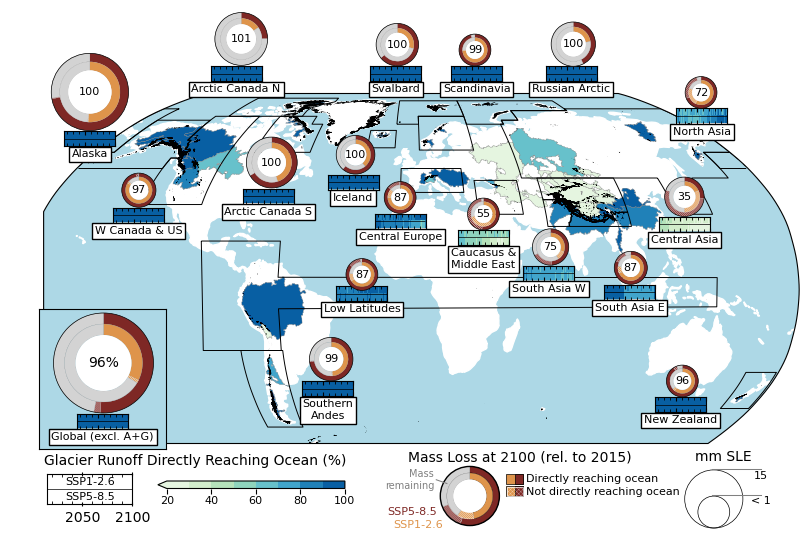

In [43]:
#%% ----- FIGURE: GLOBAL COMBINED -----
scenario = 'ssp245'

add_rgi_glaciers = True
add_rgi_regions = True

continuous_cmap = cm.GnBu
discrete_colors = continuous_cmap(np.linspace(0.1, 0.9, 8))
cmap = ListedColormap(discrete_colors)
perc_min = 20
perc_max = 100

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Note that I'm ignoring clipping and other edge cases here.
        result, is_scalar = self.process_value(value)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

rgi_reg_fig_dict = {'all':'Global (excl. A+G)',
                    1:'Alaska',
                    2:'W Canada & US',
                    3:'Arctic Canada N',
                    4:'Arctic Canada S',
                    5:'Greenland Periphery',
                    6:'Iceland',
                    7:'Svalbard',
                    8:'Scandinavia',
                    9:'Russian Arctic',
                    10:'North Asia',
                    11:'Central Europe',
                    12:'Caucasus &\nMiddle East',
                    13:'Central Asia',
                    14:'South Asia W',
                    15:'South Asia E',
                    16:'Low Latitudes',
                    17:'Southern\nAndes',
                    18:'New Zealand',
                    19:'Antarctic & Subantarctic'
                    }



fig = plt.figure()

# Add background image
ax_background = fig.add_axes([0,0.15,1,0.7], projection=ccrs.Robinson())
ax_background.patch.set_facecolor('lightblue')
ax_background.get_yaxis().set_visible(False)
ax_background.get_xaxis().set_visible(False)
ax_background.add_feature(cartopy.feature.LAND, color='white')

# Add global boundary
ax_global_patch = fig.add_axes([0.05,0.14,0.15,0.28], facecolor='lightblue')
ax_global_patch.get_yaxis().set_visible(False)
ax_global_patch.get_xaxis().set_visible(False)

# Add basins
gdf_plot = gdf_gt30km2.copy().to_crs(ccrs.Robinson().proj4_init)
gdf_plot['perc2ocean'] = 100*gdf_plot['DN'].map(basin_frac_dict[scenario])
gdf_plot['slr_mmSLE'] = gdf_plot['DN'].map(basin_contribution_dict[scenario])
gdf_plot = gdf_plot.loc[gdf_plot['slr_mmSLE'] > 0.01]
gdf_plot.plot(ax=ax_background, column='perc2ocean', cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='gray', linewidth=0.25)

# Add RGI glacier outlines
if add_rgi_glaciers:
    glac_color = 'k'
    shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor=glac_color,
                                   linewidth=0.1,edgecolor=glac_color)
    ax_background.add_feature(shape_feature)
    
if add_rgi_regions:
    gdf_rgiregs = gpd.read_file(rgi_regions_fn)
    gdf_rgiregs = gdf_rgiregs.to_crs(ccrs.Robinson().proj4_init)
    regions2include = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
    regions2include_idxs = []
    for x in np.arange(gdf_rgiregs.shape[0]):
        if gdf_rgiregs.loc[x, 'RGI_CODE'] in regions2include:
            regions2include_idxs.append(x)
    gdf_rgiregs = gdf_rgiregs.loc[regions2include_idxs,:]
    gdf_rgiregs.plot(ax=ax_background, facecolor='None', edgecolor='k', linewidth=0.7)

regions_ordered = ['all',1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
reg_pie_sizes = []
for reg in regions_ordered:

    if reg in ['all']:
        reg_supp_df_idxname = 'Global'
    else:
        reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
    
    reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
    
    pie_size_min = 0.07
    if reg_slr_cum_pie > 80:
        pie_size = 0.22
    elif reg_slr_cum_pie > 25:
        pie_size = 0.17
    elif reg_slr_cum_pie < 1:
        pie_size = pie_size_min
    else:
        pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.17 - pie_size_min)
    reg_pie_sizes.append(pie_size)

ax0 = fig.add_axes([0.095,0.18,0.06,0.03], facecolor='none')
ax1 = fig.add_axes([0.08,0.745,0.06,0.03], facecolor='none')
ax2 = fig.add_axes([0.137,0.592,0.06,0.03], facecolor='none')
ax3 = fig.add_axes([0.252,0.875,0.06,0.03], facecolor='none')
ax4 = fig.add_axes([0.29,0.63,0.06,0.03], facecolor='none')
ax6 = fig.add_axes([0.39,0.658,0.06,0.03], facecolor='none')
ax7 = fig.add_axes([0.44,0.875,0.06,0.03], facecolor='none')
ax8 = fig.add_axes([0.535,0.875,0.06,0.03], facecolor='none')
ax9 = fig.add_axes([0.646,0.875,0.06,0.03], facecolor='none')
ax10 = fig.add_axes([0.8,0.79,0.06,0.03], facecolor='none')
ax11 = fig.add_axes([0.445,0.58,0.06,0.03], facecolor='none')
ax12 = fig.add_axes([0.543,0.547,0.06,0.03], facecolor='none')
ax13 = fig.add_axes([0.78,0.574,0.06,0.03], facecolor='none')
ax14 = fig.add_axes([0.62,0.476,0.06,0.03], facecolor='none')
ax15 = fig.add_axes([0.715,0.438,0.06,0.03], facecolor='none')
ax16 = fig.add_axes([0.40,0.435,0.06,0.03], facecolor='none')
ax17 = fig.add_axes([0.36,0.245,0.06,0.03], facecolor='none')
ax18 = fig.add_axes([0.775,0.213,0.06,0.03], facecolor='none')

# Pie charts
ax0b = fig.add_axes([0.016,0.201,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none')
ax1b = fig.add_axes([0.025,0.768,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none')
ax2b = fig.add_axes([0.13,0.619,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none')
ax3b = fig.add_axes([0.23,0.901,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none')
ax4b = fig.add_axes([0.268,0.656,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none')
ax6b = fig.add_axes([0.38,0.685,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none')
ax7b = fig.add_axes([0.425,0.901,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none')
ax8b = fig.add_axes([0.528,0.902,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none')
ax9b = fig.add_axes([0.63,0.90,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none')
ax10b = fig.add_axes([0.794,0.817,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none')
ax11b = fig.add_axes([0.44,0.607,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none')
ax12b = fig.add_axes([0.538,0.574,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none')
ax13b = fig.add_axes([0.766,0.60,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none')
ax14b = fig.add_axes([0.612,0.503,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none')
ax15b = fig.add_axes([0.71,0.465,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none')
ax16b = fig.add_axes([0.395,0.453,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none')
ax17b = fig.add_axes([0.346,0.271,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none')
ax18b = fig.add_axes([0.772,0.24,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none')

# ----- Heat map of fraction reaching ocean (2015 - 2100) -----
for nax, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9, ax10,
                          ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]):

    reg = regions_ordered[nax]

    mesh = None
    for hm_scenario in ['ssp126', 'ssp585']:

        # Regional Fraction of SLR that directly reaches ocean
        reg_slr = reg_annual_slr_mmSLE_dict[hm_scenario][reg][:,year_start_idx:]
        reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[hm_scenario][reg][:,year_start_idx:]
        reg_perc_med = 100*np.median(reg_slr / reg_slr_raw, axis=0)
    
        if mesh is None:
            mesh = reg_perc_med[np.newaxis,:]
        else:
            mesh = np.concatenate((mesh, reg_perc_med[np.newaxis,:]), axis=0)
        
    ax.imshow(mesh, aspect='auto', cmap=cmap, vmin=perc_min, vmax=perc_max, interpolation='none')
    ax.set_xlim(0,85)
    ax.hlines(0.5,0,mesh.shape[1]-1, color='k', linewidth=0.5, zorder=2)
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([35,85])
    ax.set_xticks(np.arange(5,81,10), minor=True)
    ax.tick_params(axis='both', which='major', direction='in', length=3, right=True, top=True)
    ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
    ax.set_xticklabels([])
    
    # Add region label
    ax.text(0.5, -0.22, rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
            verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))
    
# ----- Pie Chart of Volume Remaining by end of century -----
wedge_size = 0.22
for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax6b, ax7b, ax8b, ax9b, ax10b,
                          ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b]):
    
    reg = regions_ordered[nax]
    
    ssp_vol_remaining_pies = []
    ssp_pie_radius = 1
    scenario_groups = ['ssp126','ssp585']
    for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
        
        # Mass remaining at 2100, relative to 2015
        mass_year_startidx = np.where(mass_years == 2015)[0][0]
        if reg not in ['all']:
            reg_mass_annual_med = np.median(reg_mass_dict[pie_scenario][reg][:,mass_year_startidx:],axis=0)
        else:
            all_mass_annual = None
            for globreg in [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]:
                if all_mass_annual is None:
                    all_mass_annual = reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
                else:
                    all_mass_annual = all_mass_annual + reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
            reg_mass_annual_med = np.median(all_mass_annual, axis=0)
                
        mass_remaining = reg_mass_annual_med[-1] / reg_mass_annual_med[0]
        ssp_vol_remaining_pies.append(mass_remaining)

        if reg in ['all']:
            reg_supp_df_idxname = 'Global'
        else:
            reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
        reg_slr_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + pie_scenario]
        reg_slr_red_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + pie_scenario]
        frac_reduction = reg_slr_red_sum / reg_slr_sum
        if frac_reduction < 0:
            frac_reduction = 0
        frac_remaining = 1 - frac_reduction

        # Pie Charts
        ssp_pies = [frac_remaining*(1-ssp_vol_remaining_pies[ngroup]),
                    frac_reduction*(1-ssp_vol_remaining_pies[ngroup]),
                    ssp_vol_remaining_pies[ngroup]]
        ssp_pie_colors = [ssp_colordict[pie_scenario], ssp_colordict[pie_scenario], 'lightgray']
        pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius,
                                        counterclock=False, startangle=90, colors=ssp_pie_colors,
                                        wedgeprops=dict(width=wedge_size, linewidth=0.1, edgecolor='gray')
                                       )
        for i, pie_slice in enumerate(pie_slices):
            if i == 2:
                pie_slice.set_edgecolor('gray')
        for i, pie_slice in enumerate(pie_slices):
            if i == 1:
                pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
                pie_slice.set_edgecolor('white')

        ssp_pie_radius = ssp_pie_radius - wedge_size

    ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
    wedge_size_fill = ssp_pie_radius_fill
    ssp_pies, ssp_pie_colors = [1], ['white'] # middle circle
    pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius_fill,
                                    counterclock=False, startangle=90, colors=ssp_pie_colors,
                                    wedgeprops=dict(width=wedge_size_fill))
    ax.axis('equal')
    
    # CENTER TEXT
    if reg in ['all']:
        reg_supp_df_idxname = 'Global'
    else:
        reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'

    # # SLR contribution
    # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
    # # SLR lost
    # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + scenario]
    # if reg_slr_cum_pie > 1:
    #     reg_slr_str = str(int(np.round(reg_slr_cum_pie)))
    # else:
    #     reg_slr_str = ''
    # if reg in ['all']:
    #     reg_slr_str += '\nmm SLE'
    # ax.text(0.5, 0.5, reg_slr_str, size=10, color='k', horizontalalignment='center', 
    #         verticalalignment='center', transform=ax.transAxes)
    
    # Perc reaching ocean
    reg_perc2ocean_pie = reg_supp_df.loc[reg_supp_df_idxname, '% SLR to ocean' + '-' + scenario]
    reg_pie_str = str(int(np.round(reg_perc2ocean_pie)))
    if not reg in ['all']:
        ax.text(0.5, 0.5, reg_pie_str, size=8, color='k', horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, reg_pie_str + '%', size=10, color='k', horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)
        
    
    # Add outer edge by adding new circle with desired properties
    center = pie_slices[0].center
    r = 1
    circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=0.5)
    ax.add_patch(circle)
    
    
# ----- LEGEND -----
# PIE LEGEND
ax_circle3 = fig.add_axes([0.492,-0.02,0.13,0.13], facecolor='none')
ssp_vol_remaining_pies = [0.31, 0.41]
frac_lost = 0.2
ssp_pie_radius = 1
for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
    # Nested Pie Charts
    ssp_pies = [(1-frac_lost)*(1-ssp_vol_remaining_pies[ngroup]),
                frac_lost*(1-ssp_vol_remaining_pies[ngroup]),
                ssp_vol_remaining_pies[ngroup]]
    ssp_pie_colors = [ssp_colordict[pie_scenario], ssp_colordict[pie_scenario], 'lightgray']
    pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius, 
                                            counterclock=False, startangle=90, colors=ssp_pie_colors,
                                            wedgeprops=dict(width=wedge_size, linewidth=0.2, edgecolor='k'))
    ssp_pie_radius = ssp_pie_radius - wedge_size

    for i, pie_slice in enumerate(pie_slices):
        if i == 2:
            pie_slice.set_edgecolor('gray')
    for i, pie_slice in enumerate(pie_slices):
        if i == 1:
            pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
            pie_slice.set_edgecolor('white')
    
ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
wedge_size_fill = ssp_pie_radius_fill
ssp_pies, ssp_pie_colors = [1], ['white']
pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius_fill, 
                                        counterclock=False, startangle=90, colors=ssp_pie_colors,
                                        wedgeprops=dict(width=wedge_size_fill))
ax_circle3.axis('equal')

center = pie_slices[0].center
r = 1
circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=1)
ax_circle3.add_patch(circle)
ax_circle3.text(0.2,0.21,'SSP5-8.5', color=ssp_colordict['ssp585'], size=8, 
                ha='right', transform=ax_circle3.transAxes)
ax_circle3.text(0.26,0.01,'SSP1-2.6', color=ssp_colordict['ssp126'], size=8, 
                ha='right', transform=ax_circle3.transAxes)

ax_background.text(0.63,-0.05,'Mass Loss at 2100 (rel. to 2015)', size=10, 
                   ha='center', transform=ax_background.transAxes)

# hatch description
ax_hatchleg = fig.add_axes([0.57,0.045,0.05,0.05], facecolor='none')
hatch_rect1 = patches.Rectangle((0.6, 0.0), 0.4, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp126'], clip_on=False)
hatch_rect2 = patches.Rectangle((0.8, 0.0), 0.2, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp585'], clip_on=False)
hatch_rect3 = patches.Rectangle((0.62, 0.02), 0.36, 0.36, linewidth=0.5, edgecolor='white', facecolor='none', 
                                hatch='xxxxxxxx', clip_on=False)
ax_hatchleg.add_patch(hatch_rect1)
ax_hatchleg.add_patch(hatch_rect2)
ax_hatchleg.add_patch(hatch_rect3)
ax_hatchleg.set_axis_off()
ax_hatchleg.text(1.05,0.18,'Not directly reaching ocean', size=8, ha='left', va='center', transform=ax_hatchleg.transAxes)

solid_rect1 = patches.Rectangle((0.6, 0.5), 0.4, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp126'], clip_on=False)
solid_rect2 = patches.Rectangle((0.8, 0.5), 0.2, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp585'], clip_on=False)
ax_hatchleg.add_patch(solid_rect1)
ax_hatchleg.add_patch(solid_rect2)
ax_hatchleg.set_axis_off()
ax_hatchleg.text(1.05,0.67,'Directly reaching ocean', size=8, ha='left', va='center', transform=ax_hatchleg.transAxes)

ax_hatchleg.text(-1.1, 0.65,'Mass\nremaining', color='gray', size=7, ha='right', va='center', transform=ax_hatchleg.transAxes)
ax_pointer = fig.add_axes([0.565,0.045,0.05,0.05], facecolor='none')
ax_pointer.plot([-0.7, -0.95], [0.5, 0.65], color='grey', linewidth=0.75, clip_on=False)
ax_pointer.set_xlim(0,1)
ax_pointer.set_ylim(0,1)
ax_pointer.set_axis_off()

# HEATMAP LEGEND
ax_background.text(0.20,-0.06,'Glacier Runoff Directly Reaching Ocean (%)', size=10, 
                   horizontalalignment='center', transform=ax_background.transAxes)
ax_heatmap = fig.add_axes([0.06,0.03,0.1,0.06], facecolor='none')
ax_heatmap.hlines(0.5,2015,2100, color='k', linewidth=0.5, zorder=2)
ax_heatmap.set_ylim(0,1)
ax_heatmap.set_xlim(2015,2100)
ax_heatmap.get_yaxis().set_visible(False)
ax_heatmap.xaxis.set_major_locator(MultipleLocator(40))
ax_heatmap.xaxis.set_minor_locator(MultipleLocator(10))
ax_heatmap.set_xticks(ticks=[2050, 2100])
ax_heatmap.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
ax_heatmap.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
ax_heatmap.text(0.5,0.71,'SSP1-2.6', size=8, 
                horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)
ax_heatmap.text(0.5,0.21,'SSP5-8.5', size=8, 
                horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)

# Heat map colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=perc_min, vmax=perc_max))
sm._A = []
cax = plt.axes([0.19, 0.06, 0.22, 0.015])
cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='horizontal', extend='min')
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_tick_params(pad=2)
cbar.ax.tick_params(labelsize=8)

# PIE SIZE LEGEND
ax_background.text(0.9,-0.05,'mm SLE', size=10, 
                   ha='center', transform=ax_background.transAxes)
pie_size = 0.128 # 15 mm SLE
ax_piesizea = fig.add_axes([0.78,-0.025,pie_size,pie_size], facecolor='none')
center = (0.5, 0)
circle = mpl.patches.Circle(center, pie_size, fill=False, edgecolor="k", linewidth=0.5, clip_on=False)
ax_piesizea.add_patch(circle)
ax_piesizea.axis('equal')
ax_piesizea.set_axis_off()

pie_size = pie_size_min # 1 mm SLE
ax_piesizeb = fig.add_axes([0.809,-0.022,pie_size,pie_size], facecolor='none')
center = (0.5, 0)
circle = mpl.patches.Circle(center, pie_size, fill=False, edgecolor="k", linewidth=0.5, clip_on=False)
ax_piesizeb.add_patch(circle)
ax_piesizeb.axis('equal')
ax_piesizeb.set_axis_off()

ax_pointer2 = fig.add_axes([0.78,-0.025,0.1,0.1], facecolor='none')
ax_pointer2.plot([0.62, 1.2], [1.238, 1.238], color='gray', linewidth=0.75, clip_on=False)
ax_pointer2.plot([0.62, 1.2], [0.72, 0.72], color='gray', linewidth=0.75, clip_on=False)
ax_pointer2.text(1.2, 1.21, '15', size=8, ha='center', va='top', transform=ax_pointer2.transAxes)
ax_pointer2.text(1.2, 0.70, '< 1', size=8, ha='center', va='top', transform=ax_pointer2.transAxes)
ax_pointer2.set_xlim(0,1)
ax_pointer2.set_ylim(0,1)
ax_pointer2.set_axis_off()

# Save figure
fig.set_size_inches(8.5,5)
fig.savefig(fig_fp + 'Fig2_map_slr_frac-' + scenario + '.png', dpi=300, bbox_inches='tight')

plt.show()

### Remove the pie charts

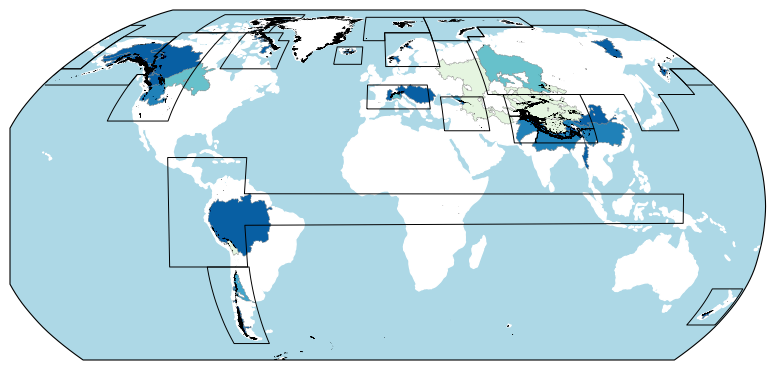

In [46]:
#%% ----- FIGURE: GLOBAL COMBINED -----
scenario = 'ssp245'

add_rgi_glaciers = True
add_rgi_regions = True

continuous_cmap = cm.GnBu
discrete_colors = continuous_cmap(np.linspace(0.1, 0.9, 8))
cmap = ListedColormap(discrete_colors)
perc_min = 20
perc_max = 100

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Note that I'm ignoring clipping and other edge cases here.
        result, is_scalar = self.process_value(value)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

rgi_reg_fig_dict = {'all':'Global (excl. A+G)',
                    1:'Alaska',
                    2:'W Canada & US',
                    3:'Arctic Canada N',
                    4:'Arctic Canada S',
                    5:'Greenland Periphery',
                    6:'Iceland',
                    7:'Svalbard',
                    8:'Scandinavia',
                    9:'Russian Arctic',
                    10:'North Asia',
                    11:'Central Europe',
                    12:'Caucasus &\nMiddle East',
                    13:'Central Asia',
                    14:'South Asia W',
                    15:'South Asia E',
                    16:'Low Latitudes',
                    17:'Southern\nAndes',
                    18:'New Zealand',
                    19:'Antarctic & Subantarctic'
                    }



fig = plt.figure()

# Add background image
ax_background = fig.add_axes([0,0.15,1,0.7], projection=ccrs.Robinson())
ax_background.patch.set_facecolor('lightblue')
ax_background.get_yaxis().set_visible(False)
ax_background.get_xaxis().set_visible(False)
ax_background.add_feature(cartopy.feature.LAND, color='white')

# # Add global boundary
# ax_global_patch = fig.add_axes([0.05,0.14,0.15,0.28], facecolor='lightblue')
# ax_global_patch.get_yaxis().set_visible(False)
# ax_global_patch.get_xaxis().set_visible(False)

# Add basins
gdf_plot = gdf_gt30km2.copy().to_crs(ccrs.Robinson().proj4_init)
gdf_plot['perc2ocean'] = 100*gdf_plot['DN'].map(basin_frac_dict[scenario])
gdf_plot['slr_mmSLE'] = gdf_plot['DN'].map(basin_contribution_dict[scenario])
gdf_plot = gdf_plot.loc[gdf_plot['slr_mmSLE'] > 0.01]
gdf_plot.plot(ax=ax_background, column='perc2ocean', cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='gray', linewidth=0.25)

# Add RGI glacier outlines
if add_rgi_glaciers:
    glac_color = 'k'
    shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor=glac_color,
                                   linewidth=0.1,edgecolor=glac_color)
    ax_background.add_feature(shape_feature)
    
if add_rgi_regions:
    gdf_rgiregs = gpd.read_file(rgi_regions_fn)
    gdf_rgiregs = gdf_rgiregs.to_crs(ccrs.Robinson().proj4_init)
    regions2include = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
    regions2include_idxs = []
    for x in np.arange(gdf_rgiregs.shape[0]):
        if gdf_rgiregs.loc[x, 'RGI_CODE'] in regions2include:
            regions2include_idxs.append(x)
    gdf_rgiregs = gdf_rgiregs.loc[regions2include_idxs,:]
    gdf_rgiregs.plot(ax=ax_background, facecolor='None', edgecolor='k', linewidth=0.7)

regions_ordered = ['all',1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
reg_pie_sizes = []
for reg in regions_ordered:

    if reg in ['all']:
        reg_supp_df_idxname = 'Global'
    else:
        reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
    
    reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
    
    pie_size_min = 0.07
    if reg_slr_cum_pie > 80:
        pie_size = 0.22
    elif reg_slr_cum_pie > 25:
        pie_size = 0.17
    elif reg_slr_cum_pie < 1:
        pie_size = pie_size_min
    else:
        pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.17 - pie_size_min)
    reg_pie_sizes.append(pie_size)

# ax0 = fig.add_axes([0.095,0.18,0.06,0.03], facecolor='none')
# ax1 = fig.add_axes([0.08,0.745,0.06,0.03], facecolor='none')
# ax2 = fig.add_axes([0.137,0.592,0.06,0.03], facecolor='none')
# ax3 = fig.add_axes([0.252,0.875,0.06,0.03], facecolor='none')
# ax4 = fig.add_axes([0.29,0.63,0.06,0.03], facecolor='none')
# ax6 = fig.add_axes([0.39,0.658,0.06,0.03], facecolor='none')
# ax7 = fig.add_axes([0.44,0.875,0.06,0.03], facecolor='none')
# ax8 = fig.add_axes([0.535,0.875,0.06,0.03], facecolor='none')
# ax9 = fig.add_axes([0.646,0.875,0.06,0.03], facecolor='none')
# ax10 = fig.add_axes([0.8,0.79,0.06,0.03], facecolor='none')
# ax11 = fig.add_axes([0.445,0.58,0.06,0.03], facecolor='none')
# ax12 = fig.add_axes([0.543,0.547,0.06,0.03], facecolor='none')
# ax13 = fig.add_axes([0.78,0.574,0.06,0.03], facecolor='none')
# ax14 = fig.add_axes([0.62,0.476,0.06,0.03], facecolor='none')
# ax15 = fig.add_axes([0.715,0.438,0.06,0.03], facecolor='none')
# ax16 = fig.add_axes([0.40,0.435,0.06,0.03], facecolor='none')
# ax17 = fig.add_axes([0.36,0.245,0.06,0.03], facecolor='none')
# ax18 = fig.add_axes([0.775,0.213,0.06,0.03], facecolor='none')

# # Pie charts
# ax0b = fig.add_axes([0.016,0.201,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none')
# ax1b = fig.add_axes([0.025,0.768,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none')
# ax2b = fig.add_axes([0.13,0.619,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none')
# ax3b = fig.add_axes([0.23,0.901,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none')
# ax4b = fig.add_axes([0.268,0.656,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none')
# ax6b = fig.add_axes([0.38,0.685,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none')
# ax7b = fig.add_axes([0.425,0.901,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none')
# ax8b = fig.add_axes([0.528,0.902,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none')
# ax9b = fig.add_axes([0.63,0.90,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none')
# ax10b = fig.add_axes([0.794,0.817,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none')
# ax11b = fig.add_axes([0.44,0.607,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none')
# ax12b = fig.add_axes([0.538,0.574,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none')
# ax13b = fig.add_axes([0.766,0.60,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none')
# ax14b = fig.add_axes([0.612,0.503,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none')
# ax15b = fig.add_axes([0.71,0.465,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none')
# ax16b = fig.add_axes([0.395,0.453,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none')
# ax17b = fig.add_axes([0.346,0.271,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none')
# ax18b = fig.add_axes([0.772,0.24,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none')

# # ----- Heat map of fraction reaching ocean (2015 - 2100) -----
# for nax, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9, ax10,
#                           ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]):

#     reg = regions_ordered[nax]

#     mesh = None
#     for hm_scenario in ['ssp126', 'ssp585']:

#         # Regional Fraction of SLR that directly reaches ocean
#         reg_slr = reg_annual_slr_mmSLE_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_perc_med = 100*np.median(reg_slr / reg_slr_raw, axis=0)
    
#         if mesh is None:
#             mesh = reg_perc_med[np.newaxis,:]
#         else:
#             mesh = np.concatenate((mesh, reg_perc_med[np.newaxis,:]), axis=0)
        
#     ax.imshow(mesh, aspect='auto', cmap=cmap, vmin=perc_min, vmax=perc_max, interpolation='none')
#     ax.set_xlim(0,85)
#     ax.hlines(0.5,0,mesh.shape[1]-1, color='k', linewidth=0.5, zorder=2)
#     ax.get_yaxis().set_visible(False)
#     ax.set_xticks([35,85])
#     ax.set_xticks(np.arange(5,81,10), minor=True)
#     ax.tick_params(axis='both', which='major', direction='in', length=3, right=True, top=True)
#     ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
#     ax.set_xticklabels([])
    
#     # Add region label
#     ax.text(0.5, -0.22, rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
#             verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))
    
# # ----- Pie Chart of Volume Remaining by end of century -----
# wedge_size = 0.22
# for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax6b, ax7b, ax8b, ax9b, ax10b,
#                           ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b]):
    
#     reg = regions_ordered[nax]
    
#     ssp_vol_remaining_pies = []
#     ssp_pie_radius = 1
#     scenario_groups = ['ssp126','ssp585']
#     for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
        
#         # Mass remaining at 2100, relative to 2015
#         mass_year_startidx = np.where(mass_years == 2015)[0][0]
#         if reg not in ['all']:
#             reg_mass_annual_med = np.median(reg_mass_dict[pie_scenario][reg][:,mass_year_startidx:],axis=0)
#         else:
#             all_mass_annual = None
#             for globreg in [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]:
#                 if all_mass_annual is None:
#                     all_mass_annual = reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
#                 else:
#                     all_mass_annual = all_mass_annual + reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
#             reg_mass_annual_med = np.median(all_mass_annual, axis=0)
                
#         mass_remaining = reg_mass_annual_med[-1] / reg_mass_annual_med[0]
#         ssp_vol_remaining_pies.append(mass_remaining)

#         if reg in ['all']:
#             reg_supp_df_idxname = 'Global'
#         else:
#             reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
#         reg_slr_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + pie_scenario]
#         reg_slr_red_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + pie_scenario]
#         frac_reduction = reg_slr_red_sum / reg_slr_sum
#         if frac_reduction < 0:
#             frac_reduction = 0
#         frac_remaining = 1 - frac_reduction

#         # Pie Charts
#         ssp_pies = [frac_remaining*(1-ssp_vol_remaining_pies[ngroup]),
#                     frac_reduction*(1-ssp_vol_remaining_pies[ngroup]),
#                     ssp_vol_remaining_pies[ngroup]]
#         ssp_pie_colors = [ssp_colordict[pie_scenario], ssp_colordict[pie_scenario], 'lightgray']
#         pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius,
#                                         counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                         wedgeprops=dict(width=wedge_size, linewidth=0.1, edgecolor='gray')
#                                        )
#         for i, pie_slice in enumerate(pie_slices):
#             if i == 2:
#                 pie_slice.set_edgecolor('gray')
#         for i, pie_slice in enumerate(pie_slices):
#             if i == 1:
#                 pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
#                 pie_slice.set_edgecolor('white')

#         ssp_pie_radius = ssp_pie_radius - wedge_size

#     ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
#     wedge_size_fill = ssp_pie_radius_fill
#     ssp_pies, ssp_pie_colors = [1], ['white'] # middle circle
#     pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius_fill,
#                                     counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                     wedgeprops=dict(width=wedge_size_fill))
#     ax.axis('equal')
    
#     # CENTER TEXT
#     if reg in ['all']:
#         reg_supp_df_idxname = 'Global'
#     else:
#         reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'

#     # # SLR contribution
#     # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
#     # # SLR lost
#     # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + scenario]
#     # if reg_slr_cum_pie > 1:
#     #     reg_slr_str = str(int(np.round(reg_slr_cum_pie)))
#     # else:
#     #     reg_slr_str = ''
#     # if reg in ['all']:
#     #     reg_slr_str += '\nmm SLE'
#     # ax.text(0.5, 0.5, reg_slr_str, size=10, color='k', horizontalalignment='center', 
#     #         verticalalignment='center', transform=ax.transAxes)
    
#     # Perc reaching ocean
#     reg_perc2ocean_pie = reg_supp_df.loc[reg_supp_df_idxname, '% SLR to ocean' + '-' + scenario]
#     reg_pie_str = str(int(np.round(reg_perc2ocean_pie)))
#     if not reg in ['all']:
#         ax.text(0.5, 0.5, reg_pie_str, size=8, color='k', horizontalalignment='center', 
#                 verticalalignment='center', transform=ax.transAxes)
#     else:
#         ax.text(0.5, 0.5, reg_pie_str + '%', size=10, color='k', horizontalalignment='center', 
#                 verticalalignment='center', transform=ax.transAxes)
        
    
#     # Add outer edge by adding new circle with desired properties
#     center = pie_slices[0].center
#     r = 1
#     circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=0.5)
#     ax.add_patch(circle)
    
    
# ----- LEGEND -----
# # PIE LEGEND
# ax_circle3 = fig.add_axes([0.492,-0.02,0.13,0.13], facecolor='none')
# ssp_vol_remaining_pies = [0.31, 0.41]
# frac_lost = 0.2
# ssp_pie_radius = 1
# for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
#     # Nested Pie Charts
#     ssp_pies = [(1-frac_lost)*(1-ssp_vol_remaining_pies[ngroup]),
#                 frac_lost*(1-ssp_vol_remaining_pies[ngroup]),
#                 ssp_vol_remaining_pies[ngroup]]
#     ssp_pie_colors = [ssp_colordict[pie_scenario], ssp_colordict[pie_scenario], 'lightgray']
#     pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius, 
#                                             counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                             wedgeprops=dict(width=wedge_size, linewidth=0.2, edgecolor='k'))
#     ssp_pie_radius = ssp_pie_radius - wedge_size

#     for i, pie_slice in enumerate(pie_slices):
#         if i == 2:
#             pie_slice.set_edgecolor('gray')
#     for i, pie_slice in enumerate(pie_slices):
#         if i == 1:
#             pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
#             pie_slice.set_edgecolor('white')
    
# ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
# wedge_size_fill = ssp_pie_radius_fill
# ssp_pies, ssp_pie_colors = [1], ['white']
# pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius_fill, 
#                                         counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                         wedgeprops=dict(width=wedge_size_fill))
# ax_circle3.axis('equal')

# center = pie_slices[0].center
# r = 1
# circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=1)
# ax_circle3.add_patch(circle)
# ax_circle3.text(0.2,0.21,'SSP5-8.5', color=ssp_colordict['ssp585'], size=8, 
#                 ha='right', transform=ax_circle3.transAxes)
# ax_circle3.text(0.26,0.01,'SSP1-2.6', color=ssp_colordict['ssp126'], size=8, 
#                 ha='right', transform=ax_circle3.transAxes)

# ax_background.text(0.63,-0.05,'Mass Loss at 2100 (rel. to 2015)', size=10, 
#                    ha='center', transform=ax_background.transAxes)

# # hatch description
# ax_hatchleg = fig.add_axes([0.57,0.045,0.05,0.05], facecolor='none')
# hatch_rect1 = patches.Rectangle((0.6, 0.0), 0.4, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp126'], clip_on=False)
# hatch_rect2 = patches.Rectangle((0.8, 0.0), 0.2, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp585'], clip_on=False)
# hatch_rect3 = patches.Rectangle((0.62, 0.02), 0.36, 0.36, linewidth=0.5, edgecolor='white', facecolor='none', 
#                                 hatch='xxxxxxxx', clip_on=False)
# ax_hatchleg.add_patch(hatch_rect1)
# ax_hatchleg.add_patch(hatch_rect2)
# ax_hatchleg.add_patch(hatch_rect3)
# ax_hatchleg.set_axis_off()
# ax_hatchleg.text(1.05,0.18,'Not directly reaching ocean', size=8, ha='left', va='center', transform=ax_hatchleg.transAxes)

# solid_rect1 = patches.Rectangle((0.6, 0.5), 0.4, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp126'], clip_on=False)
# solid_rect2 = patches.Rectangle((0.8, 0.5), 0.2, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp585'], clip_on=False)
# ax_hatchleg.add_patch(solid_rect1)
# ax_hatchleg.add_patch(solid_rect2)
# ax_hatchleg.set_axis_off()
# ax_hatchleg.text(1.05,0.67,'Directly reaching ocean', size=8, ha='left', va='center', transform=ax_hatchleg.transAxes)

# ax_hatchleg.text(-1.1, 0.65,'Mass\nremaining', color='gray', size=7, ha='right', va='center', transform=ax_hatchleg.transAxes)
# ax_pointer = fig.add_axes([0.565,0.045,0.05,0.05], facecolor='none')
# ax_pointer.plot([-0.7, -0.95], [0.5, 0.65], color='grey', linewidth=0.75, clip_on=False)
# ax_pointer.set_xlim(0,1)
# ax_pointer.set_ylim(0,1)
# ax_pointer.set_axis_off()

# # HEATMAP LEGEND
# ax_background.text(0.20,-0.06,'Glacier Runoff Directly Reaching Ocean (%)', size=10, 
#                    horizontalalignment='center', transform=ax_background.transAxes)
# ax_heatmap = fig.add_axes([0.06,0.03,0.1,0.06], facecolor='none')
# ax_heatmap.hlines(0.5,2015,2100, color='k', linewidth=0.5, zorder=2)
# ax_heatmap.set_ylim(0,1)
# ax_heatmap.set_xlim(2015,2100)
# ax_heatmap.get_yaxis().set_visible(False)
# ax_heatmap.xaxis.set_major_locator(MultipleLocator(40))
# ax_heatmap.xaxis.set_minor_locator(MultipleLocator(10))
# ax_heatmap.set_xticks(ticks=[2050, 2100])
# ax_heatmap.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
# ax_heatmap.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
# ax_heatmap.text(0.5,0.71,'SSP1-2.6', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)
# ax_heatmap.text(0.5,0.21,'SSP5-8.5', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)

# # Heat map colorbar
# # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=perc_min, vmax=perc_max))
# sm._A = []
# cax = plt.axes([0.19, 0.06, 0.22, 0.015])
# cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='horizontal', extend='min')
# cax.xaxis.set_ticks_position('bottom')
# cax.xaxis.set_tick_params(pad=2)
# cbar.ax.tick_params(labelsize=8)

# # PIE SIZE LEGEND
# ax_background.text(0.9,-0.05,'mm SLE', size=10, 
#                    ha='center', transform=ax_background.transAxes)
# pie_size = 0.128 # 15 mm SLE
# ax_piesizea = fig.add_axes([0.78,-0.025,pie_size,pie_size], facecolor='none')
# center = (0.5, 0)
# circle = mpl.patches.Circle(center, pie_size, fill=False, edgecolor="k", linewidth=0.5, clip_on=False)
# ax_piesizea.add_patch(circle)
# ax_piesizea.axis('equal')
# ax_piesizea.set_axis_off()

# pie_size = pie_size_min # 1 mm SLE
# ax_piesizeb = fig.add_axes([0.809,-0.022,pie_size,pie_size], facecolor='none')
# center = (0.5, 0)
# circle = mpl.patches.Circle(center, pie_size, fill=False, edgecolor="k", linewidth=0.5, clip_on=False)
# ax_piesizeb.add_patch(circle)
# ax_piesizeb.axis('equal')
# ax_piesizeb.set_axis_off()

# ax_pointer2 = fig.add_axes([0.78,-0.025,0.1,0.1], facecolor='none')
# ax_pointer2.plot([0.62, 1.2], [1.238, 1.238], color='gray', linewidth=0.75, clip_on=False)
# ax_pointer2.plot([0.62, 1.2], [0.72, 0.72], color='gray', linewidth=0.75, clip_on=False)
# ax_pointer2.text(1.2, 1.21, '15', size=8, ha='center', va='top', transform=ax_pointer2.transAxes)
# ax_pointer2.text(1.2, 0.70, '< 1', size=8, ha='center', va='top', transform=ax_pointer2.transAxes)
# ax_pointer2.set_xlim(0,1)
# ax_pointer2.set_ylim(0,1)
# ax_pointer2.set_axis_off()

# Save figure
fig.set_size_inches(8.5,5)
fig.savefig(fig_fp + 'Fig2b_map_slr_frac-' + scenario + '-nopies.png', dpi=300, bbox_inches='tight')

plt.show()

### Remove just numbers in disc

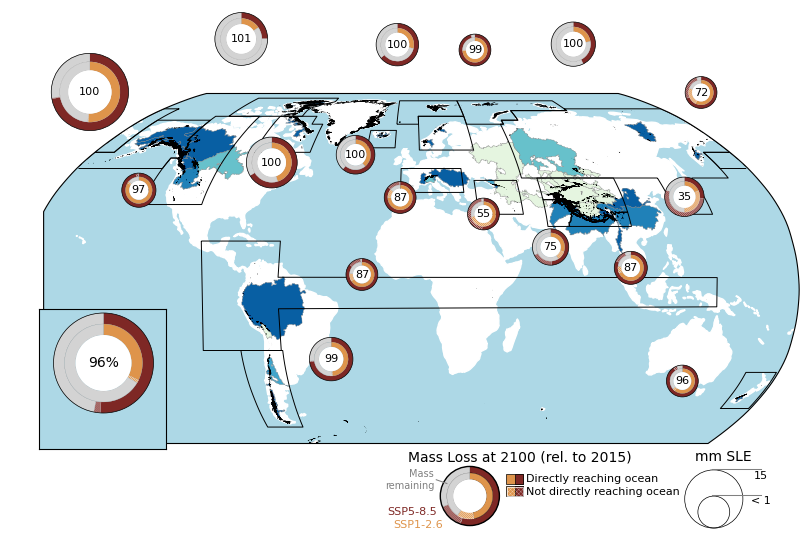

In [48]:
#%% ----- FIGURE: GLOBAL COMBINED -----
scenario = 'ssp245'

add_rgi_glaciers = True
add_rgi_regions = True

continuous_cmap = cm.GnBu
discrete_colors = continuous_cmap(np.linspace(0.1, 0.9, 8))
cmap = ListedColormap(discrete_colors)
perc_min = 20
perc_max = 100

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Note that I'm ignoring clipping and other edge cases here.
        result, is_scalar = self.process_value(value)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

rgi_reg_fig_dict = {'all':'Global (excl. A+G)',
                    1:'Alaska',
                    2:'W Canada & US',
                    3:'Arctic Canada N',
                    4:'Arctic Canada S',
                    5:'Greenland Periphery',
                    6:'Iceland',
                    7:'Svalbard',
                    8:'Scandinavia',
                    9:'Russian Arctic',
                    10:'North Asia',
                    11:'Central Europe',
                    12:'Caucasus &\nMiddle East',
                    13:'Central Asia',
                    14:'South Asia W',
                    15:'South Asia E',
                    16:'Low Latitudes',
                    17:'Southern\nAndes',
                    18:'New Zealand',
                    19:'Antarctic & Subantarctic'
                    }



fig = plt.figure()

# Add background image
ax_background = fig.add_axes([0,0.15,1,0.7], projection=ccrs.Robinson())
ax_background.patch.set_facecolor('lightblue')
ax_background.get_yaxis().set_visible(False)
ax_background.get_xaxis().set_visible(False)
ax_background.add_feature(cartopy.feature.LAND, color='white')

# Add global boundary
ax_global_patch = fig.add_axes([0.05,0.14,0.15,0.28], facecolor='lightblue')
ax_global_patch.get_yaxis().set_visible(False)
ax_global_patch.get_xaxis().set_visible(False)

# Add basins
gdf_plot = gdf_gt30km2.copy().to_crs(ccrs.Robinson().proj4_init)
gdf_plot['perc2ocean'] = 100*gdf_plot['DN'].map(basin_frac_dict[scenario])
gdf_plot['slr_mmSLE'] = gdf_plot['DN'].map(basin_contribution_dict[scenario])
gdf_plot = gdf_plot.loc[gdf_plot['slr_mmSLE'] > 0.01]
gdf_plot.plot(ax=ax_background, column='perc2ocean', cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='gray', linewidth=0.25)

# Add RGI glacier outlines
if add_rgi_glaciers:
    glac_color = 'k'
    shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor=glac_color,
                                   linewidth=0.1,edgecolor=glac_color)
    ax_background.add_feature(shape_feature)
    
if add_rgi_regions:
    gdf_rgiregs = gpd.read_file(rgi_regions_fn)
    gdf_rgiregs = gdf_rgiregs.to_crs(ccrs.Robinson().proj4_init)
    regions2include = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
    regions2include_idxs = []
    for x in np.arange(gdf_rgiregs.shape[0]):
        if gdf_rgiregs.loc[x, 'RGI_CODE'] in regions2include:
            regions2include_idxs.append(x)
    gdf_rgiregs = gdf_rgiregs.loc[regions2include_idxs,:]
    gdf_rgiregs.plot(ax=ax_background, facecolor='None', edgecolor='k', linewidth=0.7)

regions_ordered = ['all',1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
reg_pie_sizes = []
for reg in regions_ordered:

    if reg in ['all']:
        reg_supp_df_idxname = 'Global'
    else:
        reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
    
    reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
    
    pie_size_min = 0.07
    if reg_slr_cum_pie > 80:
        pie_size = 0.22
    elif reg_slr_cum_pie > 25:
        pie_size = 0.17
    elif reg_slr_cum_pie < 1:
        pie_size = pie_size_min
    else:
        pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.17 - pie_size_min)
    reg_pie_sizes.append(pie_size)

# ax0 = fig.add_axes([0.095,0.18,0.06,0.03], facecolor='none')
# ax1 = fig.add_axes([0.08,0.745,0.06,0.03], facecolor='none')
# ax2 = fig.add_axes([0.137,0.592,0.06,0.03], facecolor='none')
# ax3 = fig.add_axes([0.252,0.875,0.06,0.03], facecolor='none')
# ax4 = fig.add_axes([0.29,0.63,0.06,0.03], facecolor='none')
# ax6 = fig.add_axes([0.39,0.658,0.06,0.03], facecolor='none')
# ax7 = fig.add_axes([0.44,0.875,0.06,0.03], facecolor='none')
# ax8 = fig.add_axes([0.535,0.875,0.06,0.03], facecolor='none')
# ax9 = fig.add_axes([0.646,0.875,0.06,0.03], facecolor='none')
# ax10 = fig.add_axes([0.8,0.79,0.06,0.03], facecolor='none')
# ax11 = fig.add_axes([0.445,0.58,0.06,0.03], facecolor='none')
# ax12 = fig.add_axes([0.543,0.547,0.06,0.03], facecolor='none')
# ax13 = fig.add_axes([0.78,0.574,0.06,0.03], facecolor='none')
# ax14 = fig.add_axes([0.62,0.476,0.06,0.03], facecolor='none')
# ax15 = fig.add_axes([0.715,0.438,0.06,0.03], facecolor='none')
# ax16 = fig.add_axes([0.40,0.435,0.06,0.03], facecolor='none')
# ax17 = fig.add_axes([0.36,0.245,0.06,0.03], facecolor='none')
# ax18 = fig.add_axes([0.775,0.213,0.06,0.03], facecolor='none')

# Pie charts
ax0b = fig.add_axes([0.016,0.201,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none')
ax1b = fig.add_axes([0.025,0.768,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none')
ax2b = fig.add_axes([0.13,0.619,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none')
ax3b = fig.add_axes([0.23,0.901,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none')
ax4b = fig.add_axes([0.268,0.656,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none')
ax6b = fig.add_axes([0.38,0.685,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none')
ax7b = fig.add_axes([0.425,0.901,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none')
ax8b = fig.add_axes([0.528,0.902,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none')
ax9b = fig.add_axes([0.63,0.90,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none')
ax10b = fig.add_axes([0.794,0.817,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none')
ax11b = fig.add_axes([0.44,0.607,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none')
ax12b = fig.add_axes([0.538,0.574,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none')
ax13b = fig.add_axes([0.766,0.60,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none')
ax14b = fig.add_axes([0.612,0.503,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none')
ax15b = fig.add_axes([0.71,0.465,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none')
ax16b = fig.add_axes([0.395,0.453,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none')
ax17b = fig.add_axes([0.346,0.271,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none')
ax18b = fig.add_axes([0.772,0.24,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none')

# ----- Heat map of fraction reaching ocean (2015 - 2100) -----
# for nax, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9, ax10,
#                           ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]):

#     reg = regions_ordered[nax]

#     mesh = None
#     for hm_scenario in ['ssp126', 'ssp585']:

#         # Regional Fraction of SLR that directly reaches ocean
#         reg_slr = reg_annual_slr_mmSLE_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_perc_med = 100*np.median(reg_slr / reg_slr_raw, axis=0)
    
#         if mesh is None:
#             mesh = reg_perc_med[np.newaxis,:]
#         else:
#             mesh = np.concatenate((mesh, reg_perc_med[np.newaxis,:]), axis=0)
        
#     ax.imshow(mesh, aspect='auto', cmap=cmap, vmin=perc_min, vmax=perc_max, interpolation='none')
#     ax.set_xlim(0,85)
#     ax.hlines(0.5,0,mesh.shape[1]-1, color='k', linewidth=0.5, zorder=2)
#     ax.get_yaxis().set_visible(False)
#     ax.set_xticks([35,85])
#     ax.set_xticks(np.arange(5,81,10), minor=True)
#     ax.tick_params(axis='both', which='major', direction='in', length=3, right=True, top=True)
#     ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
#     ax.set_xticklabels([])
    
#     # Add region label
#     ax.text(0.5, -0.22, rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
#             verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))
    
# ----- Pie Chart of Volume Remaining by end of century -----
wedge_size = 0.22
for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax6b, ax7b, ax8b, ax9b, ax10b,
                          ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b]):
    
    reg = regions_ordered[nax]
    
    ssp_vol_remaining_pies = []
    ssp_pie_radius = 1
    scenario_groups = ['ssp126','ssp585']
    for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
        
        # Mass remaining at 2100, relative to 2015
        mass_year_startidx = np.where(mass_years == 2015)[0][0]
        if reg not in ['all']:
            reg_mass_annual_med = np.median(reg_mass_dict[pie_scenario][reg][:,mass_year_startidx:],axis=0)
        else:
            all_mass_annual = None
            for globreg in [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]:
                if all_mass_annual is None:
                    all_mass_annual = reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
                else:
                    all_mass_annual = all_mass_annual + reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
            reg_mass_annual_med = np.median(all_mass_annual, axis=0)
                
        mass_remaining = reg_mass_annual_med[-1] / reg_mass_annual_med[0]
        ssp_vol_remaining_pies.append(mass_remaining)

        if reg in ['all']:
            reg_supp_df_idxname = 'Global'
        else:
            reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
        reg_slr_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + pie_scenario]
        reg_slr_red_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + pie_scenario]
        frac_reduction = reg_slr_red_sum / reg_slr_sum
        if frac_reduction < 0:
            frac_reduction = 0
        frac_remaining = 1 - frac_reduction

        # Pie Charts
        ssp_pies = [frac_remaining*(1-ssp_vol_remaining_pies[ngroup]),
                    frac_reduction*(1-ssp_vol_remaining_pies[ngroup]),
                    ssp_vol_remaining_pies[ngroup]]
        ssp_pie_colors = [ssp_colordict[pie_scenario], ssp_colordict[pie_scenario], 'lightgray']
        pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius,
                                        counterclock=False, startangle=90, colors=ssp_pie_colors,
                                        wedgeprops=dict(width=wedge_size, linewidth=0.1, edgecolor='gray')
                                       )
        for i, pie_slice in enumerate(pie_slices):
            if i == 2:
                pie_slice.set_edgecolor('gray')
        for i, pie_slice in enumerate(pie_slices):
            if i == 1:
                pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
                pie_slice.set_edgecolor('white')

        ssp_pie_radius = ssp_pie_radius - wedge_size

    ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
    wedge_size_fill = ssp_pie_radius_fill
    ssp_pies, ssp_pie_colors = [1], ['white'] # middle circle
    pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius_fill,
                                    counterclock=False, startangle=90, colors=ssp_pie_colors,
                                    wedgeprops=dict(width=wedge_size_fill))
    ax.axis('equal')
    
    # CENTER TEXT
    if reg in ['all']:
        reg_supp_df_idxname = 'Global'
    else:
        reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'

    # # SLR contribution
    # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
    # # SLR lost
    # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + scenario]
    # if reg_slr_cum_pie > 1:
    #     reg_slr_str = str(int(np.round(reg_slr_cum_pie)))
    # else:
    #     reg_slr_str = ''
    # if reg in ['all']:
    #     reg_slr_str += '\nmm SLE'
    # ax.text(0.5, 0.5, reg_slr_str, size=10, color='k', horizontalalignment='center', 
    #         verticalalignment='center', transform=ax.transAxes)
    
    # Perc reaching ocean
    reg_perc2ocean_pie = reg_supp_df.loc[reg_supp_df_idxname, '% SLR to ocean' + '-' + scenario]
    reg_pie_str = str(int(np.round(reg_perc2ocean_pie)))
    if not reg in ['all']:
        ax.text(0.5, 0.5, reg_pie_str, size=8, color='k', horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, reg_pie_str + '%', size=10, color='k', horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)
        
    
    # Add outer edge by adding new circle with desired properties
    center = pie_slices[0].center
    r = 1
    circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=0.5)
    ax.add_patch(circle)
    
    
# ----- LEGEND -----
# PIE LEGEND
ax_circle3 = fig.add_axes([0.492,-0.02,0.13,0.13], facecolor='none')
ssp_vol_remaining_pies = [0.31, 0.41]
frac_lost = 0.2
ssp_pie_radius = 1
for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
    # Nested Pie Charts
    ssp_pies = [(1-frac_lost)*(1-ssp_vol_remaining_pies[ngroup]),
                frac_lost*(1-ssp_vol_remaining_pies[ngroup]),
                ssp_vol_remaining_pies[ngroup]]
    ssp_pie_colors = [ssp_colordict[pie_scenario], ssp_colordict[pie_scenario], 'lightgray']
    pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius, 
                                            counterclock=False, startangle=90, colors=ssp_pie_colors,
                                            wedgeprops=dict(width=wedge_size, linewidth=0.2, edgecolor='k'))
    ssp_pie_radius = ssp_pie_radius - wedge_size

    for i, pie_slice in enumerate(pie_slices):
        if i == 2:
            pie_slice.set_edgecolor('gray')
    for i, pie_slice in enumerate(pie_slices):
        if i == 1:
            pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
            pie_slice.set_edgecolor('white')
    
ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
wedge_size_fill = ssp_pie_radius_fill
ssp_pies, ssp_pie_colors = [1], ['white']
pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius_fill, 
                                        counterclock=False, startangle=90, colors=ssp_pie_colors,
                                        wedgeprops=dict(width=wedge_size_fill))
ax_circle3.axis('equal')

center = pie_slices[0].center
r = 1
circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=1)
ax_circle3.add_patch(circle)
ax_circle3.text(0.2,0.21,'SSP5-8.5', color=ssp_colordict['ssp585'], size=8, 
                ha='right', transform=ax_circle3.transAxes)
ax_circle3.text(0.26,0.01,'SSP1-2.6', color=ssp_colordict['ssp126'], size=8, 
                ha='right', transform=ax_circle3.transAxes)

ax_background.text(0.63,-0.05,'Mass Loss at 2100 (rel. to 2015)', size=10, 
                   ha='center', transform=ax_background.transAxes)

# hatch description
ax_hatchleg = fig.add_axes([0.57,0.045,0.05,0.05], facecolor='none')
hatch_rect1 = patches.Rectangle((0.6, 0.0), 0.4, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp126'], clip_on=False)
hatch_rect2 = patches.Rectangle((0.8, 0.0), 0.2, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp585'], clip_on=False)
hatch_rect3 = patches.Rectangle((0.62, 0.02), 0.36, 0.36, linewidth=0.5, edgecolor='white', facecolor='none', 
                                hatch='xxxxxxxx', clip_on=False)
ax_hatchleg.add_patch(hatch_rect1)
ax_hatchleg.add_patch(hatch_rect2)
ax_hatchleg.add_patch(hatch_rect3)
ax_hatchleg.set_axis_off()
ax_hatchleg.text(1.05,0.18,'Not directly reaching ocean', size=8, ha='left', va='center', transform=ax_hatchleg.transAxes)

solid_rect1 = patches.Rectangle((0.6, 0.5), 0.4, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp126'], clip_on=False)
solid_rect2 = patches.Rectangle((0.8, 0.5), 0.2, 0.4, linewidth=0.5, edgecolor='k', facecolor=ssp_colordict['ssp585'], clip_on=False)
ax_hatchleg.add_patch(solid_rect1)
ax_hatchleg.add_patch(solid_rect2)
ax_hatchleg.set_axis_off()
ax_hatchleg.text(1.05,0.67,'Directly reaching ocean', size=8, ha='left', va='center', transform=ax_hatchleg.transAxes)

ax_hatchleg.text(-1.1, 0.65,'Mass\nremaining', color='gray', size=7, ha='right', va='center', transform=ax_hatchleg.transAxes)
ax_pointer = fig.add_axes([0.565,0.045,0.05,0.05], facecolor='none')
ax_pointer.plot([-0.7, -0.95], [0.5, 0.65], color='grey', linewidth=0.75, clip_on=False)
ax_pointer.set_xlim(0,1)
ax_pointer.set_ylim(0,1)
ax_pointer.set_axis_off()

# # HEATMAP LEGEND
# ax_background.text(0.20,-0.06,'Glacier Runoff Directly Reaching Ocean (%)', size=10, 
#                    horizontalalignment='center', transform=ax_background.transAxes)
# ax_heatmap = fig.add_axes([0.06,0.03,0.1,0.06], facecolor='none')
# ax_heatmap.hlines(0.5,2015,2100, color='k', linewidth=0.5, zorder=2)
# ax_heatmap.set_ylim(0,1)
# ax_heatmap.set_xlim(2015,2100)
# ax_heatmap.get_yaxis().set_visible(False)
# ax_heatmap.xaxis.set_major_locator(MultipleLocator(40))
# ax_heatmap.xaxis.set_minor_locator(MultipleLocator(10))
# ax_heatmap.set_xticks(ticks=[2050, 2100])
# ax_heatmap.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
# ax_heatmap.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
# ax_heatmap.text(0.5,0.71,'SSP1-2.6', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)
# ax_heatmap.text(0.5,0.21,'SSP5-8.5', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)

# # Heat map colorbar
# # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=perc_min, vmax=perc_max))
# sm._A = []
# cax = plt.axes([0.19, 0.06, 0.22, 0.015])
# cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='horizontal', extend='min')
# cax.xaxis.set_ticks_position('bottom')
# cax.xaxis.set_tick_params(pad=2)
# cbar.ax.tick_params(labelsize=8)

# PIE SIZE LEGEND
ax_background.text(0.9,-0.05,'mm SLE', size=10, 
                   ha='center', transform=ax_background.transAxes)
pie_size = 0.128 # 15 mm SLE
ax_piesizea = fig.add_axes([0.78,-0.025,pie_size,pie_size], facecolor='none')
center = (0.5, 0)
circle = mpl.patches.Circle(center, pie_size, fill=False, edgecolor="k", linewidth=0.5, clip_on=False)
ax_piesizea.add_patch(circle)
ax_piesizea.axis('equal')
ax_piesizea.set_axis_off()

pie_size = pie_size_min # 1 mm SLE
ax_piesizeb = fig.add_axes([0.809,-0.022,pie_size,pie_size], facecolor='none')
center = (0.5, 0)
circle = mpl.patches.Circle(center, pie_size, fill=False, edgecolor="k", linewidth=0.5, clip_on=False)
ax_piesizeb.add_patch(circle)
ax_piesizeb.axis('equal')
ax_piesizeb.set_axis_off()

ax_pointer2 = fig.add_axes([0.78,-0.025,0.1,0.1], facecolor='none')
ax_pointer2.plot([0.62, 1.2], [1.238, 1.238], color='gray', linewidth=0.75, clip_on=False)
ax_pointer2.plot([0.62, 1.2], [0.72, 0.72], color='gray', linewidth=0.75, clip_on=False)
ax_pointer2.text(1.2, 1.21, '15', size=8, ha='center', va='top', transform=ax_pointer2.transAxes)
ax_pointer2.text(1.2, 0.70, '< 1', size=8, ha='center', va='top', transform=ax_pointer2.transAxes)
ax_pointer2.set_xlim(0,1)
ax_pointer2.set_ylim(0,1)
ax_pointer2.set_axis_off()

# Save figure
fig.set_size_inches(8.5,5)
fig.savefig(fig_fp + 'Fig2c_map_slr_frac-' + scenario + '-noheatmap.png', dpi=300, bbox_inches='tight')

plt.show()

### Larger pie charts and bar charts

In [ ]:
# #%% ----- FIGURE: GLOBAL COMBINED -----
# scenario = 'ssp245'

# add_rgi_glaciers = True
# add_rgi_regions = True

# rgi_shp_fn = '/Users/drounce/Documents/HiMAT/PyGEM-analysis/wbm_results/qgis/rgi60_all_simplified2_robinson.shp'
# rgi_regions_fn = '/Users/drounce/Documents/HiMAT/PyGEM-analysis/wbm_results/qgis/rgi60_regions_robinson-v2.shp'

# continuous_cmap = cm.GnBu
# discrete_colors = continuous_cmap(np.linspace(0.1, 0.9, 8))
# cmap = ListedColormap(discrete_colors)
# perc_min = 20
# perc_max = 100

# class MidpointNormalize(mpl.colors.Normalize):
#     def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
#         self.midpoint = midpoint
#         mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

#     def __call__(self, value, clip=None):
#         # Note that I'm ignoring clipping and other edge cases here.
#         result, is_scalar = self.process_value(value)
#         x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
#         return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

# rgi_reg_fig_dict = {'all':'Global (excl. A+G)',
#                     1:'Alaska',
#                     2:'W Canada\n& US',
#                     3:'Arctic Canada\nNorth',
#                     4:'Arctic Canada\nSouth',
#                     5:'Greenland Periphery',
#                     6:'Iceland',
#                     7:'Svalbard',
#                     8:'Scandinavia',
#                     9:'Russian Arctic',
#                     10:'North Asia',
#                     11:'Central Europe',
#                     12:'Caucasus &\nMiddle East',
#                     13:'Central Asia',
#                     14:'South Asia\nWest',
#                     15:'South Asia\nEast',
#                     16:'Low Latitudes',
#                     17:'Southern\nAndes',
#                     18:'New Zealand',
#                     19:'Antarctic & Subantarctic'
#                     }



# fig = plt.figure()

# # Add background image
# ax_background = fig.add_axes([0,0.15,1,0.7], projection=ccrs.Robinson())
# ax_background.patch.set_facecolor('lightblue')
# ax_background.get_yaxis().set_visible(False)
# ax_background.get_xaxis().set_visible(False)
# ax_background.add_feature(cartopy.feature.LAND, color='white')

# # Add global boundary
# ax_global_patch = fig.add_axes([0.05,0.145,0.19,0.38], facecolor='lightblue')
# ax_global_patch.get_yaxis().set_visible(False)
# ax_global_patch.get_xaxis().set_visible(False)

# # Add basins
# gdf_plot = gdf_gt30km2.copy().to_crs(ccrs.Robinson().proj4_init)
# gdf_plot['perc2ocean'] = 100*gdf_plot['DN'].map(basin_frac_dict[scenario])
# gdf_plot['slr_mmSLE'] = gdf_plot['DN'].map(basin_contribution_dict[scenario])
# gdf_plot = gdf_plot.loc[gdf_plot['slr_mmSLE'] > 0.01]
# gdf_plot.plot(ax=ax_background, column='perc2ocean', cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='gray', linewidth=0.25)

# # Add RGI glacier outlines
# if add_rgi_glaciers:
#     glac_color = 'k'
#     shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor=glac_color,
#                                    linewidth=0.1,edgecolor=glac_color)
#     ax_background.add_feature(shape_feature)
    
# if add_rgi_regions:
#     gdf_rgiregs = gpd.read_file(rgi_regions_fn)
#     gdf_rgiregs = gdf_rgiregs.to_crs(ccrs.Robinson().proj4_init)
#     regions2include = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
#     regions2include_idxs = []
#     for x in np.arange(gdf_rgiregs.shape[0]):
#         if gdf_rgiregs.loc[x, 'RGI_CODE'] in regions2include:
#             regions2include_idxs.append(x)
#     gdf_rgiregs = gdf_rgiregs.loc[regions2include_idxs,:]
#     gdf_rgiregs.plot(ax=ax_background, facecolor='None', edgecolor='k', linewidth=0.35)

# regions_ordered = ['all',1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
# reg_pie_sizes = []
# for reg in regions_ordered:

#     if reg in ['all']:
#         reg_supp_df_idxname = 'Global'
#     else:
#         reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
    
#     reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
    
#     pie_size_min = 0.07
#     if reg_slr_cum_pie > 80:
#         pie_size = 0.33
#     elif reg_slr_cum_pie > 25:
#         pie_size = 0.2
#     elif reg_slr_cum_pie < 1:
#         pie_size = pie_size_min
#     else:
#         pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.2 - pie_size_min)
#     reg_pie_sizes.append(pie_size)

# ax0 = fig.add_axes([0.095,0.18,0.1,0.04], facecolor='none')
# ax1 = fig.add_axes([0.045,0.73,0.1,0.04], facecolor='none')
# ax2 = fig.add_axes([0.09,0.59,0.1,0.04], facecolor='none')
# ax3 = fig.add_axes([0.23,0.875,0.1,0.04], facecolor='none')
# ax4 = fig.add_axes([0.265,0.60,0.1,0.04], facecolor='none')
# ax6 = fig.add_axes([0.37,0.63,0.1,0.04], facecolor='none')
# ax7 = fig.add_axes([0.395,0.875,0.1,0.04], facecolor='none')
# ax8 = fig.add_axes([0.513,0.875,0.1,0.04], facecolor='none')
# ax9 = fig.add_axes([0.63,0.875,0.1,0.04], facecolor='none')
# ax10 = fig.add_axes([0.8,0.78,0.1,0.04], facecolor='none')
# ax11 = fig.add_axes([0.44,0.55,0.1,0.04], facecolor='none')
# ax12 = fig.add_axes([0.55,0.505,0.1,0.04], facecolor='none')
# ax13 = fig.add_axes([0.8,0.62,0.1,0.04], facecolor='none')
# ax14 = fig.add_axes([0.655,0.445,0.1,0.04], facecolor='none')
# ax15 = fig.add_axes([0.77,0.47,0.1,0.04], facecolor='none')
# ax16 = fig.add_axes([0.445,0.40,0.1,0.04], facecolor='none')
# ax17 = fig.add_axes([0.34,0.245,0.1,0.04], facecolor='none')
# ax18 = fig.add_axes([0.76,0.25,0.1,0.04], facecolor='none')

# # Pie charts
# ax0b = fig.add_axes([-0.02,0.205,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none')
# ax1b = fig.add_axes([-0.005,0.762,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none')
# ax2b = fig.add_axes([0.103,0.628,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none')
# ax3b = fig.add_axes([0.215,0.91,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none')
# ax4b = fig.add_axes([0.255,0.635,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none')
# ax6b = fig.add_axes([0.38,0.667,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none')
# ax7b = fig.add_axes([0.40,0.91,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none')
# ax8b = fig.add_axes([0.526,0.912,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none')
# ax9b = fig.add_axes([0.63,0.91,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none')
# ax10b = fig.add_axes([0.818,0.817,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none')
# ax11b = fig.add_axes([0.455,0.587,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none')
# ax12b = fig.add_axes([0.566,0.543,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none')
# ax13b = fig.add_axes([0.81,0.656,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none')
# ax14b = fig.add_axes([0.668,0.482,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none')
# ax15b = fig.add_axes([0.783,0.508,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none')
# ax16b = fig.add_axes([0.46,0.438,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none')
# ax17b = fig.add_axes([0.335,0.281,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none')
# ax18b = fig.add_axes([0.777,0.287,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none')

# # ----- Heat map of fraction reaching ocean (2015 - 2100) -----
# for nax, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9, ax10,
#                           ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]):

#     reg = regions_ordered[nax]

#     mesh = None
#     for hm_scenario in ['ssp245', 'ssp585']:

#         # Regional Fraction of SLR that directly reaches ocean
#         reg_slr = reg_annual_slr_mmSLE_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_perc_med = 100*np.median(reg_slr / reg_slr_raw, axis=0)
    
#         if mesh is None:
#             mesh = reg_perc_med[np.newaxis,:]
#         else:
#             mesh = np.concatenate((mesh, reg_perc_med[np.newaxis,:]), axis=0)
        
#     ax.imshow(mesh, aspect='auto', cmap=cmap, vmin=perc_min, vmax=perc_max, interpolation='none')
#     # ax.imshow(mesh, aspect='auto', cmap=cmap, norm=norm, interpolation='none')
#     ax.hlines(0.5,0,mesh.shape[1]-1, color='k', linewidth=0.5, zorder=2)
#     ax.get_yaxis().set_visible(False)
# #        ax.get_xaxis().set_visible(False)
#     ax.xaxis.set_major_locator(MultipleLocator(40))
#     ax.xaxis.set_minor_locator(MultipleLocator(10))
#     ax.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
#     ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
#     ax.get_xaxis().set_ticks([])
    
#     # Add region label
#     ax.text(0.5, -0.14, rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
#             verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))
    
# # ----- Pie Chart of Volume Remaining by end of century -----
# wedge_size = 0.125
# for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax6b, ax7b, ax8b, ax9b, ax10b,
#                           ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b]):
    
#     reg = regions_ordered[nax]
    
#     ssp_vol_remaining_pies = []
#     ssp_pie_radius = 1
#     scenario_groups = ['ssp126','ssp245','ssp370','ssp585']
#     for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
        
#         # Mass remaining at 2100, relative to 2015
#         mass_year_startidx = np.where(mass_years == 2015)[0][0]
#         if reg not in ['all']:
#             reg_mass_annual_med = np.median(reg_mass_dict[pie_scenario][reg][:,mass_year_startidx:],axis=0)
#         else:
#             all_mass_annual = None
#             for globreg in [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]:
#                 if all_mass_annual is None:
#                     all_mass_annual = reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
#                 else:
#                     all_mass_annual = all_mass_annual + reg_mass_dict[pie_scenario][globreg][:,mass_year_startidx:]
#             reg_mass_annual_med = np.median(all_mass_annual, axis=0)
                
#         mass_remaining = reg_mass_annual_med[-1] / reg_mass_annual_med[0]
#         ssp_vol_remaining_pies.append(mass_remaining)

#         if reg in ['all']:
#             reg_supp_df_idxname = 'Global'
#         else:
#             reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
#         reg_slr_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + pie_scenario]
#         reg_slr_red_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + pie_scenario]
#         frac_reduction = reg_slr_red_sum / reg_slr_sum
#         if frac_reduction < 0:
#             frac_reduction = 0
#         frac_remaining = 1 - frac_reduction

#         # Pie Charts
#         # Remaining
#         # ssp_pies = [1-ssp_vol_remaining_pies[ngroup], ssp_vol_remaining_pies[ngroup]]
#         # ssp_pies = [1-ssp_vol_remaining_pies[ngroup],
#         #             frac_reduction*ssp_vol_remaining_pies[ngroup], 
#         #             frac_remaining*ssp_vol_remaining_pies[ngroup]]
#         # ssp_pie_colors = ['lightgray', ssp_colordict[pie_scenario], ssp_colordict[pie_scenario]]

#         # Lost
#         ssp_pies = [ssp_vol_remaining_pies[ngroup],
#                     frac_reduction*(1-ssp_vol_remaining_pies[ngroup]), 
#                     frac_remaining*(1-ssp_vol_remaining_pies[ngroup])]
#         ssp_pie_colors = ['lightgray', ssp_colordict[pie_scenario], ssp_colordict[pie_scenario]]
#         pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius,
#                                         counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                         wedgeprops=dict(width=wedge_size, linewidth=0.1, edgecolor='gray')
#                                        )
#         for i, pie_slice in enumerate(pie_slices):
#             if i == 0:
#                 pie_slice.set_edgecolor('lightgray')
#             if i == 1:
#                 pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
#                 pie_slice.set_edgecolor('k')

#         ssp_pie_radius = ssp_pie_radius - wedge_size

#     ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
#     wedge_size_fill = ssp_pie_radius_fill
#     ssp_pies, ssp_pie_colors = [1], ['lightgray']
#     pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius_fill,
#                                     counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                     wedgeprops=dict(width=wedge_size_fill))
#     ax.axis('equal')
    
#     # CENTER TEXT
#     if reg in ['all']:
#         reg_supp_df_idxname = 'Global'
#     else:
#         reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'

#     # # SLR contribution
#     # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
#     # # SLR lost
#     # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + scenario]
#     # if reg_slr_cum_pie > 1:
#     #     reg_slr_str = str(int(np.round(reg_slr_cum_pie)))
#     # else:
#     #     reg_slr_str = ''
#     # if reg in ['all']:
#     #     reg_slr_str += '\nmm SLE'
#     # ax.text(0.5, 0.5, reg_slr_str, size=10, color='k', horizontalalignment='center', 
#     #         verticalalignment='center', transform=ax.transAxes)
    
#     # Perc reaching ocean
#     reg_perc2ocean_pie = reg_supp_df.loc[reg_supp_df_idxname, '% SLR to ocean' + '-' + scenario]
#     reg_pie_str = str(int(np.round(reg_perc2ocean_pie)))
#     if not reg in ['all']:
#         ax.text(0.5, 0.5, reg_pie_str, size=8, color='k', horizontalalignment='center', 
#                 verticalalignment='center', transform=ax.transAxes)
#     else:
#         ax.text(0.5, 0.5, reg_pie_str + '%', size=10, color='k', horizontalalignment='center', 
#                 verticalalignment='center', transform=ax.transAxes)
        
    
#     # Add outer edge by adding new circle with desired properties
#     center = pie_slices[0].center
#     r = 1
#     circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=0.5)
#     ax.add_patch(circle)
    
    
# # ----- LEGEND -----
# ax_circle3 = fig.add_axes([0.6,-0.02,0.13,0.13], facecolor='none')
# ssp_vol_remaining_pies = [0.6, 0.65, 0.7, 0.75, 0.8]
# ssp_pie_radius = 1
# for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
#     # Nested Pie Charts
#     ssp_pies = [1-ssp_vol_remaining_pies[ngroup], ssp_vol_remaining_pies[ngroup]]
#     ssp_pie_colors = ['lightgray',ssp_colordict[pie_scenario]]
#     pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius, 
#                                             counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                             wedgeprops=dict(width=wedge_size, linewidth=0.2, edgecolor='k'))
#     ssp_pie_radius = ssp_pie_radius - wedge_size

#     for i, pie_slice in enumerate(pie_slices):
#         if i == 0:
#             pie_slice.set_edgecolor('lightgray')
    
# ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
# wedge_size_fill = ssp_pie_radius_fill
# ssp_pies, ssp_pie_colors = [1], ['lightgray']
# pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius_fill, 
#                                         counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                         wedgeprops=dict(width=wedge_size_fill))
# ax_circle3.axis('equal')

# center = pie_slices[0].center
# r = 1
# circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=1)
# ax_circle3.add_patch(circle)

# ax_circle3.text(0.79,0.4,'SSP1-2.6', color=ssp_colordict['ssp126'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)
# ax_circle3.text(0.76,0.25,'SSP2-4.5', color=ssp_colordict['ssp245'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)
# ax_circle3.text(0.72,0.1,'SSP3-7.0', color=ssp_colordict['ssp370'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)
# ax_circle3.text(0.62,-0.07,'SSP5-8.5', color=ssp_colordict['ssp585'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)

# ax_background.text(0.71,-0.05,'Mass Loss at 2100 (rel. to 2015)', size=10, 
#                    horizontalalignment='center', transform=ax_background.transAxes)

# # hatch description
# ax_hatchleg = fig.add_axes([0.7,0.045,0.05,0.05], facecolor='none')
# hatch_rect = patches.Rectangle((0.1, 0.5), 0.4, 0.3, linewidth=0.5, edgecolor='k', facecolor='none', hatch='xxxxxxxx')
# ax_hatchleg.add_patch(hatch_rect)
# ax_hatchleg.set_axis_off()
# ax_hatchleg.text(0.55,0.5,'Not directly reaching ocean', size=8, ha='left', transform=ax_hatchleg.transAxes)

# # Heat maps
# ax_background.text(0.31,-0.065,'Glacier Runoff Directly Reaching Ocean (%)', size=10, 
#                    horizontalalignment='center', transform=ax_background.transAxes)
# ax_heatmap = fig.add_axes([0.17,0.03,0.1,0.06], facecolor='none')
# ax_heatmap.hlines(0.5,2015,2100, color='k', linewidth=0.5, zorder=2)
# ax_heatmap.set_ylim(0,1)
# ax_heatmap.set_xlim(2015,2100)
# ax_heatmap.get_yaxis().set_visible(False)
# ax_heatmap.xaxis.set_major_locator(MultipleLocator(40))
# ax_heatmap.xaxis.set_minor_locator(MultipleLocator(10))
# ax_heatmap.set_xticks(ticks=[2050, 2100])
# ax_heatmap.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
# ax_heatmap.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
# ax_heatmap.text(0.5,0.71,'SSP2-4.5', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)
# ax_heatmap.text(0.5,0.21,'SSP5-8.5', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)

# # Heat map colorbar
# # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=perc_min, vmax=perc_max))
# sm._A = []
# cax = plt.axes([0.3, 0.06, 0.22, 0.015])
# cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='horizontal', extend='min')
# cax.xaxis.set_ticks_position('bottom')
# cax.xaxis.set_tick_params(pad=2)
# cbar.ax.tick_params(labelsize=8)

# # Save figure
# fig.set_size_inches(8.5,5)
# fig.savefig(fig_fp + 'Fig2_map_slr_frac-' + scenario + '-v2.png', dpi=300, bbox_inches='tight')

# plt.show()

### With Greenland and Antarctica

In [ ]:
# assert 1==0, 'need to make sure global mass plot includes those properly to be consistent with the % reaching ocean which doesnt'
# #%% ----- FIGURE: GLOBAL COMBINED -----
# add_rgi_glaciers = False
# add_rgi_regions = True

# rgi_shp_fn = '/Users/drounce/Documents/HiMAT/PyGEM-analysis/wbm_results/qgis/rgi60_all_simplified2_robinson.shp'
# rgi_regions_fn = '/Users/drounce/Documents/HiMAT/PyGEM-analysis/wbm_results/qgis/rgi60_regions_robinson-v2.shp'

# continuous_cmap = cm.GnBu
# discrete_colors = continuous_cmap(np.linspace(0.1, 0.9, 8))
# cmap = ListedColormap(discrete_colors)

# perc_min = 20
# perc_max = 100

# class MidpointNormalize(mpl.colors.Normalize):
#     def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
#         self.midpoint = midpoint
#         mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

#     def __call__(self, value, clip=None):
#         # Note that I'm ignoring clipping and other edge cases here.
#         result, is_scalar = self.process_value(value)
#         x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
#         return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

# rgi_reg_fig_dict = {'all':'Global (excl. A+G)',
#                     1:'Alaska',
#                     2:'W Canada\n& US',
#                     3:'Arctic Canada\nNorth',
#                     4:'Arctic Canada\nSouth',
#                     5:'Greenland Periphery',
#                     6:'Iceland',
#                     7:'Svalbard',
#                     8:'Scandinavia',
#                     9:'Russian Arctic',
#                     10:'North Asia',
#                     11:'Central Europe',
#                     12:'Caucasus &\nMiddle East',
#                     13:'Central Asia',
#                     14:'South Asia\nWest',
#                     15:'South Asia\nEast',
#                     16:'Low Latitudes',
#                     17:'Southern\nAndes',
#                     18:'New Zealand',
#                     19:'Antarctic & Subantarctic'
#                     }

# scenario = 'ssp245'

# fig = plt.figure()

# # Add background image
# ax_background = fig.add_axes([0,0.15,1,0.7], projection=ccrs.Robinson())
# ax_background.patch.set_facecolor('lightblue')
# ax_background.get_yaxis().set_visible(False)
# ax_background.get_xaxis().set_visible(False)
# ax_background.add_feature(cartopy.feature.LAND, color='white')

# # Add global boundary
# ax_global_patch = fig.add_axes([0.05,0.145,0.19,0.38], facecolor='lightblue')
# ax_global_patch.get_yaxis().set_visible(False)
# ax_global_patch.get_xaxis().set_visible(False)

# # Add basins
# gdf_plot = gdf_gt30km2.copy().to_crs(ccrs.Robinson().proj4_init)
# gdf_plot['perc2ocean'] = 100*gdf_plot['DN'].map(basin_frac_dict[scenario])
# gdf_plot['slr_mmSLE'] = gdf_plot['DN'].map(basin_contribution_dict[scenario])
# gdf_plot = gdf_plot.loc[gdf_plot['slr_mmSLE'] > 0.01]
# gdf_plot.plot(ax=ax_background, column='perc2ocean', cmap=cmap, vmin=perc_min, vmax=perc_max, edgecolor='gray', linewidth=0.25)

# # Add RGI glacier outlines
# if add_rgi_glaciers:
#     # glac_color = 'indigo'
#     glac_color = 'k'
#     # shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor=glac_color,
#                                    # linewidth=0.35,edgecolor=glac_color)
#     shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor=glac_color,
#                                    linewidth=0.1,edgecolor=glac_color)
#     ax_background.add_feature(shape_feature)
    
# if add_rgi_regions:
#     # shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='None',
#     #                                linewidth=0.35, edgecolor='k')
#     # ax_background.add_feature(shape_feature)

#     gdf_rgiregs = gpd.read_file(rgi_regions_fn)
#     gdf_rgiregs = gdf_rgiregs.to_crs(ccrs.Robinson().proj4_init)
#     regions2include = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18]
#     regions2include_idxs = []
#     for x in np.arange(gdf_rgiregs.shape[0]):
#         if gdf_rgiregs.loc[x, 'RGI_CODE'] in regions2include:
#             regions2include_idxs.append(x)
#     gdf_rgiregs = gdf_rgiregs.loc[regions2include_idxs,:]
#     gdf_rgiregs.plot(ax=ax_background, facecolor='None', edgecolor='k', linewidth=0.35)

    

# regions_ordered = ['all',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# reg_pie_sizes = []
# for reg in regions_ordered:

#     if reg in ['all']:
#         reg_supp_df_idxname = 'Global'
#     else:
#         reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
    
#     reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
    
#     pie_size_min = 0.07
#     if reg_slr_cum_pie > 80:
#         pie_size = 0.33
#     elif reg_slr_cum_pie > 25:
#         pie_size = 0.2
#     elif reg_slr_cum_pie < 1:
#         pie_size = pie_size_min
#     else:
#         pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.2 - pie_size_min)
#     reg_pie_sizes.append(pie_size)

# ax0 = fig.add_axes([0.095,0.18,0.1,0.04], facecolor='none')
# ax1 = fig.add_axes([0.03,0.73,0.1,0.04], facecolor='none')
# ax2 = fig.add_axes([0.09,0.59,0.1,0.04], facecolor='none')
# ax3 = fig.add_axes([0.21,0.875,0.1,0.04], facecolor='none')
# ax4 = fig.add_axes([0.265,0.60,0.1,0.04], facecolor='none')
# ax5 = fig.add_axes([0.34,0.875,0.1,0.04], facecolor='none')
# ax6 = fig.add_axes([0.37,0.63,0.1,0.04], facecolor='none')
# ax7 = fig.add_axes([0.465,0.875,0.1,0.04], facecolor='none')
# ax8 = fig.add_axes([0.573,0.875,0.1,0.04], facecolor='none')
# ax9 = fig.add_axes([0.68,0.875,0.1,0.04], facecolor='none')
# ax10 = fig.add_axes([0.8,0.78,0.1,0.04], facecolor='none')
# ax11 = fig.add_axes([0.44,0.55,0.1,0.04], facecolor='none')
# ax12 = fig.add_axes([0.55,0.505,0.1,0.04], facecolor='none')
# ax13 = fig.add_axes([0.8,0.62,0.1,0.04], facecolor='none')
# ax14 = fig.add_axes([0.655,0.445,0.1,0.04], facecolor='none')
# ax15 = fig.add_axes([0.77,0.47,0.1,0.04], facecolor='none')
# ax16 = fig.add_axes([0.445,0.40,0.1,0.04], facecolor='none')
# ax17 = fig.add_axes([0.32,0.245,0.1,0.04], facecolor='none')
# ax18 = fig.add_axes([0.76,0.25,0.1,0.04], facecolor='none')
# ax19 = fig.add_axes([0.55,0.19,0.1,0.04], facecolor='none')

# # Pie charts
# ax0b = fig.add_axes([-0.02,0.205,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none')
# ax1b = fig.add_axes([-0.02,0.762,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none')
# ax2b = fig.add_axes([0.103,0.628,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none')
# ax3b = fig.add_axes([0.195,0.91,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none')
# ax4b = fig.add_axes([0.255,0.635,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none')
# ax5b = fig.add_axes([0.325,0.91,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none')
# ax6b = fig.add_axes([0.38,0.667,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none')
# ax7b = fig.add_axes([0.47,0.91,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none')
# ax8b = fig.add_axes([0.586,0.912,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none')
# ax9b = fig.add_axes([0.68,0.91,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none')
# ax10b = fig.add_axes([0.818,0.817,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none')
# ax11b = fig.add_axes([0.455,0.587,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none')
# ax12b = fig.add_axes([0.566,0.543,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none')
# ax13b = fig.add_axes([0.81,0.656,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none')
# ax14b = fig.add_axes([0.668,0.482,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none')
# ax15b = fig.add_axes([0.783,0.508,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none')
# ax16b = fig.add_axes([0.46,0.438,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none')
# ax17b = fig.add_axes([0.315,0.281,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none')
# ax18b = fig.add_axes([0.777,0.287,reg_pie_sizes[18],reg_pie_sizes[18]], facecolor='none')
# ax19b = fig.add_axes([0.54,0.225,reg_pie_sizes[19],reg_pie_sizes[19]], facecolor='none')

# # ----- Heat map of fraction reaching ocean (2015 - 2100) -----
# for nax, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10,
#                           ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19]):

#     reg = regions_ordered[nax]

#     mesh = None
#     for hm_scenario in ['ssp245', 'ssp585']:

#         # Regional Fraction of SLR that directly reaches ocean
#         reg_slr = reg_annual_slr_mmSLE_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_slr_raw = reg_annual_slr_mmSLE_raw_dict[hm_scenario][reg][:,year_start_idx:]
#         reg_perc_med = 100*np.median(reg_slr / reg_slr_raw, axis=0)
    
#         if mesh is None:
#             mesh = reg_perc_med[np.newaxis,:]
#         else:
#             mesh = np.concatenate((mesh, reg_perc_med[np.newaxis,:]), axis=0)
        
#     ax.imshow(mesh, aspect='auto', cmap=cmap, vmin=perc_min, vmax=perc_max, interpolation='none')
#     # ax.imshow(mesh, aspect='auto', cmap=cmap, norm=norm, interpolation='none')
#     ax.hlines(0.5,0,mesh.shape[1]-1, color='k', linewidth=0.5, zorder=2)
#     ax.get_yaxis().set_visible(False)
# #        ax.get_xaxis().set_visible(False)
#     ax.xaxis.set_major_locator(MultipleLocator(40))
#     ax.xaxis.set_minor_locator(MultipleLocator(10))
#     ax.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
#     ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
#     ax.get_xaxis().set_ticks([])
    
#     # Add region label
#     ax.text(0.5, -0.14, rgi_reg_fig_dict[reg], size=8, horizontalalignment='center', 
#             verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='k', pad=2))
    
# # ----- Pie Chart of Volume Remaining by end of century -----
# wedge_size = 0.125
# for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax5b, ax6b, ax7b, ax8b, ax9b, ax10b,
#                           ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b, ax19b]):
    
#     reg = regions_ordered[nax]
    
#     ssp_vol_remaining_pies = []
#     ssp_pie_radius = 1
#     scenario_groups = ['ssp126','ssp245','ssp370','ssp585']
#     for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
        
#         # Mass remaining at 2100, relative to 2015
#         mass_year_startidx = np.where(mass_years == 2015)[0][0]
#         reg_mass_annual_med = np.median(reg_mass_dict[pie_scenario][reg][:,mass_year_startidx:],axis=0)
#         mass_remaining = reg_mass_annual_med[-1] / reg_mass_annual_med[0]
#         ssp_vol_remaining_pies.append(mass_remaining)

#         if reg in ['all']:
#             reg_supp_df_idxname = 'Global'
#         else:
#             reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'
#         reg_slr_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + pie_scenario]
#         reg_slr_red_sum = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + pie_scenario]
#         frac_reduction = reg_slr_red_sum / reg_slr_sum
#         if frac_reduction < 0:
#             frac_reduction = 0
#         frac_remaining = 1 - frac_reduction

#         # Pie Charts
#         # Remaining
#         # ssp_pies = [1-ssp_vol_remaining_pies[ngroup], ssp_vol_remaining_pies[ngroup]]
#         # ssp_pies = [1-ssp_vol_remaining_pies[ngroup],
#         #             frac_reduction*ssp_vol_remaining_pies[ngroup], 
#         #             frac_remaining*ssp_vol_remaining_pies[ngroup]]
#         # ssp_pie_colors = ['lightgray', ssp_colordict[pie_scenario], ssp_colordict[pie_scenario]]

#         # Lost
#         ssp_pies = [ssp_vol_remaining_pies[ngroup],
#                     frac_reduction*(1-ssp_vol_remaining_pies[ngroup]), 
#                     frac_remaining*(1-ssp_vol_remaining_pies[ngroup])]
#         ssp_pie_colors = ['lightgray', ssp_colordict[pie_scenario], ssp_colordict[pie_scenario]]
#         pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius,
#                                         counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                         wedgeprops=dict(width=wedge_size, linewidth=0.1, edgecolor='gray')
#                                        )
#         for i, pie_slice in enumerate(pie_slices):
#             if i == 0:
#                 pie_slice.set_edgecolor('lightgray')
#             if i == 1:
#                 pie_slice.set_hatch('xxxxxxxxxxxxxxxxx')
#                 pie_slice.set_edgecolor('k')

#         ssp_pie_radius = ssp_pie_radius - wedge_size

#     ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
#     wedge_size_fill = ssp_pie_radius_fill
#     ssp_pies, ssp_pie_colors = [1], ['lightgray']
#     pie_slices, pie_labels = ax.pie(ssp_pies, radius=ssp_pie_radius_fill,
#                                     counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                     wedgeprops=dict(width=wedge_size_fill))
#     ax.axis('equal')
    
#     # CENTER TEXT
#     if reg in ['all']:
#         reg_supp_df_idxname = 'Global'
#     else:
#         reg_supp_df_idxname = rgi_reg_dict[reg] + ' (' + str(reg) + ')'

#     # # SLR contribution
#     # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR (mm SLE)' + '-' + scenario]
#     # # SLR lost
#     # reg_slr_cum_pie = reg_supp_df.loc[reg_supp_df_idxname, 'SLR lost (mm SLE)' + '-' + scenario]
#     # if reg_slr_cum_pie > 1:
#     #     reg_slr_str = str(int(np.round(reg_slr_cum_pie)))
#     # else:
#     #     reg_slr_str = ''
#     # if reg in ['all']:
#     #     reg_slr_str += '\nmm SLE'
#     # ax.text(0.5, 0.5, reg_slr_str, size=10, color='k', horizontalalignment='center', 
#     #         verticalalignment='center', transform=ax.transAxes)
    
#     # Perc reaching ocean
#     reg_perc2ocean_pie = reg_supp_df.loc[reg_supp_df_idxname, '% SLR to ocean' + '-' + scenario]
#     reg_pie_str = str(int(np.round(reg_perc2ocean_pie)))
#     if not reg in ['all']:
#         ax.text(0.5, 0.5, reg_pie_str, size=8, color='k', horizontalalignment='center', 
#                 verticalalignment='center', transform=ax.transAxes)
#     else:
#         ax.text(0.5, 0.5, reg_pie_str + '%', size=10, color='k', horizontalalignment='center', 
#                 verticalalignment='center', transform=ax.transAxes)
        
    
#     # Add outer edge by adding new circle with desired properties
#     center = pie_slices[0].center
#     r = 1
#     circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=0.5)
#     ax.add_patch(circle)
    
    
# # ----- LEGEND -----
# ax_circle3 = fig.add_axes([0.6,-0.02,0.13,0.13], facecolor='none')
# ssp_vol_remaining_pies = [0.6, 0.65, 0.7, 0.75, 0.8]
# ssp_pie_radius = 1
# for ngroup, pie_scenario in enumerate(scenario_groups[::-1]):
#     # Nested Pie Charts
#     ssp_pies = [1-ssp_vol_remaining_pies[ngroup], ssp_vol_remaining_pies[ngroup]]
#     ssp_pie_colors = ['lightgray',ssp_colordict[pie_scenario]]
#     pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius, 
#                                             counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                             wedgeprops=dict(width=wedge_size, linewidth=0.2, edgecolor='k'))
#     ssp_pie_radius = ssp_pie_radius - wedge_size

#     for i, pie_slice in enumerate(pie_slices):
#         if i == 0:
#             pie_slice.set_edgecolor('lightgray')
    
# ssp_pie_radius_fill = 1 - wedge_size*len(scenario_groups)
# wedge_size_fill = ssp_pie_radius_fill
# ssp_pies, ssp_pie_colors = [1], ['lightgray']
# pie_slices, pie_labels = ax_circle3.pie(ssp_pies, radius=ssp_pie_radius_fill, 
#                                         counterclock=False, startangle=90, colors=ssp_pie_colors,
#                                         wedgeprops=dict(width=wedge_size_fill))
# ax_circle3.axis('equal')

# center = pie_slices[0].center
# r = 1
# circle = mpl.patches.Circle(center, r, fill=False, edgecolor="k", linewidth=1)
# ax_circle3.add_patch(circle)

# ax_circle3.text(0.79,0.4,'SSP1-2.6', color=ssp_colordict['ssp126'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)
# ax_circle3.text(0.76,0.25,'SSP2-4.5', color=ssp_colordict['ssp245'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)
# ax_circle3.text(0.72,0.1,'SSP3-7.0', color=ssp_colordict['ssp370'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)
# ax_circle3.text(0.62,-0.07,'SSP5-8.5', color=ssp_colordict['ssp585'], size=8, 
#                 horizontalalignment='left', transform=ax_circle3.transAxes)

# ax_background.text(0.71,-0.05,'Mass at 2100 (rel. to 2015)', size=10, 
#                    horizontalalignment='center', transform=ax_background.transAxes)

# # hatch description
# ax_hatchleg = fig.add_axes([0.7,0.045,0.05,0.05], facecolor='none')
# hatch_rect = patches.Rectangle((0.1, 0.5), 0.4, 0.3, linewidth=0.5, edgecolor='k', facecolor='none', hatch='xxxxxxxx')
# ax_hatchleg.add_patch(hatch_rect)
# ax_hatchleg.set_axis_off()
# ax_hatchleg.text(0.55,0.5,'Fraction lost', size=8, ha='left', transform=ax_hatchleg.transAxes)

# # Heat maps
# ax_background.text(0.31,-0.065,'Glacier Runoff Directly Reaching Ocean (%)', size=10, 
#                    horizontalalignment='center', transform=ax_background.transAxes)
# ax_heatmap = fig.add_axes([0.17,0.03,0.1,0.06], facecolor='none')
# ax_heatmap.hlines(0.5,2015,2100, color='k', linewidth=0.5, zorder=2)
# ax_heatmap.set_ylim(0,1)
# ax_heatmap.set_xlim(2015,2100)
# ax_heatmap.get_yaxis().set_visible(False)
# ax_heatmap.xaxis.set_major_locator(MultipleLocator(40))
# ax_heatmap.xaxis.set_minor_locator(MultipleLocator(10))
# ax_heatmap.set_xticks(ticks=[2050, 2100])
# ax_heatmap.tick_params(axis='both', which='major', direction='inout', right=True, top=True)
# ax_heatmap.tick_params(axis='both', which='minor', direction='in', right=True, top=True)
# ax_heatmap.text(0.5,0.71,'SSP2-4.5', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)
# ax_heatmap.text(0.5,0.21,'SSP5-8.5', size=8, 
#                 horizontalalignment='center', verticalalignment='center', transform=ax_heatmap.transAxes)

# # Heat map colorbar
# # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=perc_min, vmax=perc_max))
# sm._A = []
# cax = plt.axes([0.3, 0.06, 0.22, 0.015])
# cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation='horizontal', extend='min')
# cax.xaxis.set_ticks_position('bottom')
# cax.xaxis.set_tick_params(pad=2)
# cbar.ax.tick_params(labelsize=8)

# # Save figure
# fig.set_size_inches(8.5,5)
# fig.savefig(fig_fp + 'Fig2_map_slr_frac.png', dpi=300, bbox_inches='tight')

# plt.show()

# Fraction to Ocean Plot

In [ ]:
# add_slr_reduction_txt = False

# for scenario in scenarios:
# # for scenario in ['ssp245']:

#     # Load data
#     gdf = gdf_gt30km2.copy()
#     gdf['slr_mmSLE_reduction'] = gdf['DN'].map(basin_reduction_dict[scenario])
#     gdf['slr_mmSLE'] = gdf['DN'].map(basin_contribution_dict[scenario])
#     gdf['frac2ocean'] = gdf['DN'].map(basin_frac_dict[scenario])
#     gdf = gdf[gdf['slr_mmSLE_reduction'].notna()]
#     gdf['perc2ocean'] = 100*gdf['frac2ocean']

#     gdf_bi = gdf.to_crs(ccrs.PlateCarree().proj4_init)

#     # ----- Time Series Scenarios ----
#     scenarios2plot = [scenario]
#     # scenarios2plot = scenarios

#     # ===== FIGURE =====
#     color_water = 'gainsboro'
#     color_land = 'white'
#     plot_frac_min = 50
#     plot_frac_max = 100
#     cmap_frac = 'YlGn'
#     lw_main = 0.7
#     fontsize = 7
#     plot_cn = 'perc2ocean'
    
#     fig = plt.figure()
#     gs = fig.add_gridspec(nrows=100, ncols=100, hspace=0, wspace=0)
    
#     # ----- Regions -----
#     # ax1 = plt.subplot(gs[0:41,5:65], projection=ccrs.PlateCarree()) # North America
#     # ax2 = plt.subplot(gs[40:,0:30], projection=ccrs.PlateCarree()) # South America
#     # ax3 = plt.subplot(gs[36:,26:99], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
#     # ax4 = plt.subplot(gs[38:62,88:], projection=ccrs.PlateCarree()) # New Zealand
    
#     ax2 = plt.subplot(gs[35:,0:26], projection=ccrs.PlateCarree()) # South America
#     # ax2 = plt.subplot(gs[30:,0:26], projection=ccrs.PlateCarree()) # South America
#     ax3 = plt.subplot(gs[31:,26:], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
#     # ax4 = plt.subplot(gs[39:63,88:], projection=ccrs.PlateCarree()) # New Zealand
#     ax4 = plt.subplot(gs[81:,91:], projection=ccrs.PlateCarree()) # New Zealand
#     ax1 = plt.subplot(gs[0:40,0:55], projection=ccrs.PlateCarree()) # North America
#     # ax1 = plt.subplot(gs[0:40,0:60], projection=ccrs.PlateCarree()) # North America
    
#     bounds_na = [-170,-95, 32, 67]
#     bounds_sa=[-82,-40,13,-57]
#     bounds_hma=[0, 120, 59.5, 10]
#     bounds_nz=[166, 179, -48, -34]

#     def add_inset(ax, bounds, gdf, color_water=None, color_land=None):
#         ax.set_extent(bounds, ccrs.Geodetic())
#         ax.spines['geo'].set_edgecolor('k')
#         ax.spines['geo'].set_linewidth(0.7)
#         ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=color_water))
#         ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor=color_land))
        
#         gdf = gdf.to_crs(ccrs.PlateCarree().proj4_init)
#         gdf_endo = gdf.loc[gdf['endo_flag']==1]
#         gdf_exor = gdf.loc[gdf['endo_flag']==0]
#         gdf_exor.plot(ax=ax, column=plot_cn, cmap=cmap_frac, vmin=plot_frac_min, vmax=plot_frac_max, edgecolor='k', linewidth=0.5, zorder=2)
#         # gdf_endo.plot(ax=ax, column=plot_cn, cmap='gray', vmin=0, vmax=100, linewidth=0, zorder=2)
#         gdf_endo.plot(ax=ax, hatch='////////', color='white', edgecolor='k', linewidth=0.5, zorder=2)
#         plt.rcParams['hatch.linewidth'] = 0.25
    
#     add_inset(ax1, bounds_na, gdf, color_water=color_water, color_land=color_land)
#     add_inset(ax2, bounds_sa, gdf, color_water=color_water, color_land=color_land)
#     add_inset(ax3, bounds_hma, gdf, color_water=color_water, color_land=color_land)
#     add_inset(ax4, bounds_nz, gdf, color_water=color_water, color_land=color_land)
    
#     # ----- Time Series -----
#     def add_timeseries(gs_bounds, basin_id, scenarios, ssp_colordict,
#                        basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median, 
#                        lw_main=0.5, basin_name=None, pointerline_bounds=None):
#         gs_y1 = gs_bounds[0]
#         gs_y2 = gs_bounds[1]
#         gs_x1 = gs_bounds[2]
#         gs_x2 = gs_bounds[3]

#         # Background box
#         # ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-7:gs_x2+3])
#         ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-6:gs_x2+1])
#         ax1b_background.xaxis.set_visible(False)
#         ax1b_background.yaxis.set_visible(False)
#         ax1b_background.patch.set_color('white')
#         for spine in ax1b_background.spines.values():
#             spine.set_color('grey')
#             spine.set_linewidth(0.5)

#         # Time series plot
#         ax1b = plt.subplot(gs[gs_y1:gs_y2, gs_x1:gs_x2])
        
#         # normalize by 2016-2035 mean
#         basin_glmelt_mean_2015_2035_all = []
#         for scenario_subplot in scenarios:
#             basin_glmelt_mean_2015_2035_all.append(np.mean(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id][0:20]))
#         basin_glmelt_mean_2015_2035 = np.mean(basin_glmelt_mean_2015_2035_all)

                
#         basin_glmelt_mean_2015_2035_str = str(int(np.round(basin_glmelt_mean_2015_2035, 0))) + ' m$^{3}$/s'

#         # plot normalized values
#         for scenario_subplot in scenarios:
#             basin_glmelt_median = (uniform_filter(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id], size=(11)) 
#                                    / basin_glmelt_mean_2015_2035)
#             basin_q_pg_median = (uniform_filter(basin_ids_subplot_q_pg_median[scenario_subplot][basin_id], size=(11)) 
#                                  / basin_glmelt_mean_2015_2035)

#             if len(scenarios) == 1:
#                 color_ts = 'k'
#             else:
#                 color_ts = ssp_colordict[scenario_subplot]
    
#             ax1b.plot(years, basin_glmelt_median, color=color_ts, 
#                       linestyle='--', linewidth=lw_main, zorder=2, label=None)
#             ax1b.plot(years, basin_q_pg_median, color=color_ts, 
#                       linestyle='-', linewidth=lw_main, zorder=3, label=None)

#         # Labels
#         ax1b.set_ylabel('Discharge (-)', size=fontsize, labelpad=1)
#         ax1b.set_ylim(0,1.5)
#         ax1b.tick_params(axis='y', labelsize=fontsize)
#         ax1b.tick_params(axis='x', labelsize=fontsize)
#         ax1b.yaxis.set_major_locator(MultipleLocator(0.5))
#         ax1b.yaxis.set_minor_locator(MultipleLocator(0.1))
#         ax1b.set_xlim(2015,2100)
#         ax1b.xaxis.set_major_locator(MultipleLocator(20))
#         ax1b.xaxis.set_minor_locator(MultipleLocator(10))
#         ax1b.set_xticks([2040, 2080], ['2040', '2080'])
#         # ax1b.xaxis.set_major_locator(MultipleLocator(20))
#         # ax1b.xaxis.set_minor_locator(MultipleLocator(10))
#         ax1b.tick_params(axis='both', which='major', direction='in', right=True, pad=1, width=0.3, length=3)
#         ax1b.tick_params(axis='both', which='minor', direction='in', right=True, width=0.15, length=2)

#         # Reduce the linewidth of the spines
#         for spine in ax1b.spines.values():
#             spine.set_linewidth(0.5)  # Set the desired linewidth (default is typically 1.5)

#         # Add Basin Name
#         if basin_name is None:
#             basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
#         ax1b.text(0.5, 1.01, basin_name, size=fontsize, horizontalalignment='center', va='bottom', transform=ax1b.transAxes)

#         # Add Basin melt
#         ax1b.text(0.05, 0.085, basin_glmelt_mean_2015_2035_str, size=fontsize, horizontalalignment='left', va='bottom', 
#                   transform=ax1b.transAxes)

#         # Add Basin Frac2Ocean
#         basin_frac2ocean_str = str(int(np.round(100*basin_frac_dict[scenario][basin_id],0))) + '%'
#         ax1b.text(0.95, 0.97, basin_frac2ocean_str, size=fontsize, horizontalalignment='right', va='top', 
#                   transform=ax1b.transAxes)
#         # Add pointer to basin
#         if not pointerline_bounds is None:
#                 ax1b.plot([pointerline_bounds[0], pointerline_bounds[1]], [pointerline_bounds[2], pointerline_bounds[3]], 
#                           color='grey', linewidth=0.75, clip_on=False)

#     # COPPER RIVER
#     size_x = 17
#     size_y = 14
    
#     basin_id = 226
#     gs_y1 = 20
#     gs_x1 = 7
#     gs_y2 = gs_y1 + size_y
#     gs_x2 = gs_x1 + size_x
#     gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
#     pointerline_bounds = [2046, 2070, 1.93, 2.6]
#     add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
#                    basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
#                    lw_main=lw_main, pointerline_bounds=pointerline_bounds)

#     # COLORADO RIVER, ARGENTINA
#     basin_id = 54
#     basin_name = 'Colorado'
#     gs_y1 = 77
#     gs_x1 = 21
#     gs_y2 = gs_y1 + size_y
#     gs_x2 = gs_x1 + size_x
#     gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
#     pointerline_bounds = [1953, 1985, 1.5, 0.8]
#     add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
#                    basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
#                    lw_main=lw_main, basin_name=basin_name, pointerline_bounds=pointerline_bounds)

#     # INDUS RIVER
#     basin_id = 23
#     gs_y1 = 80
#     gs_x1 = 47
#     gs_y2 = gs_y1 + size_y
#     gs_x2 = gs_x1 + size_x
#     gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
#     pointerline_bounds = [2105, 2123, 1.5, 2.0]
#     add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
#                    basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
#                    lw_main=lw_main, pointerline_bounds=pointerline_bounds)


#     # ----- LEGENDS -----
#     fontsize_leg = 9
#     ax_leg1 = plt.subplot(gs[0:5,66:])
#     ax_leg1.set_axis_off()
#     cmap = plt.get_cmap(cmap_frac)
#     norm = mpl.colors.Normalize(vmin=plot_frac_min, vmax=plot_frac_max)
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     cbar = plt.colorbar(sm, ax=ax_leg1, orientation='horizontal')
#     cbar.ax.set_title('Discharge to Ocean (%)', fontsize=fontsize_leg, pad=5)
#     cbar.ax.xaxis.set_minor_locator(AutoMinorLocator(n=4))  # Change n for more/less minor ticks
#     cbar.ax.tick_params(which='minor', length=2, color='k')  # Customize minor ticks appearance
#     ticks = [60, 80, 100]
#     tick_labels = [str(tick) for tick in ticks]  # Format the tick labels
#     cbar.set_ticks(ticks)
#     cbar.set_ticklabels(tick_labels, fontsize=fontsize_leg-1)
#     cbar.ax.set_position([0.31, 0.82, 0.85, 0.02])

#     # Manually add rectangular patch for endorheic basin
#     rect = patches.Rectangle((-0.27, -1.22), 0.1, 0.72, hatch='////////', facecolor='white', edgecolor='k', clip_on=False)
#     ax_leg1.add_patch(rect)
#     ax_leg1.text(-0.273, -1.05, 'l', va='top', ha='center', size=7)
#     ax_leg1.text(-0.273, -1.93, '0', va='top', ha='center', size=fontsize_leg-1)
    
#     # TIMESERIES: LINE STYLE
#     lw_leg = 1.5
#     axleg = plt.subplot(gs[25:35, 70:80])
#     # for scenario_subplot in scenarios:
#     #     axleg.plot([0,0],[0,0], color=ssp_colordict[scenario_subplot], 
#     #                linestyle='-', linewidth=lw_leg, label=ssp_name_dict[scenario_subplot])
#     axleg.plot([0,0],[0,0], color='grey', linestyle='--', linewidth=lw_leg, label='at Terminus')
#     axleg.plot([0,0],[0,0], color='grey', linestyle='-', linewidth=lw_leg, label='at Ocean')
#     # axleg.plot([0,0],[0,0], color='white', linestyle='-', linewidth=lw_leg, label=' ')
#     axleg.legend(loc=(-0.38, 0.5), fontsize=fontsize_leg-0.5, ncol=1, columnspacing=0.8, labelspacing=0.25, 
#                  handlelength=1.3, handletextpad=0.25, borderpad=0, frameon=False)
#     axleg.set_axis_off()

#     fig.text(0.72, 0.72, 'Discharge Time Series', ha='center', va='bottom', size=fontsize_leg)
#     # fig.text(0.88, 0.6, ssp_name_dict[scenario], ha='right', va='bottom', size=10)

    

#     # ADD VALUES OF AMOUNT REDUCED OVER A GIVEN LEVEL
#     basins_onplot = list(gdf_bi.loc[gdf_bi['slr_mmSLE_reduction'] > 0.05, 'DN'].values)
#     basin_id_name = {3:'Caspian',
#                      14:'Ganges',
#                      23:'Indus',
#                      33:'W Kunlun Shan\n- C Tien Shan', # 'W Kunlun Shan - Tien Shan'
#                      44:'Aral',
#                      47:'Syr Darya',
#                      132:'E Kunlun Shan\n& Qilian Shan',
#                      226:'Copper',
#                      228:'E Tien Shan',
#                      317:'Tibetan\nInt Mnts',
#                     }
#     basin_text_xy = {3:[52, 55],
#                      14:[85.0,27.2],
#                      23:[73.7, 33.0],
#                      33:[105,55.5],
#                      44:[78,67],
#                      47:[60,70],
#                      132:[110, 46],
#                      226:[-144,57.5],
#                      228:[94,64],
#                      317:[90.5,17],
#                     }

#     if add_slr_reduction_txt:
#         for basin_id in basins_onplot:
#             # basin_reduction_str = str(np.round(basin_reduction_dict[scenario][basin_id],2))
#             basin_reduction_str = "{:.2f}".format(basin_reduction_dict[scenario][basin_id])
#             basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
    
#             linespacing=0.9
#             name_size = 6
    
#             if basin_id in [3, 14, 23, 33, 44, 47, 132, 228, 317]:
#                 ax3.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
#                          size=name_size, linespacing=linespacing, ha='center', va='center')
#                 if basin_id in [33]:
#                     ax3.plot([88,98], [40.4,52.5], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [44]:
#                     ax3.plot([76.5,77.5], [47,64.5], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [47]:
#                     ax3.plot([66.3,60], [45,67.5], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [132]:
#                     ax3.plot([98,104], [39.5,44], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [228]:
#                     ax3.plot([82.8,90], [45.8,61], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [317]:
#                     ax3.plot([90,92.5], [32,21], linewidth=0.5, color='k', zorder=5)
    
#             elif basin_id in [226]:
#                 ax1.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
#                          size=name_size, linespacing=linespacing, ha='center', va='center')            


#     # ----- Saving -----
#     # fig.set_size_inches(6,4)
#     fig_fp = results_fp + '_figures/'
#     if not os.path.exists(fig_fp):
#         os.makedirs(fig_fp)
#     fig.savefig(fig_fp + 'basins_frac2ocean_' + scenario + '-wtimeseries.png', dpi=300)
    
#     plt.show()

## Add runoff for various scenarios

In [ ]:
# add_slr_reduction_txt = False

# for scenario in scenarios:
# # for scenario in ['ssp245']:

#     # Load data
#     gdf = gdf_gt30km2.copy()
#     gdf['slr_mmSLE_reduction'] = gdf['DN'].map(basin_reduction_dict[scenario])
#     gdf['slr_mmSLE'] = gdf['DN'].map(basin_contribution_dict[scenario])
#     gdf['frac2ocean'] = gdf['DN'].map(basin_frac_dict[scenario])
#     gdf = gdf[gdf['slr_mmSLE_reduction'].notna()]
#     gdf['perc2ocean'] = 100*gdf['frac2ocean']

#     gdf_bi = gdf.to_crs(ccrs.PlateCarree().proj4_init)

#     # ----- Time Series Scenarios ----
#     # scenarios2plot = [scenario]
#     scenarios2plot = scenarios

#     # ===== FIGURE =====
#     color_water = 'gainsboro'
#     color_land = 'white'
#     plot_frac_min = 50
#     plot_frac_max = 100
#     cmap_frac = 'YlGn'
#     lw_main = 0.7
#     fontsize = 7
#     plot_cn = 'perc2ocean'
    
#     fig = plt.figure()
#     gs = fig.add_gridspec(nrows=100, ncols=100, hspace=0, wspace=0)
    
#     # ----- Regions -----
#     # ax1 = plt.subplot(gs[0:41,5:65], projection=ccrs.PlateCarree()) # North America
#     # ax2 = plt.subplot(gs[40:,0:30], projection=ccrs.PlateCarree()) # South America
#     # ax3 = plt.subplot(gs[36:,26:99], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
#     # ax4 = plt.subplot(gs[38:62,88:], projection=ccrs.PlateCarree()) # New Zealand
    
#     ax2 = plt.subplot(gs[35:,0:26], projection=ccrs.PlateCarree()) # South America
#     # ax2 = plt.subplot(gs[30:,0:26], projection=ccrs.PlateCarree()) # South America
#     ax3 = plt.subplot(gs[31:,26:], projection=ccrs.PlateCarree()) # Europe + High Mountain Asia
#     # ax4 = plt.subplot(gs[39:63,88:], projection=ccrs.PlateCarree()) # New Zealand
#     ax4 = plt.subplot(gs[81:,91:], projection=ccrs.PlateCarree()) # New Zealand
#     ax1 = plt.subplot(gs[0:40,0:55], projection=ccrs.PlateCarree()) # North America
#     # ax1 = plt.subplot(gs[0:40,0:60], projection=ccrs.PlateCarree()) # North America
    
#     bounds_na = [-170,-95, 32, 67]
#     bounds_sa=[-82,-40,13,-57]
#     bounds_hma=[0, 120, 59.5, 10]
#     bounds_nz=[166, 179, -48, -34]

#     def add_inset(ax, bounds, gdf, color_water=None, color_land=None):
#         ax.set_extent(bounds, ccrs.Geodetic())
#         ax.spines['geo'].set_edgecolor('k')
#         ax.spines['geo'].set_linewidth(0.7)
#         ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=color_water))
#         ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor=color_land))
        
#         gdf = gdf.to_crs(ccrs.PlateCarree().proj4_init)
#         gdf_endo = gdf.loc[gdf['endo_flag']==1]
#         gdf_exor = gdf.loc[gdf['endo_flag']==0]
#         gdf_exor.plot(ax=ax, column=plot_cn, cmap=cmap_frac, vmin=plot_frac_min, vmax=plot_frac_max, edgecolor='k', linewidth=0.5, zorder=2)
#         # gdf_endo.plot(ax=ax, column=plot_cn, cmap='gray', vmin=0, vmax=100, linewidth=0, zorder=2)
#         gdf_endo.plot(ax=ax, hatch='////////', color='white', edgecolor='k', linewidth=0.5, zorder=2)
#         plt.rcParams['hatch.linewidth'] = 0.25
    
#     add_inset(ax1, bounds_na, gdf, color_water=color_water, color_land=color_land)
#     add_inset(ax2, bounds_sa, gdf, color_water=color_water, color_land=color_land)
#     add_inset(ax3, bounds_hma, gdf, color_water=color_water, color_land=color_land)
#     add_inset(ax4, bounds_nz, gdf, color_water=color_water, color_land=color_land)
    
#     # ----- Time Series -----
#     def add_timeseries(gs_bounds, basin_id, scenarios, ssp_colordict,
#                        basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median, 
#                        lw_main=0.5, basin_name=None, pointerline_bounds=None):
#         gs_y1 = gs_bounds[0]
#         gs_y2 = gs_bounds[1]
#         gs_x1 = gs_bounds[2]
#         gs_x2 = gs_bounds[3]

#         # Background box
#         # ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-7:gs_x2+3])
#         ax1b_background = plt.subplot(gs[gs_y1-4:gs_y2+4, gs_x1-6:gs_x2+1])
#         ax1b_background.xaxis.set_visible(False)
#         ax1b_background.yaxis.set_visible(False)
#         ax1b_background.patch.set_color('white')
#         for spine in ax1b_background.spines.values():
#             spine.set_color('grey')
#             spine.set_linewidth(0.5)

#         # Time series plot
#         ax1b = plt.subplot(gs[gs_y1:gs_y2, gs_x1:gs_x2])
        
#         # normalize by 2016-2035 mean
#         basin_glmelt_mean_2015_2035_all = []
#         for scenario_subplot in scenarios:
#             basin_glmelt_mean_2015_2035_all.append(np.mean(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id][0:20]))
#         basin_glmelt_mean_2015_2035 = np.mean(basin_glmelt_mean_2015_2035_all)

                
#         basin_glmelt_mean_2015_2035_str = str(int(np.round(basin_glmelt_mean_2015_2035, 0))) + ' m$^{3}$/s'

#         # plot normalized values
#         for scenario_subplot in scenarios:
#             basin_glmelt_median = (uniform_filter(basin_ids_subplot_glmelt_median[scenario_subplot][basin_id], size=(11)) 
#                                    / basin_glmelt_mean_2015_2035)
#             basin_q_pg_median = (uniform_filter(basin_ids_subplot_q_pg_median[scenario_subplot][basin_id], size=(11)) 
#                                  / basin_glmelt_mean_2015_2035)

#             if len(scenarios) == 1:
#                 color_ts = 'k'
#             else:
#                 color_ts = ssp_colordict[scenario_subplot]
    
#             ax1b.plot(years, basin_glmelt_median, color=color_ts, 
#                       linestyle='--', linewidth=lw_main, zorder=2, label=None)
#             ax1b.plot(years, basin_q_pg_median, color=color_ts, 
#                       linestyle='-', linewidth=lw_main, zorder=3, label=None)

#         # Labels
#         ax1b.set_ylabel('Discharge (-)', size=fontsize, labelpad=1)
#         ax1b.set_ylim(0,1.5)
#         ax1b.tick_params(axis='y', labelsize=fontsize)
#         ax1b.tick_params(axis='x', labelsize=fontsize)
#         ax1b.yaxis.set_major_locator(MultipleLocator(0.5))
#         ax1b.yaxis.set_minor_locator(MultipleLocator(0.1))
#         ax1b.set_xlim(2015,2100)
#         ax1b.xaxis.set_major_locator(MultipleLocator(20))
#         ax1b.xaxis.set_minor_locator(MultipleLocator(10))
#         ax1b.set_xticks([2040, 2080], ['2040', '2080'])
#         # ax1b.xaxis.set_major_locator(MultipleLocator(20))
#         # ax1b.xaxis.set_minor_locator(MultipleLocator(10))
#         ax1b.tick_params(axis='both', which='major', direction='in', right=True, pad=1, width=0.3, length=3)
#         ax1b.tick_params(axis='both', which='minor', direction='in', right=True, width=0.15, length=2)

#         # Reduce the linewidth of the spines
#         for spine in ax1b.spines.values():
#             spine.set_linewidth(0.5)  # Set the desired linewidth (default is typically 1.5)

#         # Add Basin Name
#         if basin_name is None:
#             basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
#         ax1b.text(0.5, 1.01, basin_name, size=fontsize, horizontalalignment='center', va='bottom', transform=ax1b.transAxes)

#         # Add Basin melt
#         ax1b.text(0.05, 0.085, basin_glmelt_mean_2015_2035_str, size=fontsize, horizontalalignment='left', va='bottom', 
#                   transform=ax1b.transAxes)

#         # Add Basin Frac2Ocean
#         basin_frac2ocean_str = str(int(np.round(100*basin_frac_dict[scenario][basin_id],0))) + '%'
#         ax1b.text(0.95, 0.97, basin_frac2ocean_str, size=fontsize, horizontalalignment='right', va='top', 
#                   transform=ax1b.transAxes)
#         # Add pointer to basin
#         if not pointerline_bounds is None:
#                 ax1b.plot([pointerline_bounds[0], pointerline_bounds[1]], [pointerline_bounds[2], pointerline_bounds[3]], 
#                           color='grey', linewidth=0.75, clip_on=False)

#     # COPPER RIVER
#     size_x = 17
#     size_y = 14
    
#     basin_id = 226
#     gs_y1 = 20
#     gs_x1 = 7
#     gs_y2 = gs_y1 + size_y
#     gs_x2 = gs_x1 + size_x
#     gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
#     pointerline_bounds = [2046, 2070, 1.93, 2.6]
#     add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
#                    basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
#                    lw_main=lw_main, pointerline_bounds=pointerline_bounds)

#     # COLORADO RIVER, ARGENTINA
#     basin_id = 54
#     basin_name = 'Colorado'
#     gs_y1 = 77
#     gs_x1 = 21
#     gs_y2 = gs_y1 + size_y
#     gs_x2 = gs_x1 + size_x
#     gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
#     pointerline_bounds = [1953, 1985, 1.5, 0.8]
#     add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
#                    basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
#                    lw_main=lw_main, basin_name=basin_name, pointerline_bounds=pointerline_bounds)

#     # INDUS RIVER
#     basin_id = 23
#     gs_y1 = 80
#     gs_x1 = 47
#     gs_y2 = gs_y1 + size_y
#     gs_x2 = gs_x1 + size_x
#     gs_bounds = [gs_y1, gs_y2, gs_x1, gs_x2]
#     pointerline_bounds = [2105, 2123, 1.5, 2.0]
#     add_timeseries(gs_bounds, basin_id, scenarios2plot, ssp_colordict,
#                    basin_ids_subplot_glmelt_median, basin_ids_subplot_q_pg_median,
#                    lw_main=lw_main, pointerline_bounds=pointerline_bounds)


#     # ----- LEGENDS -----
#     fontsize_leg = 9
#     ax_leg1 = plt.subplot(gs[0:5,66:])
#     ax_leg1.set_axis_off()
#     cmap = plt.get_cmap(cmap_frac)
#     norm = mpl.colors.Normalize(vmin=plot_frac_min, vmax=plot_frac_max)
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     cbar = plt.colorbar(sm, ax=ax_leg1, orientation='horizontal')
#     cbar.ax.set_title('Discharge to Ocean (%)', fontsize=fontsize_leg, pad=5)
#     cbar.ax.xaxis.set_minor_locator(AutoMinorLocator(n=4))  # Change n for more/less minor ticks
#     cbar.ax.tick_params(which='minor', length=2, color='k')  # Customize minor ticks appearance
#     ticks = [60, 80, 100]
#     tick_labels = [str(tick) for tick in ticks]  # Format the tick labels
#     cbar.set_ticks(ticks)
#     cbar.set_ticklabels(tick_labels, fontsize=fontsize_leg-1)
#     cbar.ax.set_position([0.31, 0.82, 0.85, 0.02])

#     # Manually add rectangular patch for endorheic basin
#     rect = patches.Rectangle((-0.27, -1.22), 0.1, 0.72, hatch='////////', facecolor='white', edgecolor='k', clip_on=False)
#     ax_leg1.add_patch(rect)
#     ax_leg1.text(-0.273, -1.05, 'l', va='top', ha='center', size=7)
#     ax_leg1.text(-0.273, -1.93, '0', va='top', ha='center', size=fontsize_leg-1)
    
#     # TIMESERIES: LINE STYLE
#     lw_leg = 1.5
#     axleg = plt.subplot(gs[25:35, 70:80])
#     for scenario_subplot in scenarios:
#         axleg.plot([0,0],[0,0], color=ssp_colordict[scenario_subplot], 
#                    linestyle='-', linewidth=lw_leg, label=ssp_name_dict[scenario_subplot])
#     axleg.plot([0,0],[0,0], color='grey', linestyle='--', linewidth=lw_leg, label='at Terminus')
#     axleg.plot([0,0],[0,0], color='grey', linestyle='-', linewidth=lw_leg, label='at Ocean')
#     axleg.plot([0,0],[0,0], color='white', linestyle='-', linewidth=lw_leg, label=' ')
#     axleg.legend(loc=(-0.8, -0.25), fontsize=fontsize_leg-0.5, ncol=2, columnspacing=0.8, labelspacing=0.25, 
#                  handlelength=1.3, handletextpad=0.25, borderpad=0, frameon=False)
#     axleg.set_axis_off()

#     fig.text(0.72, 0.72, 'Discharge Time Series', ha='center', va='bottom', size=fontsize_leg)
#     # fig.text(0.88, 0.6, ssp_name_dict[scenario], ha='right', va='bottom', size=10)

    

#     # ADD VALUES OF AMOUNT REDUCED OVER A GIVEN LEVEL
#     basins_onplot = list(gdf_bi.loc[gdf_bi['slr_mmSLE_reduction'] > 0.05, 'DN'].values)
#     basin_id_name = {3:'Caspian',
#                      14:'Ganges',
#                      23:'Indus',
#                      33:'W Kunlun Shan\n- C Tien Shan', # 'W Kunlun Shan - Tien Shan'
#                      44:'Aral',
#                      47:'Syr Darya',
#                      132:'E Kunlun Shan\n& Qilian Shan',
#                      226:'Copper',
#                      228:'E Tien Shan',
#                      317:'Tibetan\nInt Mnts',
#                     }
#     basin_text_xy = {3:[52, 55],
#                      14:[85.0,27.2],
#                      23:[73.7, 33.0],
#                      33:[105,55.5],
#                      44:[78,67],
#                      47:[60,70],
#                      132:[110, 46],
#                      226:[-144,57.5],
#                      228:[94,64],
#                      317:[90.5,17],
#                     }

#     if add_slr_reduction_txt:
#         for basin_id in basins_onplot:
#             # basin_reduction_str = str(np.round(basin_reduction_dict[scenario][basin_id],2))
#             basin_reduction_str = "{:.2f}".format(basin_reduction_dict[scenario][basin_id])
#             basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
    
#             linespacing=0.9
#             name_size = 6
    
#             if basin_id in [3, 14, 23, 33, 44, 47, 132, 228, 317]:
#                 ax3.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
#                          size=name_size, linespacing=linespacing, ha='center', va='center')
#                 if basin_id in [33]:
#                     ax3.plot([88,98], [40.4,52.5], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [44]:
#                     ax3.plot([76.5,77.5], [47,64.5], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [47]:
#                     ax3.plot([66.3,60], [45,67.5], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [132]:
#                     ax3.plot([98,104], [39.5,44], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [228]:
#                     ax3.plot([82.8,90], [45.8,61], linewidth=0.5, color='k', zorder=5)
#                 elif basin_id in [317]:
#                     ax3.plot([90,92.5], [32,21], linewidth=0.5, color='k', zorder=5)
    
#             elif basin_id in [226]:
#                 ax1.text(basin_text_xy[basin_id][0], basin_text_xy[basin_id][1], basin_id_name[basin_id] + '\n(' + basin_reduction_str + ')', 
#                          size=name_size, linespacing=linespacing, ha='center', va='center')            


#     # ----- Saving -----
#     # fig.set_size_inches(6,4)
#     fig_fp = results_fp + '_figures/'
#     if not os.path.exists(fig_fp):
#         os.makedirs(fig_fp)
#     fig.savefig(fig_fp + 'basins_frac2ocean_' + scenario + '-wtimeseries_ssps.png', dpi=300)
    
#     plt.show()

# Percentage Reaching Ocean by Basin

#### Select basins that will be included
- named basins
- greater than 30 km2 of glaciers

In [ ]:
basin_ids_gt30km2 = list(np.unique(gdf_gt30km2.DN.values))
df_basins_ids = list(df_basins.ID.values)
basin_ids_gt30km2_idx = [df_basins_ids.index(x) for x in basin_ids_gt30km2]
df_basins_gt30km2 = df_basins.loc[basin_ids_gt30km2_idx,:]
df_basins_gt30km2_exor = df_basins_gt30km2.loc[df_basins_gt30km2['Endorheic']==0,:].copy()
df_basins_gt30km2_exor['slr_mmSLE-ssp245'] = df_basins_gt30km2_exor['ID'].map(basin_contribution_dict['ssp245'])
# Select only named basins
name_boolean = []
for x in list(df_basins_gt30km2_exor.Name.values):
    try:
        if np.isnan(x):
            name_boolean.append(False)
    except:
        name_boolean.append(True)
df_basins_gt30km2_exor_named = df_basins_gt30km2_exor.loc[name_boolean,:]

df_basins_gt30km2_exor_named_minsle = df_basins_gt30km2_exor_named.loc[df_basins_gt30km2_exor_named['slr_mmSLE-ssp245']>0.01,:]
df_basins_gt30km2_exor_named_minsle = df_basins_gt30km2_exor_named_minsle.sort_values('slr_mmSLE-ssp245', ascending=False)

# Subset by continent
df_basins_NA = df_basins_gt30km2_exor_named_minsle.loc[df_basins_gt30km2_exor_named_minsle['SubContinentName']=='North America']
print('North America:', df_basins_NA.shape[0])

df_basins_SA = df_basins_gt30km2_exor_named_minsle.loc[df_basins_gt30km2_exor_named_minsle['SubContinentName']=='South America']
print('South America:', df_basins_SA.shape[0])

df_basins_Europe = df_basins_gt30km2_exor_named_minsle.loc[df_basins_gt30km2_exor_named_minsle['SubContinentName']=='Europe']
print('Europe:', df_basins_Europe.shape[0])

df_basins_asia = df_basins_gt30km2_exor_named_minsle.loc[df_basins_gt30km2_exor_named_minsle['SubContinentName']=='Asia']
print('Asia:', df_basins_asia.shape[0])

df_basins_NZ = df_basins_gt30km2_exor_named_minsle.loc[df_basins_gt30km2_exor_named_minsle['SubContinentName']=='New Zealand']
print('New Zealand:', df_basins_NZ.shape[0])

## Plot North America and South America together

In [ ]:
# basin_ids_subplot_raw = (list(df_basins_NA.ID.values) + list(df_basins_SA.ID.values) + list(df_basins_Europe.ID.values) + 
#                          list(df_basins_asia.ID.values) + list(df_basins_NZ.ID.values))
basin_ids_subplot_raw = list(df_basins_NA.ID.values) + list(df_basins_SA.ID.values)
# basin_ids_subplot_raw = list(df_basins_Europe.ID.values) + list(df_basins_asia.ID.values) + list(df_basins_NZ.ID.values)

basin_ids_common = list(ds_slr_endo_merged.basin_ids_common.values)

basin_ids_subplot = []
for basin_id in basin_ids_subplot_raw:
    if basin_id in basin_ids_common:
        basin_ids_subplot.append(basin_id)

len(basin_ids_subplot)

# Plot both the percent reaching ocean and the glacier runoff

In [ ]:
nrows, ncols = 5, 4
fontsize = 10
fig, ax = plt.subplots(nrows,ncols, squeeze=False, sharex=False, sharey=False,
                       gridspec_kw={'wspace':0.35, 'hspace':0.4})

# ----- Load Data -----
basin_ids_common = list(ds_slr_endo_merged.basin_ids_common.values)
slr_mmSLE_common = ds_slr_endo_merged.slr_mmSLE_common.values[:,:,:,:]
slr_mmSLE_common_raw = ds_slr_endo_merged.slr_mmSLE_common_raw.values[:,:,:,:]
years = ds_slr_endo_merged.year.values



nrow, ncol = 0, 0
for nbasin, basin_id in enumerate(basin_ids_subplot):
    
    basin_idx = basin_ids_common.index(basin_id)
    # ax2 = ax[nrow,ncol].twinx()
    
    for scenario_subplot in scenarios:
        nscenario = scenarios.index(scenario_subplot)
        
        slr_mmSLE = slr_mmSLE_common[nscenario, :, basin_idx, :]
        slr_mmSLE_raw = slr_mmSLE_common_raw[nscenario, :, basin_idx, :]
        slr_mmSLE_frac = slr_mmSLE / slr_mmSLE_raw
        slr_mmSLE_frac_median = uniform_filter(np.median(slr_mmSLE_frac, axis=0), size=(11))
        
        ax[nrow,ncol].plot(years, 100*slr_mmSLE_frac_median, color=ssp_colordict[scenario_subplot], 
                           linestyle='-', linewidth=1, zorder=2, label=None)

    for scenario_subplot in scenarios:
        # Add runoff
        ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
        ds_wbm_fn = 'wbm_' + scenario_subplot + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
        ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)
        years_wbm = ds_wbm.year.values
        
        basin_ids_single = [int(x.split('-')[0]) for x in ds_wbm.basin_ids.values]
        basin_wbm_idx = basin_ids_single.index(basin_id)
        
        glac_runoff = ds_wbm.glmelt.values[:,basin_wbm_idx,:]
        glac_runoff_med = uniform_filter(np.median(glac_runoff, axis=0), size=(11))
        glac_runoff_norm = 100*glac_runoff_med/glac_runoff_med[:20].mean()

        ax[nrow,ncol].plot(years_wbm, glac_runoff_norm, color=ssp_colordict[scenario_subplot], 
                           linestyle=':', linewidth=1, zorder=1, label=None)
        ds_wbm.close()

    # Labels
    # ax1b.set_ylabel('Discharge (-)', size=fontsize, labelpad=1)
    ymin, ymax = 0, 150
    ax[nrow,ncol].set_ylim(ymin, ymax)
    ax[nrow,ncol].tick_params(axis='y', labelsize=fontsize-1)
    ax[nrow,ncol].tick_params(axis='x', labelsize=fontsize-1)
    ax[nrow,ncol].yaxis.set_major_locator(MultipleLocator(50))
    ax[nrow,ncol].yaxis.set_minor_locator(MultipleLocator(10))
    ax[nrow,ncol].set_xlim(2015,2100)
    ax[nrow,ncol].xaxis.set_major_locator(MultipleLocator(20))
    ax[nrow,ncol].xaxis.set_minor_locator(MultipleLocator(10))
    ax[nrow,ncol].set_xticks([2040, 2080], ['2040', '2080'])
    ax[nrow,ncol].tick_params(axis='both', which='major', direction='in', right=True, pad=2)
    ax[nrow,ncol].tick_params(axis='both', which='minor', direction='in', right=True)

    # # Add Basin Name
    basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
    if basin_name in ['Colorado (Argentina)']:
        basin_name = 'Colorado (ARG)'
    elif basin_name in ['Baker (Chile)']:
        basin_name = 'Baker (CL)'
    if basin_id in list(df_basins_NA.ID.values):
        text_color = '#756bb1'
    elif basin_id in list(df_basins_SA.ID.values):
        text_color = '#31a354'
    ax[nrow,ncol].text(1.0, 1.01, basin_name, size=fontsize, color=text_color, 
                       horizontalalignment='right', va='bottom', transform=ax[nrow,ncol].transAxes)

    # Add Contribution (SSP2-4.5)
    basin_contribution = basin_contribution_dict['ssp245'][basin_id]
    basin_contribution_str = "{:.2f}".format(np.round(basin_contribution,2))
    ax[nrow,ncol].text(0.06, 0.085, basin_contribution_str, size=fontsize-2, ha='left', va='bottom', 
                       transform=ax[nrow,ncol].transAxes)

    # # Add Basin Frac2Ocean
    # basin_frac2ocean_str = str(int(np.round(100*basin_frac_dict[scenario][basin_id],0))) + '%'
    # ax1b.text(0.95, 0.97, basin_frac2ocean_str, size=fontsize, horizontalalignment='right', va='top', 
    #           transform=ax1b.transAxes)
                    
        
    ncol += 1
    if ncol%ncols == 0:
        ncol = 0
        nrow += 1

while nbasin < nrows*ncols-1:
    print(nbasin, nrow, ncol)
    ax[nrow,ncol].set_axis_off()
    # ax[nrow, ncol].axis('off')
    nbasin += 1
    ncol += 1
    if ncol%ncols == 0:
        ncol = 0
        nrow += 1

# # Legend
# labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
# ax[4,2].legend(loc=(1.4,0.15), labels=labels, fontsize=fontsize-1, ncol=1, columnspacing=0.5, labelspacing=0.25, 
#                handlelength=1, handletextpad=0.25, borderpad=0, frameon=False
#                )

leg_lines = []
leg_labels = []

# add percent & runoff
line = Line2D([0],[0], color='grey', linestyle='-', linewidth=1)
leg_lines.append(line)
leg_labels.append('Mass loss\nreaching ocean')
line = Line2D([0],[0], color='grey', linestyle=':', linewidth=1)
leg_lines.append(line)
leg_labels.append('Glacier Runoff')
ax[4,2].legend(leg_lines, leg_labels, loc=(1.3,0.65), fontsize=8, labelspacing=0.25, handlelength=1, 
               handletextpad=0.25, borderpad=0, ncol=1, columnspacing=0.5, frameon=False)

# # append dummy extras (for column spacing if needed)
# line = Line2D([0],[0], color='grey', linestyle='-', linewidth=0)
# leg_lines.append(line)
# leg_labels.append(' ')

leg2_lines = []
leg2_labels = []
for scenario_subplot in scenarios:
    line = Line2D([0],[0], color=ssp_colordict[scenario_subplot], linewidth=1)
    leg2_lines.append(line)
    leg2_labels.append(ssp_name_dict[scenario_subplot])



ax[4,1].legend(leg2_lines, leg2_labels, loc=(2.8,-0.05), fontsize=8, labelspacing=0.25, handlelength=1, 
               handletextpad=0.25, borderpad=0, ncol=1, columnspacing=0.5, frameon=False)

fig.text(0.05,0.5,'Percentage of Mass Loss Reaching Ocean (%)', 
         size=11, horizontalalignment='center', verticalalignment='center', rotation=90)
fig.text(0.95,0.5,'Glacier Runoff (rel. to 2015-2035, %)', size=11, horizontalalignment='center', verticalalignment='center', rotation=90)


# Save figure
fig_fn = 'FigS3-basins_percent2ocean_NA_SA.png'
fig_fp = results_fp + '_figures/'
if not os.path.exists(fig_fp):
    os.makedirs(fig_fp)
fig.set_size_inches(6.5,7)
fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
# nrows, ncols = 5, 4
# fontsize = 10
# fig, ax = plt.subplots(nrows,ncols, squeeze=False, sharex=False, sharey=False,
#                        gridspec_kw={'wspace':0.35, 'hspace':0.4})

# # ----- Load Data -----
# nrow, ncol = 0, 0
# for nbasin, basin_id in enumerate(basin_ids_subplot):
    
#     basin_idx = basin_ids_common.index(basin_id)
    
#     for scenario_subplot in scenarios:
#         nscenario = scenarios.index(scenario_subplot)
        
#         slr_mmSLE = slr_mmSLE_common[nscenario, :, basin_idx, :]
#         slr_mmSLE_raw = slr_mmSLE_common_raw[nscenario, :, basin_idx, :]
#         slr_mmSLE_frac = slr_mmSLE / slr_mmSLE_raw
#         slr_mmSLE_frac_median = uniform_filter(np.median(slr_mmSLE_frac, axis=0), size=(11))
        
#         ax[nrow,ncol].plot(years, np.median(slr_mmSLE_raw, axis=0), color=ssp_colordict[scenario_subplot], 
#                            linestyle='-', linewidth=1, zorder=2, label=None)

#     # Labels
#     # ax1b.set_ylabel('Discharge (-)', size=fontsize, labelpad=1)
#     # ax[nrow,ncol].set_ylim(35,115)
#     # ax[nrow,ncol].tick_params(axis='y', labelsize=fontsize-1)
#     # ax[nrow,ncol].tick_params(axis='x', labelsize=fontsize-1)
#     # ax[nrow,ncol].yaxis.set_major_locator(MultipleLocator(50))
#     # ax[nrow,ncol].yaxis.set_minor_locator(MultipleLocator(10))
#     ax[nrow,ncol].set_xlim(2015,2100)
#     ax[nrow,ncol].xaxis.set_major_locator(MultipleLocator(20))
#     ax[nrow,ncol].xaxis.set_minor_locator(MultipleLocator(10))
#     ax[nrow,ncol].set_xticks([2040, 2080], ['2040', '2080'])
#     ax[nrow,ncol].tick_params(axis='both', which='major', direction='in', right=True, pad=2)
#     ax[nrow,ncol].tick_params(axis='both', which='minor', direction='in', right=True)

#     # # Add Basin Name
#     basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
#     if basin_name in ['Colorado (Argentina)']:
#         basin_name = 'Colorado (ARG)'
#     elif basin_name in ['Baker (Chile)']:
#         basin_name = 'Baker (CL)'
#     if basin_id in list(df_basins_NA.ID.values):
#         text_color = '#756bb1'
#     elif basin_id in list(df_basins_SA.ID.values):
#         text_color = '#31a354'
#     ax[nrow,ncol].text(1.0, 1.01, basin_name, size=fontsize, color=text_color, 
#                        horizontalalignment='right', va='bottom', transform=ax[nrow,ncol].transAxes)

#     # Add Contribution (SSP2-4.5)
#     basin_contribution = basin_contribution_dict['ssp245'][basin_id]
#     basin_contribution_str = "{:.2f}".format(np.round(basin_contribution,2))
#     ax[nrow,ncol].text(0.92, 0.085, basin_contribution_str, size=fontsize-1, horizontalalignment='right', va='bottom', 
#                        transform=ax[nrow,ncol].transAxes)

#     # # Add Basin Frac2Ocean
#     # basin_frac2ocean_str = str(int(np.round(100*basin_frac_dict[scenario][basin_id],0))) + '%'
#     # ax1b.text(0.95, 0.97, basin_frac2ocean_str, size=fontsize, horizontalalignment='right', va='top', 
#     #           transform=ax1b.transAxes)
                    
        
#     ncol += 1
#     if ncol%ncols == 0:
#         ncol = 0
#         nrow += 1

# while nbasin < nrows*ncols-1:
#     print(nbasin, nrow, ncol)
#     ax[nrow,ncol].set_axis_off()
#     # ax[nrow, ncol].axis('off')
#     nbasin += 1
#     ncol += 1
#     if ncol%ncols == 0:
#         ncol = 0
#         nrow += 1

# # Legend
# labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
# ax[4,2].legend(loc=(1.4,0.15), labels=labels, fontsize=fontsize, ncol=1, columnspacing=0.5, labelspacing=0.25, 
#                handlelength=1, handletextpad=0.25, borderpad=0, frameon=False
#                )

# fig.text(0.05,0.5,'SLR (mm SLE)', size=11, horizontalalignment='center', verticalalignment='center', rotation=90)

# # Save figure
# fig_fn = 'FigS4b-basins_SLR_mmSLE_NA_SA.png'
# fig_fp = results_fp + '_figures/'
# if not os.path.exists(fig_fp):
#     os.makedirs(fig_fp)
# fig.set_size_inches(6.5,7)
# fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

# plt.show()

## Plot Europe, Asia, and New Zealand together

In [ ]:
# basin_ids_subplot_raw = (list(df_basins_NA.ID.values) + list(df_basins_SA.ID.values) + list(df_basins_Europe.ID.values) + 
#                          list(df_basins_asia.ID.values) + list(df_basins_NZ.ID.values))
# basin_ids_subplot_raw = list(df_basins_NA.ID.values) + list(df_basins_SA.ID.values)
basin_ids_subplot_raw = list(df_basins_Europe.ID.values) + list(df_basins_asia.ID.values) + list(df_basins_NZ.ID.values)

basin_ids_common = list(ds_slr_endo_merged.basin_ids_common.values)

basin_ids_subplot = []
for basin_id in basin_ids_subplot_raw:
    if basin_id in basin_ids_common:
        basin_ids_subplot.append(basin_id)

len(basin_ids_subplot)

In [ ]:
nrows, ncols = 6, 3
fontsize = 10
fig, ax = plt.subplots(nrows, ncols, squeeze=False, sharex=False, sharey=False,
                       gridspec_kw={'wspace':0.3, 'hspace':0.5})

# ----- Load Data -----
basin_ids_common = list(ds_slr_endo_merged.basin_ids_common.values)
slr_mmSLE_common = ds_slr_endo_merged.slr_mmSLE_common.values[:,:,:,:]
slr_mmSLE_common_raw = ds_slr_endo_merged.slr_mmSLE_common_raw.values[:,:,:,:]
years = ds_slr_endo_merged.year.values

nrow, ncol = 0, 0
for nbasin, basin_id in enumerate(basin_ids_subplot):
    
    basin_idx = basin_ids_common.index(basin_id)
    
    for scenario_subplot in scenarios:
        nscenario = scenarios.index(scenario_subplot)
        
        slr_mmSLE = slr_mmSLE_common[nscenario, :, basin_idx, :]
        slr_mmSLE_raw = slr_mmSLE_common_raw[nscenario, :, basin_idx, :]
        slr_mmSLE_frac = slr_mmSLE / slr_mmSLE_raw
        slr_mmSLE_frac_median = uniform_filter(np.median(slr_mmSLE_frac, axis=0), size=(11))
        
        ax[nrow,ncol].plot(years, 100*slr_mmSLE_frac_median, color=ssp_colordict[scenario_subplot], 
                           linestyle='-', linewidth=1, zorder=2, label=None)

    for scenario_subplot in scenarios:
        # Add runoff
        ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
        ds_wbm_fn = 'wbm_' + scenario_subplot + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
        ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)
        years_wbm = ds_wbm.year.values
        
        basin_ids_single = [int(x.split('-')[0]) for x in ds_wbm.basin_ids.values]
        basin_wbm_idx = basin_ids_single.index(basin_id)
        
        glac_runoff = ds_wbm.glmelt.values[:,basin_wbm_idx,:]
        glac_runoff_med = uniform_filter(np.median(glac_runoff, axis=0), size=(11))
        glac_runoff_norm = 100*glac_runoff_med/glac_runoff_med[:20].mean()

        ax[nrow,ncol].plot(years_wbm, glac_runoff_norm, color=ssp_colordict[scenario_subplot], 
                           linestyle=':', linewidth=1, zorder=1, label=None)
        ds_wbm.close()

    # Labels
    # ax1b.set_ylabel('Discharge (-)', size=fontsize, labelpad=1)
    ymin, ymax = 0, 150
    ax[nrow,ncol].set_ylim(ymin, ymax)
    ax[nrow,ncol].tick_params(axis='y', labelsize=fontsize-1)
    ax[nrow,ncol].tick_params(axis='x', labelsize=fontsize-1)
    ax[nrow,ncol].yaxis.set_major_locator(MultipleLocator(50))
    ax[nrow,ncol].yaxis.set_minor_locator(MultipleLocator(10))
    ax[nrow,ncol].set_xlim(2015,2100)
    ax[nrow,ncol].xaxis.set_major_locator(MultipleLocator(20))
    ax[nrow,ncol].xaxis.set_minor_locator(MultipleLocator(10))
    ax[nrow,ncol].set_xticks([2040, 2080], ['2040', '2080'])
    ax[nrow,ncol].tick_params(axis='both', which='major', direction='in', right=True, pad=2)
    ax[nrow,ncol].tick_params(axis='both', which='minor', direction='in', right=True)

    # Add Basin Name
    basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
    print(basin_id, basin_name)
    if basin_id in list(df_basins_Europe.ID.values):
        text_color = '#756bb1'
    elif basin_id in list(df_basins_asia.ID.values):
        text_color = '#31a354'
    else:
        text_color = '#636363'
    ax[nrow,ncol].text(1.0, 1.01, basin_name, size=fontsize, color=text_color, 
                       horizontalalignment='right', va='bottom', transform=ax[nrow,ncol].transAxes)

    # Add Contribution (SSP2-4.5)
    basin_contribution = basin_contribution_dict['ssp245'][basin_id]
    basin_contribution_str = "{:.2f}".format(np.round(basin_contribution,2))
    ax[nrow,ncol].text(0.06, 0.085, basin_contribution_str, size=fontsize-2, horizontalalignment='left', va='bottom', 
                       transform=ax[nrow,ncol].transAxes)
                    
        
    ncol += 1
    if ncol%ncols == 0:
        ncol = 0
        nrow += 1

while nbasin < nrows*ncols-1:
    print(nbasin, nrow, ncol)
    ax[nrow,ncol].set_axis_off()
    # ax[nrow, ncol].axis('off')
    nbasin += 1
    ncol += 1
    if ncol%ncols == 0:
        ncol = 0
        nrow += 1

# # Legend
# labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
# ax[4,2].legend(loc=(1.4,0.15), labels=labels, fontsize=fontsize-1, ncol=1, columnspacing=0.5, labelspacing=0.25, 
#                handlelength=1, handletextpad=0.25, borderpad=0, frameon=False
#                )

leg_lines = []
leg_labels = []

# add percent & runoff
line = Line2D([0],[0], color='grey', linestyle=':', linewidth=1)
leg_lines.append(line)
leg_labels.append('Glacier Runoff')
line = Line2D([0],[0], color='grey', linestyle='-', linewidth=1)
leg_lines.append(line)
leg_labels.append('Mass loss\nreaching ocean')

# append dummy extras (for column spacing if needed)
line = Line2D([0],[0], color='grey', linestyle='-', linewidth=0)
leg_lines.append(line)
leg_labels.append(' ')
line = Line2D([0],[0], color='grey', linestyle='-', linewidth=0)
leg_lines.append(line)
leg_labels.append(' ')

for scenario_subplot in scenarios:
    line = Line2D([0],[0], color=ssp_colordict[scenario_subplot], linewidth=1)
    leg_lines.append(line)
    leg_labels.append(ssp_name_dict[scenario_subplot])



ax[5,0].legend(leg_lines, leg_labels, loc=(1.3,-0.1), fontsize=8, labelspacing=0.25, handlelength=1, 
               handletextpad=0.25, borderpad=0, ncol=2, columnspacing=0.5, frameon=False)

fig.text(0.05,0.5,'Percentage of Mass Loss Reaching Ocean (%)', 
         size=11, horizontalalignment='center', verticalalignment='center', rotation=90)
fig.text(0.95,0.5,'Glacier Runoff (rel. to 2015-2035, %)', size=11, horizontalalignment='center', verticalalignment='center', rotation=90)



# Save figure
fig_fn = 'FigS4-basins_percent2ocean_Europe_Asia_NZ.png'
fig_fp = results_fp + '_figures/'
if not os.path.exists(fig_fp):
    os.makedirs(fig_fp)
fig.set_size_inches(6.5,7)
fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
# nrows, ncols = 6, 3
# fontsize = 10
# fig, ax = plt.subplots(nrows, ncols, squeeze=False, sharex=False, sharey=False,
#                        gridspec_kw={'wspace':0.3, 'hspace':0.5})

# # ----- Load Data -----
# basin_ids_common = list(ds_slr_endo_merged.basin_ids_common.values)
# slr_mmSLE_common = ds_slr_endo_merged.slr_mmSLE_common.values[:,:,:,:]
# slr_mmSLE_common_raw = ds_slr_endo_merged.slr_mmSLE_common_raw.values[:,:,:,:]
# years = ds_slr_endo_merged.year.values

# nrow, ncol = 0, 0
# for nbasin, basin_id in enumerate(basin_ids_subplot):
#     basin_idx = basin_ids_common.index(basin_id)
    
#     for scenario_subplot in scenarios:
#         nscenario = scenarios.index(scenario_subplot)
        
#         slr_mmSLE = slr_mmSLE_common[nscenario, :, basin_idx, :]
#         slr_mmSLE_raw = slr_mmSLE_common_raw[nscenario, :, basin_idx, :]
#         slr_mmSLE_frac = slr_mmSLE / slr_mmSLE_raw
#         slr_mmSLE_frac_median = uniform_filter(np.median(slr_mmSLE_frac, axis=0), size=(11))
        
#         ax[nrow,ncol].plot(years, np.median(slr_mmSLE_raw, axis=0), color=ssp_colordict[scenario_subplot], 
#                            linestyle='-', linewidth=1, zorder=2, label=None)

#     if basin_id in [28]:
#         ymax = 145
#     else:
#         ymax = 115
#     # Labels
#     # ax[nrow,ncol].set_ylim(35,ymax)
#     # ax[nrow,ncol].tick_params(axis='y', labelsize=fontsize-1)
#     # ax[nrow,ncol].tick_params(axis='x', labelsize=fontsize-1)
#     # ax[nrow,ncol].yaxis.set_major_locator(MultipleLocator(50))
#     # ax[nrow,ncol].yaxis.set_minor_locator(MultipleLocator(10))
#     ax[nrow,ncol].set_xlim(2015,2100)
#     ax[nrow,ncol].xaxis.set_major_locator(MultipleLocator(20))
#     ax[nrow,ncol].xaxis.set_minor_locator(MultipleLocator(10))
#     ax[nrow,ncol].set_xticks([2040, 2080], ['2040', '2080'])
#     ax[nrow,ncol].tick_params(axis='both', which='major', direction='in', right=True, pad=2)
#     ax[nrow,ncol].tick_params(axis='both', which='minor', direction='in', right=True)

#     # # Add Basin Name
#     basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
#     print(basin_id, basin_name)
#     if basin_id in list(df_basins_Europe.ID.values):
#         text_color = '#756bb1'
#     elif basin_id in list(df_basins_asia.ID.values):
#         text_color = '#31a354'
#     else:
#         text_color = '#636363'
#     ax[nrow,ncol].text(1.0, 1.01, basin_name, size=fontsize, color=text_color, 
#                        horizontalalignment='right', va='bottom', transform=ax[nrow,ncol].transAxes)

#     # Add Contribution (SSP2-4.5)
#     basin_contribution = basin_contribution_dict['ssp245'][basin_id]
#     basin_contribution_str = "{:.2f}".format(np.round(basin_contribution,2))
#     ax[nrow,ncol].text(0.92, 0.085, basin_contribution_str, size=fontsize-1, horizontalalignment='right', va='bottom', 
#                        transform=ax[nrow,ncol].transAxes)
                    
        
#     ncol += 1
#     if ncol%ncols == 0:
#         ncol = 0
#         nrow += 1

# while nbasin < nrows*ncols-1:
#     print(nbasin, nrow, ncol)
#     ax[nrow,ncol].set_axis_off()
#     # ax[nrow, ncol].axis('off')
#     nbasin += 1
#     ncol += 1
#     if ncol%ncols == 0:
#         ncol = 0
#         nrow += 1

# # Legend
# labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
# ax[5,0].legend(loc=(1.4,0.0), labels=labels, fontsize=fontsize, ncol=1, columnspacing=0.5, labelspacing=0.25, 
#                handlelength=1, handletextpad=0.25, borderpad=0, frameon=False
#                )

# fig.text(0.05,0.5,'SLR (mm SLE)', size=11, horizontalalignment='center', verticalalignment='center', rotation=90)

# # Save figure
# fig_fn = 'FigS5-basins_SLR_mmSLE_Europe_Asia_NZ.png'
# fig_fp = results_fp + '_figures/'
# if not os.path.exists(fig_fp):
#     os.makedirs(fig_fp)
# fig.set_size_inches(6.5,7)
# fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

# plt.show()

### Statistics needed

In [ ]:
basin_id = 14
basin_idx = basin_ids_common.index(basin_id)
scenario_subplot = 'ssp245'
    
nscenario = scenarios.index(scenario_subplot)
slr_mmSLE = slr_mmSLE_common[nscenario, :, basin_idx, :]
slr_mmSLE_raw = slr_mmSLE_common_raw[nscenario, :, basin_idx, :]
slr_mmSLE_frac = slr_mmSLE / slr_mmSLE_raw
slr_mmSLE_frac_median = uniform_filter(np.median(slr_mmSLE_frac, axis=0), size=(11))

slr_mmSLE_2015_2100_Ganges_pt92 = (np.median(slr_mmSLE_raw[:,year_start_idx:], axis=0) * 0.92).sum()
print('Assume frac remains at 0.92 (mm SLE 2015-2100):', np.round(slr_mmSLE_2015_2100_Ganges_pt92,2))
slr_mmSLE_2015_2100_Ganges = (np.median(slr_mmSLE[:,year_start_idx:], axis=0)).sum()
print('With speculative IBTs (mm SLE 2015-2100):', np.round(slr_mmSLE_2015_2100_Ganges,2))
print('Difference:', np.round(slr_mmSLE_2015_2100_Ganges_pt92 - slr_mmSLE_2015_2100_Ganges,2))

In [ ]:
(np.median(slr_mmSLE_raw[:,year_start_idx:], axis=0) * 0.92).sum()

# Individual Basins

In [ ]:
df_basins_asia

In [ ]:
basin_ids_of_interest_exor = [28]
for scenario in scenarios:

    # ----- Load Data -----
    ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
    ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
    ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)

    basin_ids_ds_wbm = list(ds_wbm.basin_ids.values)
    basin_ids_first_ds_wbm = [x.split('-')[0] for x in basin_ids_ds_wbm]
    
    for basin_id in basin_ids_of_interest_exor:
        basin_idx_wbm = basin_ids_first_ds_wbm.index(str(basin_id))
    
        basin_glmelt = ds_wbm.glmelt.values[:,basin_idx_wbm,:]
        basin_glmelt_med = np.median(basin_glmelt, axis=0)
    
        basin_q_pg = ds_wbm.discharge_pg.values[:,basin_idx_wbm,:]
        basin_q_pg_med = np.median(basin_q_pg, axis=0)
    
        years = ds_wbm.year.values
    
        # ----- PLOT TIME SERIES -----
        fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                              gridspec_kw={'wspace':0.5, 'hspace':0.3})
    
        # Plot individual values
        for ngcm in np.arange(basin_glmelt.shape[0]):
            basin_glmelt_single = basin_glmelt[ngcm,:]
            ax[0,0].plot(years, basin_glmelt_single, color='lightblue', lw=0.5, zorder=1)
            basin_q_pg_single = basin_q_pg[ngcm,:]
            ax[0,0].plot(years, basin_q_pg_single, color='springgreen', lw=0.5, zorder=1)
            
        ax[0,0].plot(years, basin_glmelt_med, color='navy', lw=1, zorder=2, label='Glacier Runoff')
        ax[0,0].plot(years, basin_q_pg_med, color='darkgreen', lw=1, zorder=1, label='Glacier Runoff at Ocean')
    
        # Labels
        ax[0,0].set_ylabel('Discharge (m3/s)', size=12)

        ax[0,0].text(0.22, 1.01, ssp_name_dict[scenario], size=11, horizontalalignment='right', 
                     verticalalignment='bottom', transform=ax[0,0].transAxes)
        
        basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]
        if basin_name in [np.nan]:
            basin_name = str(basin_id)
        ax[0,0].text(1.0, 1.01, basin_name, size=12, horizontalalignment='right', 
                     verticalalignment='bottom', transform=ax[0,0].transAxes)
    
        frac_med_str = str(int(np.round(np.median(basin_q_pg.sum(1) / basin_glmelt.sum(1))*100,0))) + '%'
        ax[0,0].text(0.99, 0.98, frac_med_str, size=12, horizontalalignment='right', 
                     verticalalignment='top', transform=ax[0,0].transAxes)
    
        # Legend
        ax[0,0].legend(loc=(0.03,0.83), fontsize=10, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                       handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)
        
        fig.set_size_inches(4,3)

        fig_fp = results_fp + '_figures/_individual_basins/'
        if not os.path.exists(fig_fp):
            os.makedirs(fig_fp)
        fig.savefig(fig_fp + basin_name + '_discharge_timeseries_' + scenario + '.png', dpi=500)
        
        # plt.show()
        plt.close()

# Peakwater Analyses
There is not a peakwater story because of the complications downstream with the hydrological system.  Interbasin transfers, changes in water use, etc. all make the downstream completely different.

In [ ]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

In [ ]:
def peakwater(runoff, time_values, nyears):
    """Compute peak water based on the running mean of N years
    
    Parameters
    ----------
    runoff : np.array
        one-dimensional array of runoff for each timestep
    time_values : np.array
        time associated with each timestep
    nyears : int
        number of years to compute running mean used to smooth peakwater variations
        
    Output
    ------
    peakwater_yr : int
        peakwater year
    peakwater_chg : float
        percent change of peak water compared to first timestep (running means used)
    runoff_chg : float
        percent change in runoff at the last timestep compared to the first timestep (running means used)
    """
    runningmean = uniform_filter(runoff, size=(nyears))
    peakwater_idx = np.where(runningmean == runningmean.max())[-1][0]
    peakwater_yr = time_values[peakwater_idx]
    peakwater_chg = (runningmean[peakwater_idx] - runningmean[0]) / runningmean[0] * 100
    runoff_chg = (runningmean[-1] - runningmean[0]) / runningmean[0] * 100
    return peakwater_yr, peakwater_chg, runoff_chg

In [ ]:
# ----- Load Data -----
basin_ids_common = list(ds_slr_endo_merged.basin_ids_common.values)
slr_mmSLE_common = ds_slr_endo_merged.slr_mmSLE_common.values[:,:,:,:]
slr_mmSLE_common_raw = ds_slr_endo_merged.slr_mmSLE_common_raw.values[:,:,:,:]
years = ds_slr_endo_merged.year.values

nrow, ncol = 0, 0
for nbasin, basin_id in enumerate(basin_ids_subplot):
    
    basin_idx = basin_ids_common.index(basin_id)

    basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]

    basin_name = df_basins.loc[df_basins.ID == basin_id, 'Name'].values[0]

    for scenario_subplot in scenarios:
        # Add runoff
        ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
        ds_wbm_fn = 'wbm_' + scenario_subplot + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
        ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)
        years_wbm = ds_wbm.year.values
        
        basin_ids_single = [int(x.split('-')[0]) for x in ds_wbm.basin_ids.values]
        basin_wbm_idx = basin_ids_single.index(basin_id)

        discharge_pg = ds_wbm.discharge_pg.values[:,basin_wbm_idx,:]
        glac_runoff = ds_wbm.glmelt.values[:,basin_wbm_idx,:]

        glac_runoff_pw_yr = []
        glac_runoff_pw_chg = []
        discharge_pg_pw_yr = []
        discharge_pg_pw_chg = []
        for ngcm in np.arange(glac_runoff.shape[0]):
            glac_runoff_pw_yr_single, glac_runoff_pw_chg_single, glac_runoff_end_chg_single = peakwater(glac_runoff[ngcm,:], years_wbm, 11)
            discharge_pg_pw_yr_single, discharge_pg_pw_chg_single, discharge_pg_end_chg_single = peakwater(discharge_pg[ngcm,:], years_wbm, 11)
        
            glac_runoff_pw_yr.append(glac_runoff_pw_yr_single)
            glac_runoff_pw_chg.append(glac_runoff_pw_chg_single)
            discharge_pg_pw_yr.append(discharge_pg_pw_yr_single)
            discharge_pg_pw_chg.append(discharge_pg_pw_chg_single)
        
            # print(discharge_pg_pw_chg)
        
        glac_runoff_pw_yr = np.array(glac_runoff_pw_yr)
        glac_runoff_pw_chg = np.array(glac_runoff_pw_chg)
        discharge_pg_pw_yr = np.array(discharge_pg_pw_yr)
        discharge_pg_pw_chg = np.array(discharge_pg_pw_chg)
        
        ocean_vs_term_pw_yr_med = np.median(discharge_pg_pw_yr - glac_runoff_pw_yr)
        ocean_vs_term_pw_yr_mean = np.mean(discharge_pg_pw_yr - glac_runoff_pw_yr)
        ocean_vs_term_pw_yr_std = np.std(discharge_pg_pw_yr - glac_runoff_pw_yr)
        
        print(basin_id, basin_name, scenario_subplot, ocean_vs_term_pw_yr_med, 
              np.round(ocean_vs_term_pw_yr_mean,1), np.round(ocean_vs_term_pw_yr_std,1))
        
        # glac_runoff = ds_wbm.glmelt.values[:,basin_wbm_idx,:]
        # glac_runoff_med = uniform_filter(np.median(glac_runoff, axis=0), size=(11))
        # glac_runoff_norm = 100*glac_runoff_med/glac_runoff_med[:20].mean()

        # ax[nrow,ncol].plot(years_wbm, glac_runoff_norm, color=ssp_colordict[scenario_subplot], 
        #                    linestyle=':', linewidth=1, zorder=1, label=None)
        ds_wbm.close()
    print(' ')

In [ ]:
assert 1==0, 'below here is old code'

## Global Time Series Figure
Percent does not really change over time.  Only the actual glacier runoff since it's past peak?

In [ ]:
fig, ax = plt.subplots(4,1, squeeze=False, sharex=False, sharey=False,
                       gridspec_kw={'wspace':0.5, 'hspace':0.3})

for scenario in scenarios[0:1]:
    print(scenario)
    
    # ----- Load Data -----
    ds_wbm_fp = 'wbm_processed/basin_components_yearly-wibt-common/'
    ds_wbm_fn = 'wbm_' + scenario + '_2016_2099_v4-basin_components_yearly-wibt-common.nc'
    ds_wbm = xr.open_dataset(ds_wbm_fp + ds_wbm_fn)

    # Basin indices
    basin_common_ids = list(ds_slr.basin_ids_common.values)
    
    wbm_basins = list(ds_wbm.basin_ids.values)
    wbm_basins_init = [int(x.split('-')[0]) for x in wbm_basins]

    wbm_basin_idxs = []
    for basin_id in basin_common_ids:
        wbm_basin_idx = wbm_basins_init.index(basin_id)
        wbm_basin_idxs.append(wbm_basin_idx)

    # Load values of interest
    years = list(ds_wbm.year.values)
    discharge = ds_wbm.discharge.values[:,wbm_basin_idxs,:]
    discharge_pg = ds_wbm.discharge_pg.values[:,wbm_basin_idxs,:]
    glmelt = ds_wbm.glmelt.values[:,wbm_basin_idxs,:]

    discharge_global = discharge.sum(1)
    discharge_pg_global = discharge_pg.sum(1)
    glmelt_global = glmelt.sum(1)
    frac_ocean_global = 100*discharge_pg_global / glmelt_global

    discharge_global_med = np.median(discharge_global, axis=0)
    discharge_pg_global_med = np.median(discharge_pg_global, axis=0)
    glmelt_global_med = np.median(glmelt_global, axis=0)
    frac_ocean_global_med = np.median(frac_ocean_global, axis=0)

    ax[0,0].plot(years, discharge_global_med)
    ax[1,0].plot(years, discharge_pg_global_med)
    ax[2,0].plot(years, glmelt_global_med)
    ax[3,0].plot(years, frac_ocean_global_med, color='k', linewidth=1, zorder=2)

    for ngcm, gcm_name in enumerate(gcm_names):
        ax[3,0].plot(years, frac_ocean_global[ngcm,:], color='grey', linewidth=0.5, zorder=1)

    
# Save figure
fig_fn = 'Annual_Flow_Ocean-Global.png'
fig_fp = results_fp + '_figures/'
if not os.path.exists(fig_fp):
    os.makedirs(fig_fp)
fig.set_size_inches(6,6)
fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

## Is the fraction reaching ocean correlated with the mass loss? glacier runoff?
This would point to if we actually need to worry about the time series of the fraction or if an average is fine since it's random anyways.

In [ ]:
#%% ----- FIGURE: CUMULATIVE SEA-LEVEL RISE REGIONAL -----
print(' - uses average from 2015-2099 for each GCM of water that reaches the ocean in each basin')

years = ds_mass.year.values

scenario_colordict = {'ssp119':'#081d58', 'ssp126':'#1d91c0', 'ssp245':'#7fcdbb', 'ssp370':'#F47A20', 'ssp585':'#ED2024'}

fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                          gridspec_kw={'wspace':0.5, 'hspace':0.3})

reg = 'all'

slr_max = 0
for nscenario, scenario in enumerate(scenarios):
    # Time series of fraction reaching ocean
    reg_annual_frac = reg_annual_frac_dict[scenario][reg]
    reg_annual_frac_med = np.median(reg_annual_frac, axis=0)
    ax[0,0].plot(years[:-1], reg_annual_frac_med, color=scenario_colordict[scenario])

#     # Cumulative sea level contribution in text
#     reg_slr_mmSLE = reg_annual_slr_mmSLE_dict[scenario][reg]
#     reg_slr_mmSLE_cumsum = np.cumsum(reg_slr_mmSLE,axis=1)
#     reg_slr_mmSLE_cumsum_med = np.median(reg_slr_mmSLE_cumsum,axis=0)
#     if reg_slr_mmSLE_cumsum_med[-1] < 1:
#         slr_text = str(np.round(reg_slr_mmSLE_cumsum_med[-1],1))
#     else:
#         slr_text = str(int(np.round(reg_slr_mmSLE_cumsum_med[-1],0)))
    
#     if nax==0:
#         ax.text(0.03, 0.02+nscenario*0.05, slr_text, color=scenario_colordict[scenario], size=10, 
#                 horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
#     else:
#         ax.text(0.03, 0.02+nscenario*0.1, slr_text, color=scenario_colordict[scenario], size=9, 
#                 horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

# ax.set_xlim(2000,2100)
# ax.xaxis.set_major_locator(MultipleLocator(50))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
    
# ax.set_ylim(0,1.05)
# ax.yaxis.set_major_locator(MultipleLocator(0.2))
# ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# ax.tick_params(axis='both', which='major', direction='inout', right=True)
# ax.tick_params(axis='both', which='minor', direction='in', right=True)

# if nax == 0:
#     label_height=1.07
# else:
#     label_height=1.16
# ax.text(1, label_height, rgi_reg_dict[reg], size=10, horizontalalignment='right', 
#         verticalalignment='top', transform=ax.transAxes)

# if nax == 1:
#     labels = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
#     ax.legend(loc=(-1.5,0.2), labels=labels, fontsize=10, ncol=1, columnspacing=0.5, labelspacing=0.25, 
#               handlelength=1, handletextpad=0.25, borderpad=0, frameon=False
#               )
# fig.text(0.07,0.5,'Fraction of Mass Loss Reaching Ocean (-)', size=12, horizontalalignment='center', verticalalignment='center', rotation=90)

# Save figure
fig_fn = 'Percent_Reach_Ocean-Global.png'
fig_fp = results_fp + '_figures/'
if not os.path.exists(fig_fp):
    os.makedirs(fig_fp)
fig.set_size_inches(8.5,11)
fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)

# Questions:
  - What's the cause of the GCM variability?
    - The anthropogenic withdrawals are the same across scenarios, correct?
    - If so, changes are then associated with variability in water available (precip) such that glacier runoff supplying more-or-less of the water demand?

# Journal:
Submission to GRL.  1-2 figures, 1 table, short text

Figure out way to combine the basins with the mm SLE, i.e., so you don't visualize it and see larger numbers, but then actually see the values are very small.  One way to do this is with scaled pie-charts.

Table of largest basins
- Basin, Basin size, Glacier Runoff, Glacier Runoff Reaching Ocean, % reaching ocean

Dataset for other glacier models to use:
- Table of RGIId, Basin, Average Fraction reaching ocean